In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timeit import default_timer
from tqdm import tqdm

In [2]:
# Model specifications

v0 = torch.tensor([2.0]) # Velocity at the origin of the model

vergrad = torch.tensor([0.5]) # Vertical gradient
horgrad = torch.tensor([0.0]) # Horizontal gradient

zmin = 0.; zmax = 2.; deltaz = 0.02;
xmin = 0.; xmax = 3.; deltax = 0.02

In [3]:
# Synthetic source locations

spacing = 0.05

sx = np.arange( 0.5, 2.5+spacing, spacing )
sz = np.arange( 1, 1.75+spacing, spacing )

num_of_data = len(sz) * len(sx) # Number of training points

cord = np.meshgrid( sx,sz )

print(f'size of data set:{num_of_data}')
print(f'For Z coordinates:{np.shape(sz)}')
print(f'For X coordinates:{np.shape(sx)}')
print(f'Whole grid :{np.shape(cord)}')

cord[1] = np.round(cord[1],2)
cord[0] = np.round(cord[0],2)
cord_x = cord[0]
cord_z = cord[1]

size of data set:656
For Z coordinates:(16,)
For X coordinates:(41,)
Whole grid :(2, 16, 41)


In [4]:
# Creating grid

z = torch.arange( zmin, zmax + deltaz, deltaz )
nz = z.shape[0]

x = torch.arange( xmin, xmax + deltax, deltax )
nx = x.shape[0]

Z, X = torch.meshgrid( z, x, indexing='ij' )

# Preparing velocity model
velmodel = v0 + vergrad * Z + horgrad * X
velmodel.shape

torch.Size([101, 151])

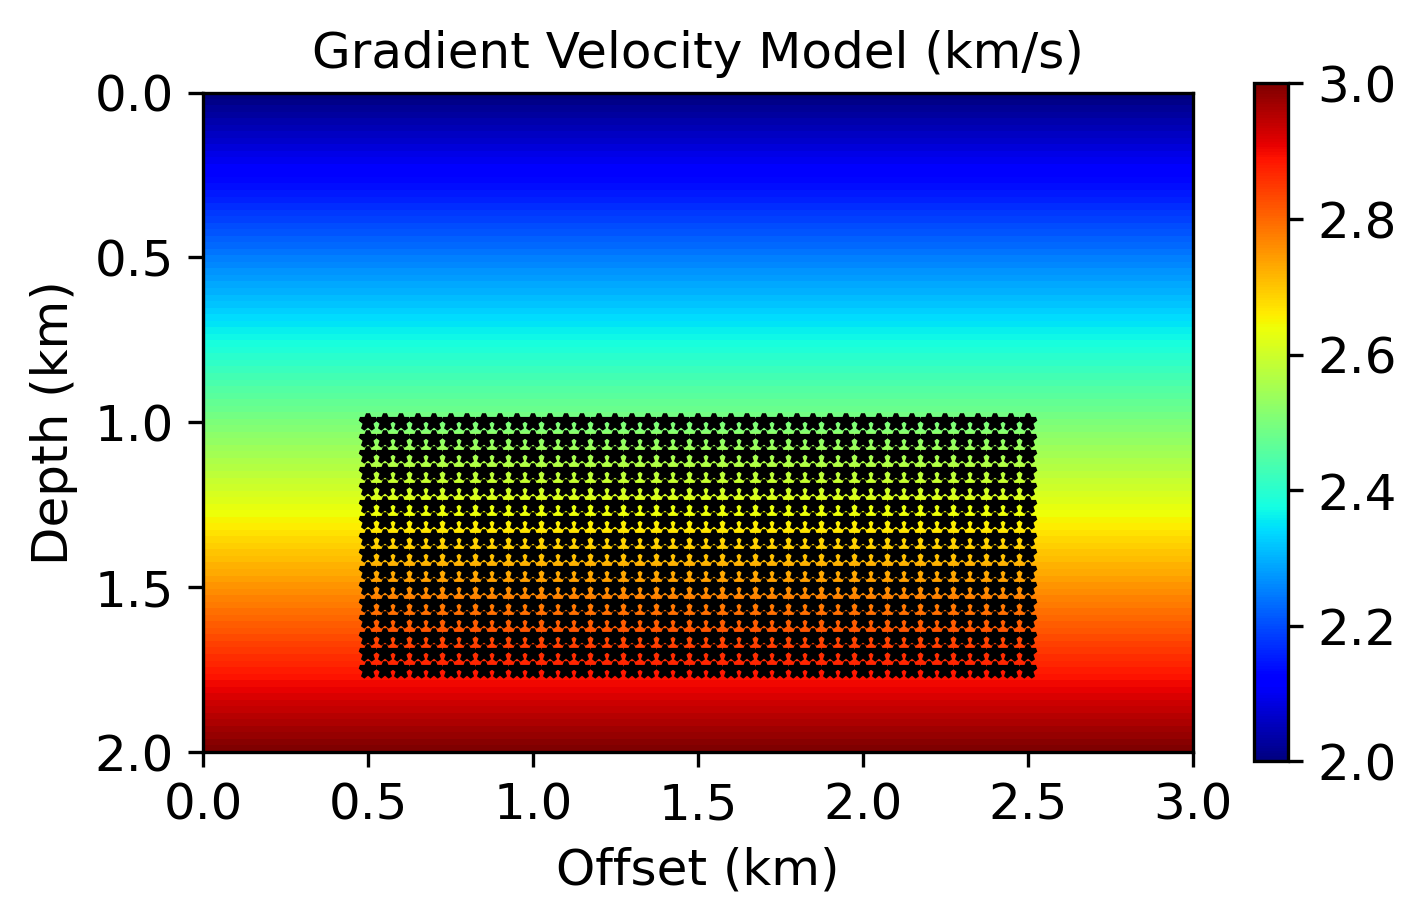

In [5]:
# Plot the velocity model with the source locations

fsize = 12

plt.figure(figsize=(5,3), dpi=300)

im = plt.imshow(velmodel, cmap='jet',aspect=1, extent=[0, 3, 2, 0])

cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=fsize)

plt.plot(cord_x, cord_z, 'k*', markersize=4)

# Add labels and title
plt.xlabel('Offset (km)',size = fsize)
plt.ylabel('Depth (km)',size = fsize)
plt.title('Gradient Velocity Model (km/s)',size = fsize)

plt.yticks(np.arange(0, 2.5, 0.5))

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.tight_layout()

# plt.savefig( 'gradient_velmodel.pdf' , dpi=300)

plt.show()

In [6]:
# Generate train set with traveltime solutions

y_train = torch.zeros(size=( num_of_data, nz, nx ))
x_train = torch.zeros(size=( num_of_data, 1, nx ))

n = 0 
k = 0

while k <= (num_of_data):    
    for i in range(len(sz)):
        for j in range(len(sx)):

            vs = v0 + vergrad*cord_z[i][j] + horgrad*cord_x[i][j]    # velocity at the source location
            
            # for homogenous velocity model  
            if vergrad == 0 and horgrad == 0:
                                  
                T_data = torch.sqrt((Z - cord_z[i][j])**2 + (X - cord_x[i][j])**2) / v0
                
            else:
                # for velocity gradient model
                T_data = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*
                                      ((X-cord_x[i][j])**2 + (Z-cord_z[i][j])**2)) / torch.sqrt(vergrad**2 + horgrad**2))
       
            x_train[k : :] = T_data[0]
            y_train[k : :] = T_data
        
            k = k + 1   

x_train = x_train.repeat( 1, nz, 1 )

print(np.shape(x_train))
print(np.shape(y_train))

torch.Size([656, 101, 151])
torch.Size([656, 101, 151])


In [7]:
# Generate test set with traveltime solutions

cord_z_test = np.random.uniform(1,1.75, size=(50))
cord_x_test = np.random.uniform(0.5,2.5, size=(50))

y_test = torch.zeros([len(cord_z_test),nz,nx])
x_test = torch.zeros([len(cord_z_test),1,nx])

n = 0 
k = 0

while k <= (len(cord_z_test)):
    for i in range( len( cord_z_test ) ):
         
        vs = v0 + vergrad*cord_z_test[i] + horgrad*cord_x_test[i]    # velocity at the source location

        # for homogenous velocity model  
        if vergrad == 0 and horgrad == 0:
                              
            T_data = torch.sqrt((Z - cord_z_test[i])**2 + (X - cord_x_test[i])**2) / v0
            
        else:
            # for velocity gradient model
            T_data = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*
                                  ((X-cord_x_test[i])**2 + (Z-cord_z_test[i])**2)) / torch.sqrt(vergrad**2 + horgrad**2))
    
        x_test[k : :] = T_data[0]
        y_test[k : :] = T_data
    
        k = k + 1    

x_test = x_test.repeat( 1, nz, 1 )

print(np.shape(x_test))
print(np.shape(y_test))

torch.Size([50, 101, 151])
torch.Size([50, 101, 151])


In [8]:
x_train = x_train.reshape( len(x_train), 1, nz, nx )
x_test = x_test.reshape( len(x_test), 1, nz, nx )

In [9]:
print(f'Input size of training data: {np.shape(x_train)}')
print(f'Input size of testing data: {np.shape(x_test)}')

print('--'*50)

print(f'output size of training data: {np.shape(y_train)}')
print(f'output size of testing data: {np.shape(y_test)}')

Input size of training data: torch.Size([656, 1, 101, 151])
Input size of testing data: torch.Size([50, 1, 101, 151])
----------------------------------------------------------------------------------------------------
output size of training data: torch.Size([656, 101, 151])
output size of testing data: torch.Size([50, 101, 151])


In [10]:
x_test = x_test.type('torch.FloatTensor')
y_test = y_test.type('torch.FloatTensor')
y_train =  y_train.type('torch.FloatTensor')
x_train = x_train.type('torch.FloatTensor')

In [11]:
batch_size = 1

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [12]:
# Loss function with rel/abs Lp loss

class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        # Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [16]:
ch1 = 2

class SimpleUNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1):
        
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block( in_channels, ch1)
        self.enc2 = self.conv_block( ch1, ch1*2 )
        self.enc3 = self.conv_block( ch1*2, ch1*4 )
        self.enc4 = self.conv_block( ch1*4, ch1*8)
    
        # Bottleneck
        self.bottleneck = self.conv_block( ch1*8, ch1*16 )
            
        # Decoder
        self.dec4 = self.upconv_block( ch1*16, ch1*8 )
        self.dec3 = self.upconv_block( ch1*8, ch1*4 )
        self.dec2 = self.upconv_block( ch1*4, ch1*2 )
        self.dec1 = self.upconv_block( ch1*2, ch1 )
    
        # Final Output
        self.final_conv = nn.Conv2d( ch1, out_channels, kernel_size=1)

        # Channel reduction after concatenation
        self.conv_after_concat4 = self.conv_block( ch1*16, ch1*8 )  
        self.conv_after_concat3 = self.conv_block( ch1*8, ch1*4 )  
        self.conv_after_concat2 = self.conv_block( ch1*4, ch1*2 ) 
        self.conv_after_concat1 = self.conv_block( ch1*2, ch1 )

    def conv_block(self, in_channels, out_channels):
        
        return nn.Sequential(
            
            nn.Conv2d( in_channels, out_channels, kernel_size=3, padding=1 ),
            nn.ReLU( inplace=True ),
            
            nn.Conv2d( out_channels, out_channels, kernel_size=3, padding=1 ),
            nn.ReLU( inplace=True ),
        )

    def upconv_block(self, in_channels, out_channels):
        
        return nn.Sequential(
            
            nn.ConvTranspose2d( in_channels, out_channels, kernel_size=2, stride=2 ),            
        )

    def forward(self, x):

        # Encoder Path
        enc1 = self.enc1(x)
        enc2 = self.enc2( F.max_pool2d( enc1, kernel_size=2 ))  
        enc3 = self.enc3( F.max_pool2d( enc2, kernel_size=2 ))
        enc4 = self.enc4( F.max_pool2d( enc3, kernel_size=2 ))

        # Bottleneck
        bottleneck = self.bottleneck( F.max_pool2d( enc4, kernel_size=2 ))        

        # Decoder Path
        dec4 = self.dec4(bottleneck)
        diffY = enc4.size()[2] - dec4.size()[2]
        diffX = enc4.size()[3] - dec4.size()[3]
        dec4 = F.pad( dec4, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])        
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.conv_after_concat4(dec4)  

        dec3 = self.dec3(dec4)
        diffY = enc3.size()[2] - dec3.size()[2]
        diffX = enc3.size()[3] - dec3.size()[3]
        dec3 = F.pad( dec3, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.conv_after_concat3(dec3)

        dec2 = self.dec2(dec3)        
        diffY = enc2.size()[2] - dec2.size()[2]
        diffX = enc2.size()[3] - dec2.size()[3]
        dec2 = F.pad( dec2, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])        
        dec2 = torch.cat((dec2, enc2), dim=1) 
        dec2 = self.conv_after_concat2(dec2)  
        
        dec1 = self.dec1(dec2)        
        diffY = enc1.size()[2] - dec1.size()[2]
        diffX = enc1.size()[3] - dec1.size()[3]
        dec1 = F.pad( dec1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])        
        dec1 = torch.cat((dec1, enc1), dim=1) 
        dec1 = self.conv_after_concat1(dec1)  

        # Final Convolution
        output = self.final_conv(dec1)
        
        return output


In [ ]:
model = SimpleUNet().cuda()


In [18]:
learning_rate = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)

myloss = LpLoss(size_average=False)

patience = 50  # Number of epochs to wait before stopping

In [ ]:
# To save the model

model_name = 'Unet_Model_gradient_'+str(int(spacing*1000))+'m_train_best.pt'

model_name

  1%|▎                                       | 8/1000 [01:23<2:50:38, 10.32s/it]

Epoch:9 
 Training time for  epoch 9: 0.173 minutes,Training loss:  0.040759972796389245, Testing loss: 0.038683487102389336


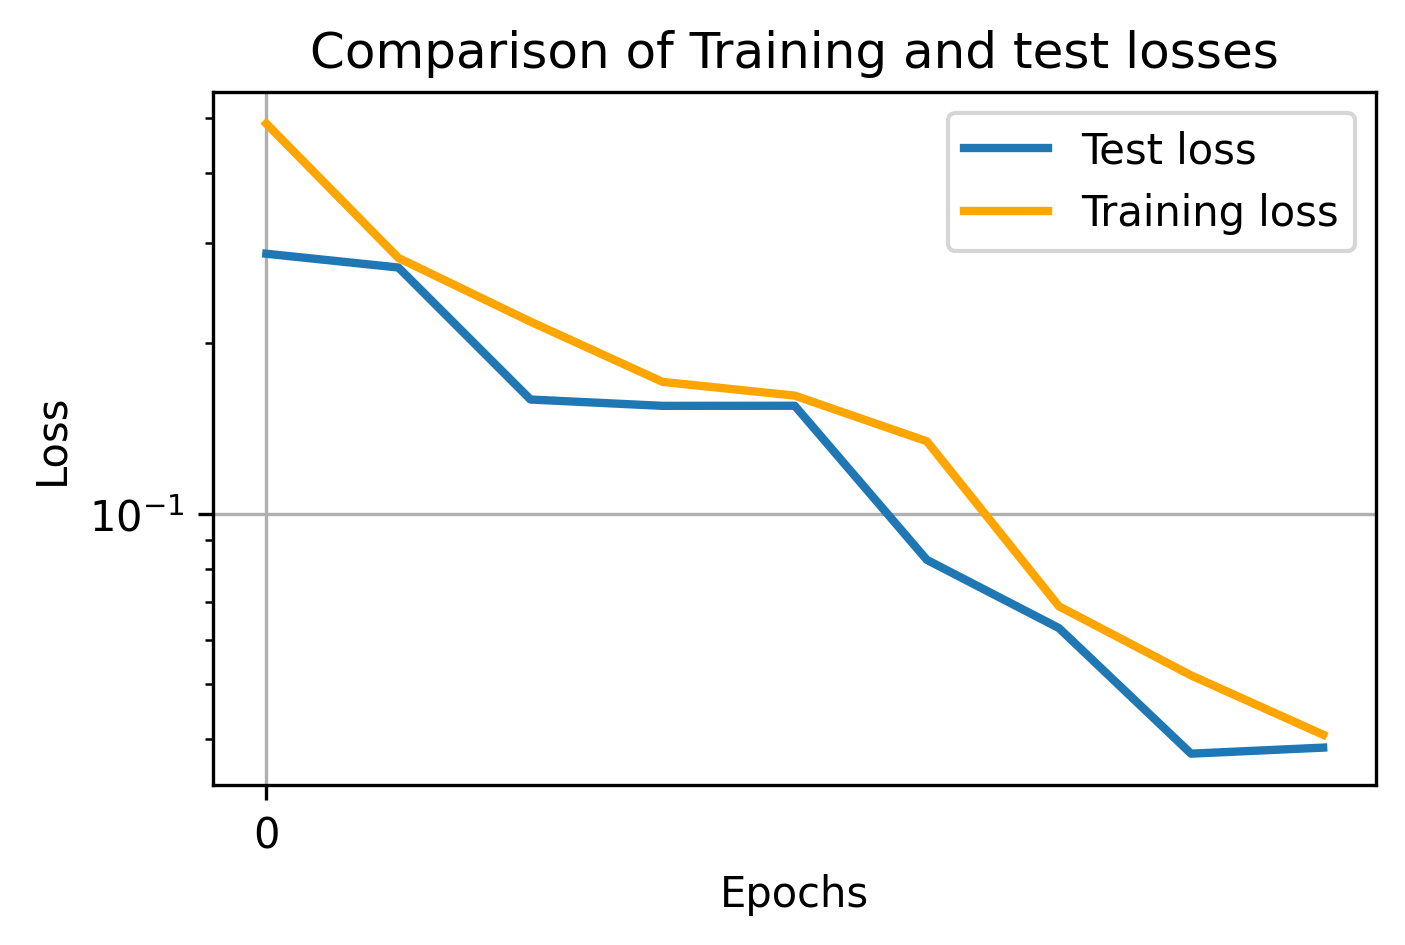

  2%|▋                                      | 18/1000 [03:05<2:39:21,  9.74s/it]

Epoch:19 
 Training time for  epoch 19: 0.185 minutes,Training loss:  0.021754108870504198, Testing loss: 0.02094704929739237


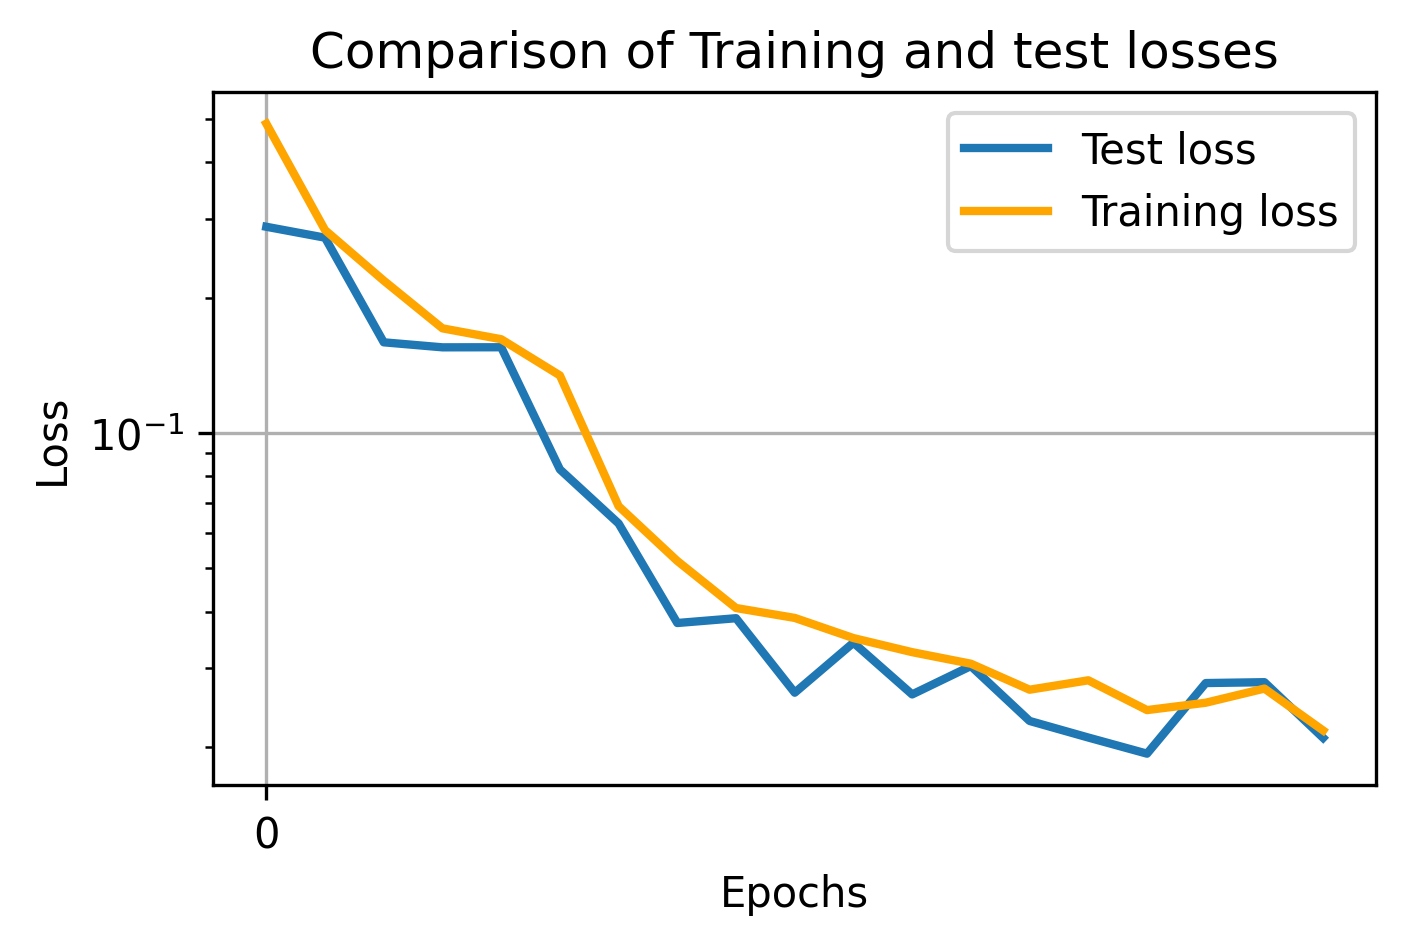

  3%|█                                      | 28/1000 [04:48<2:42:48, 10.05s/it]

Epoch:29 
 Training time for  epoch 29: 0.181 minutes,Training loss:  0.019661439656529847, Testing loss: 0.02207673866301775


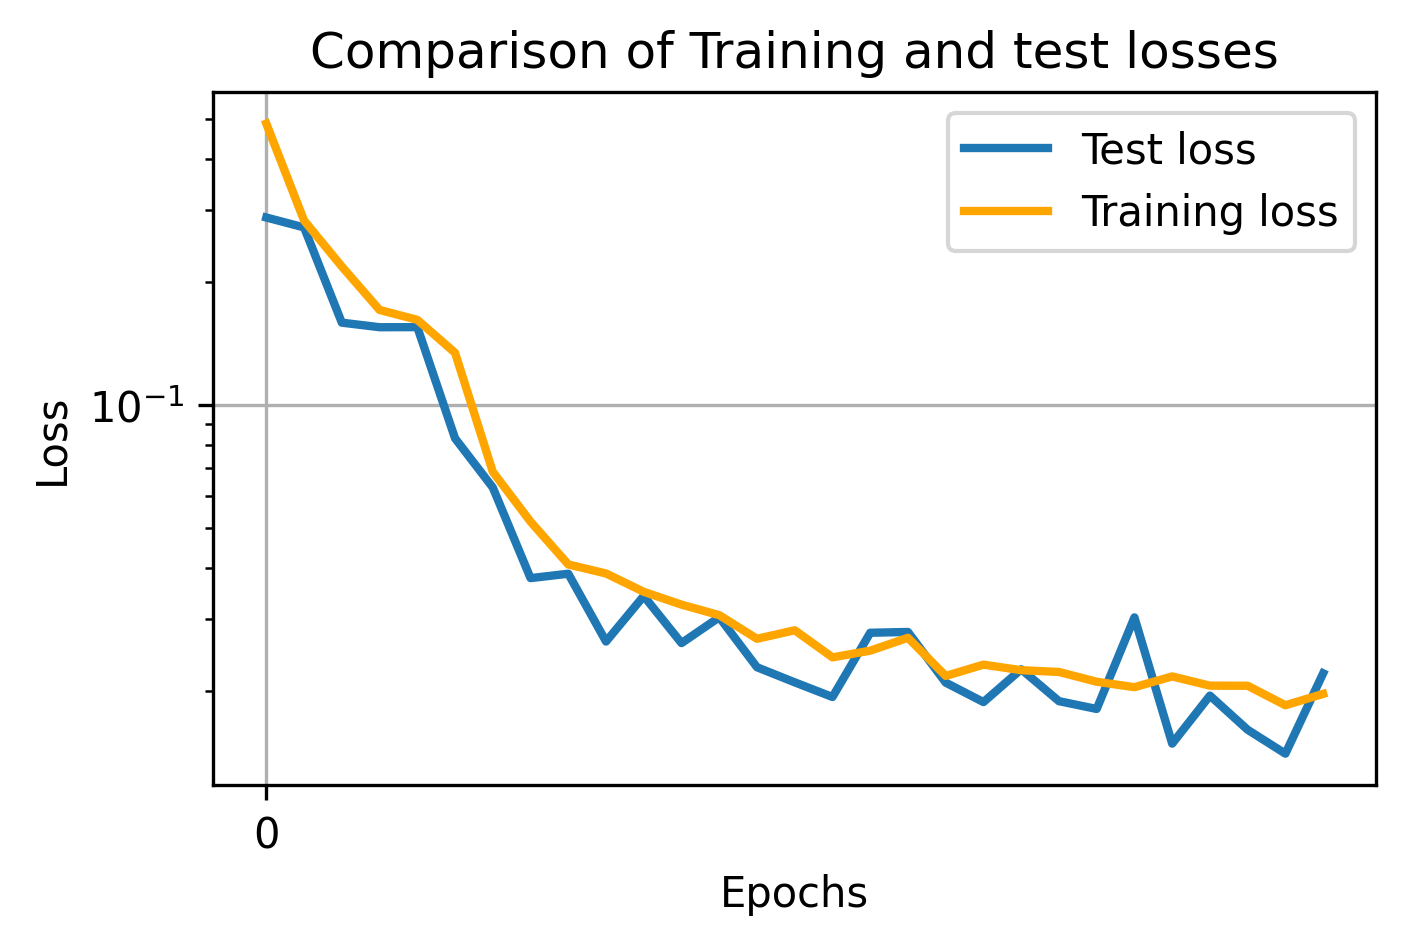

  4%|█▍                                     | 38/1000 [06:26<2:25:41,  9.09s/it]

Epoch:39 
 Training time for  epoch 39: 0.108 minutes,Training loss:  0.019000190913552283, Testing loss: 0.01797862146049738


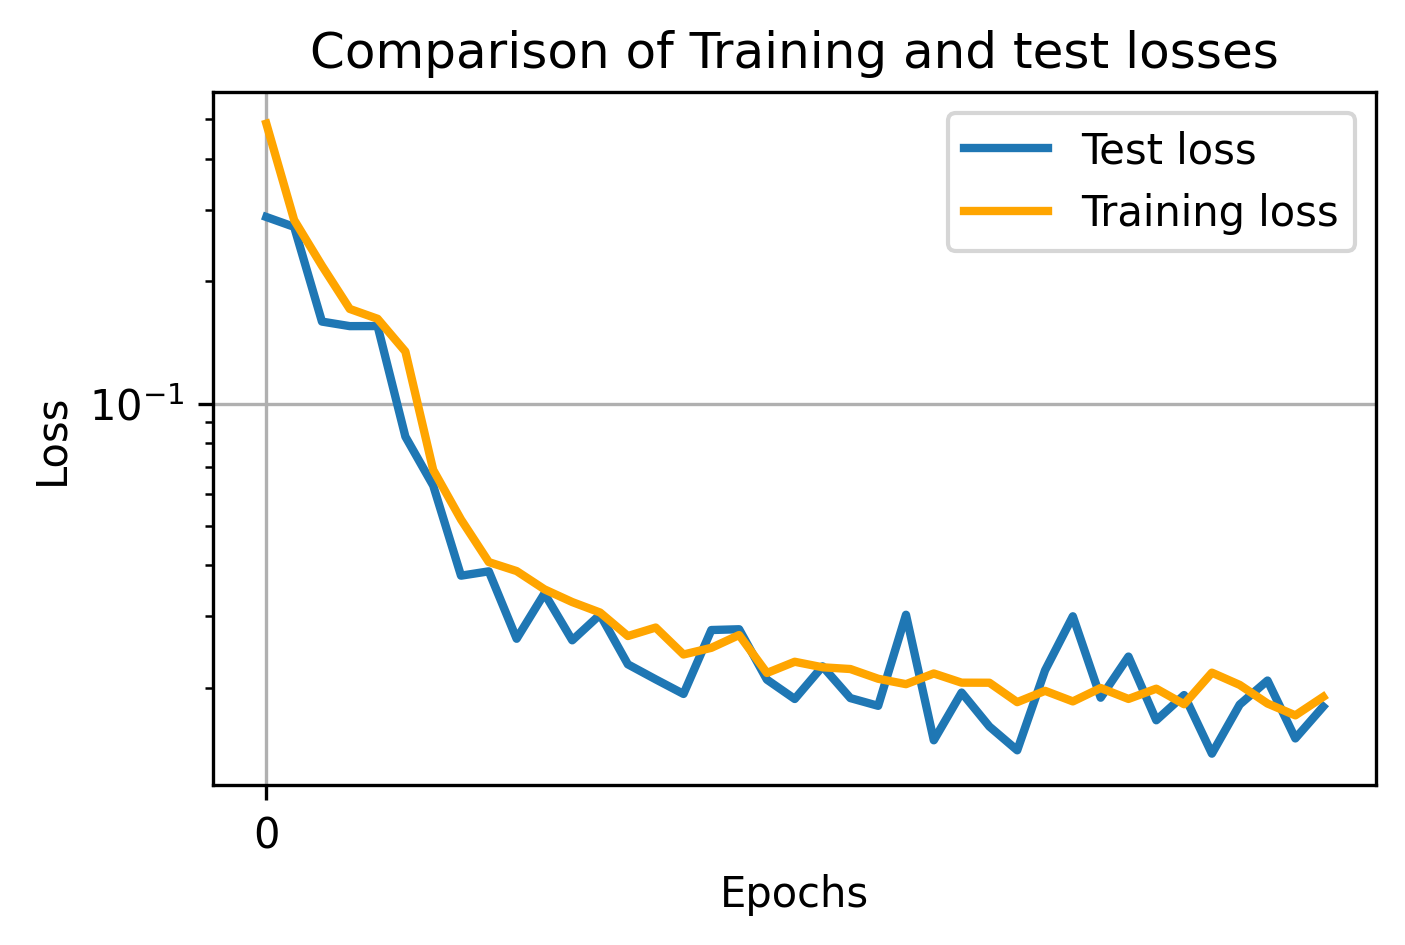

  5%|█▊                                     | 48/1000 [08:01<2:45:33, 10.43s/it]

Epoch:49 
 Training time for  epoch 49: 0.168 minutes,Training loss:  0.0166578247728644, Testing loss: 0.020300822276622058


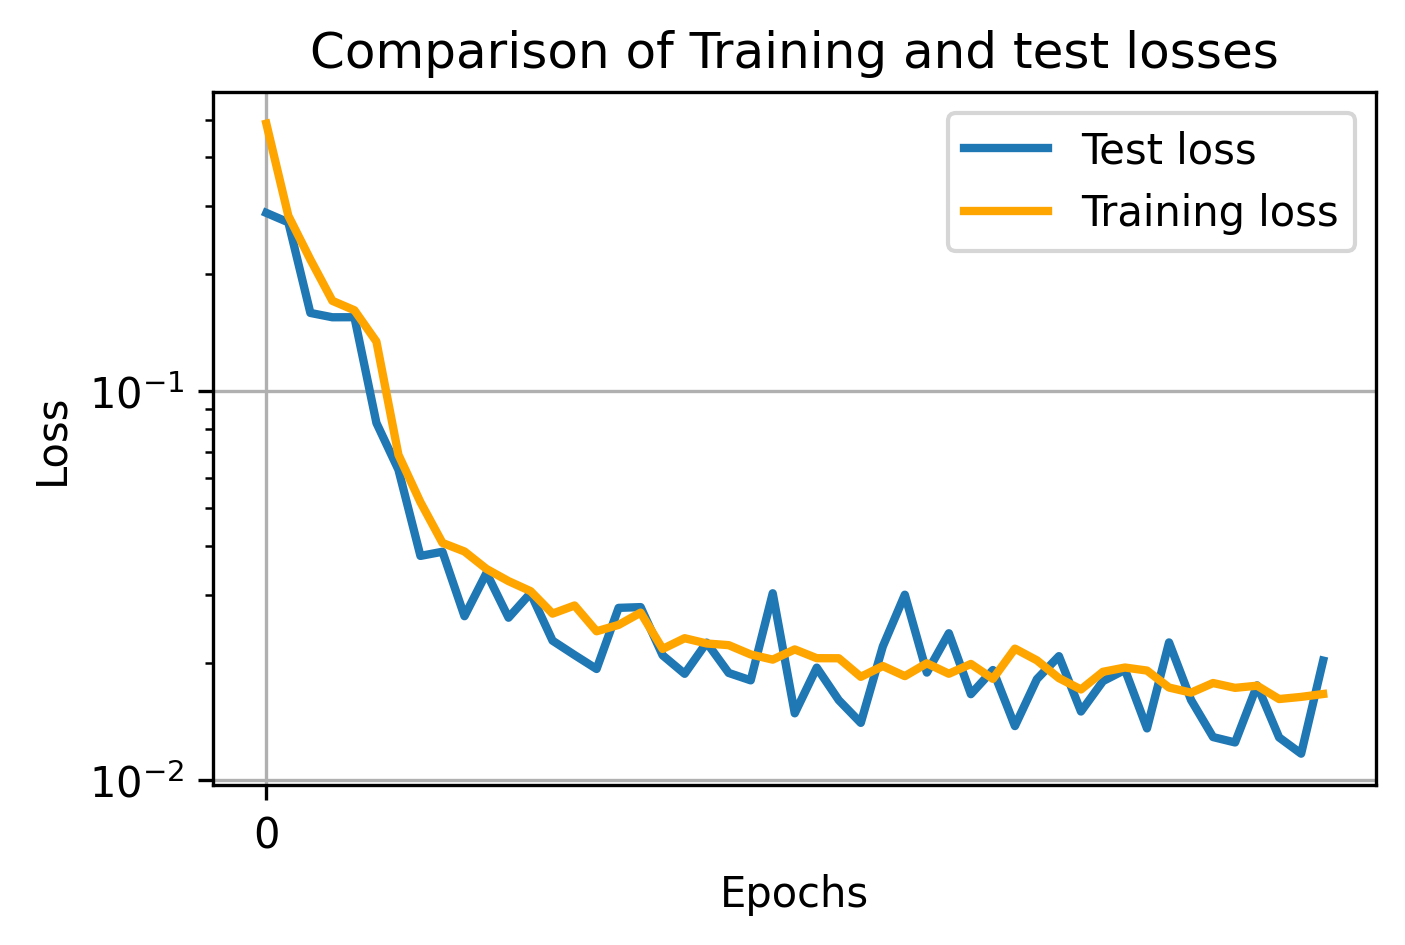

  6%|██▎                                    | 58/1000 [09:44<2:40:44, 10.24s/it]

Epoch:59 
 Training time for  epoch 59: 0.174 minutes,Training loss:  0.015286742360331118, Testing loss: 0.015300036128610372


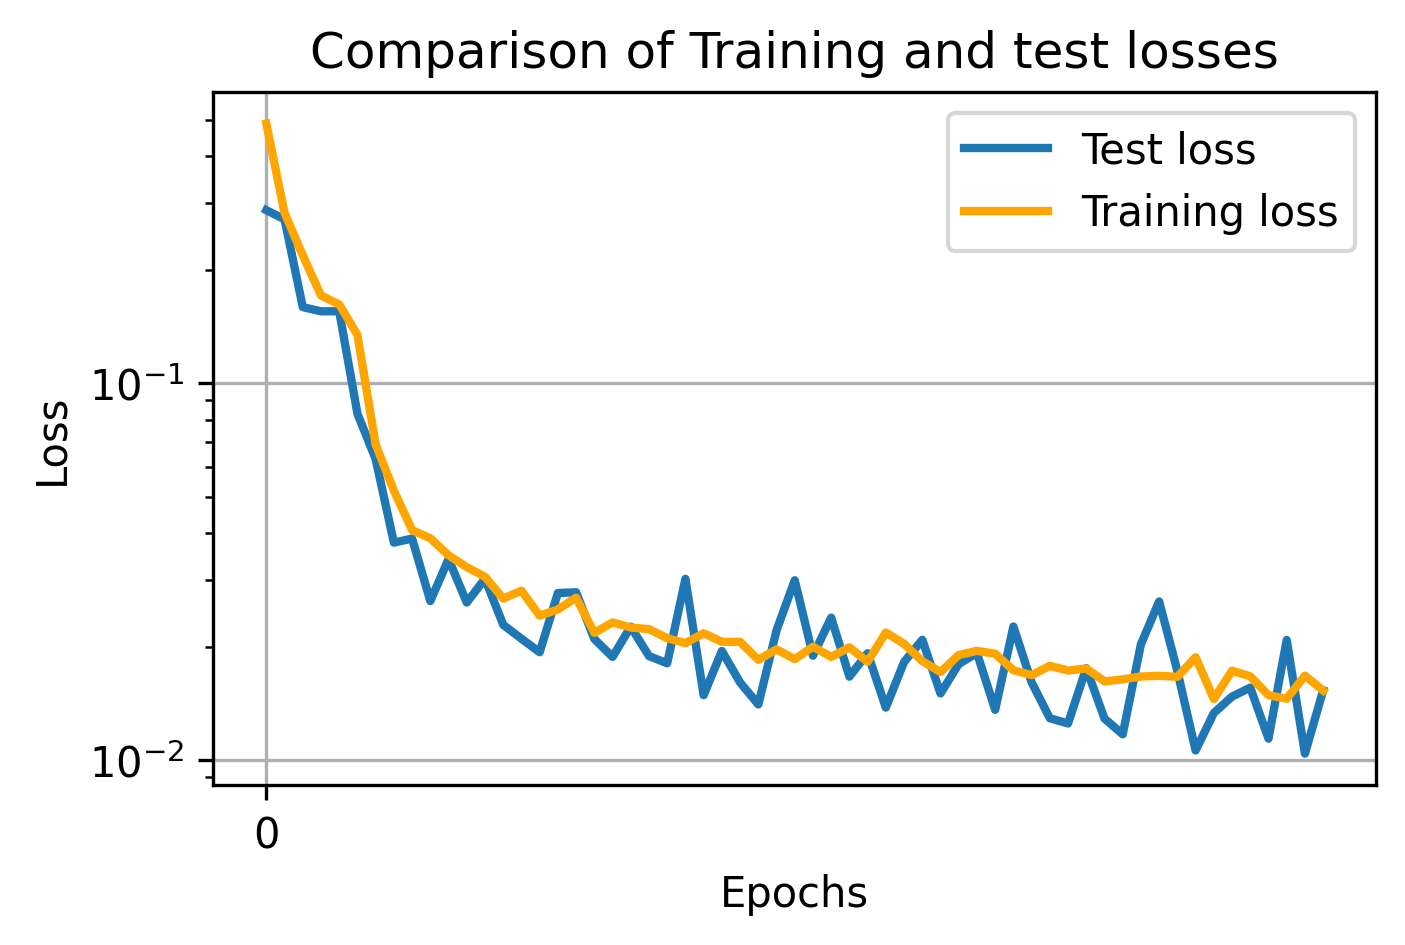

  7%|██▋                                    | 68/1000 [11:07<2:03:23,  7.94s/it]

Epoch:69 
 Training time for  epoch 69: 0.183 minutes,Training loss:  0.015048111705876114, Testing loss: 0.015301654879003763


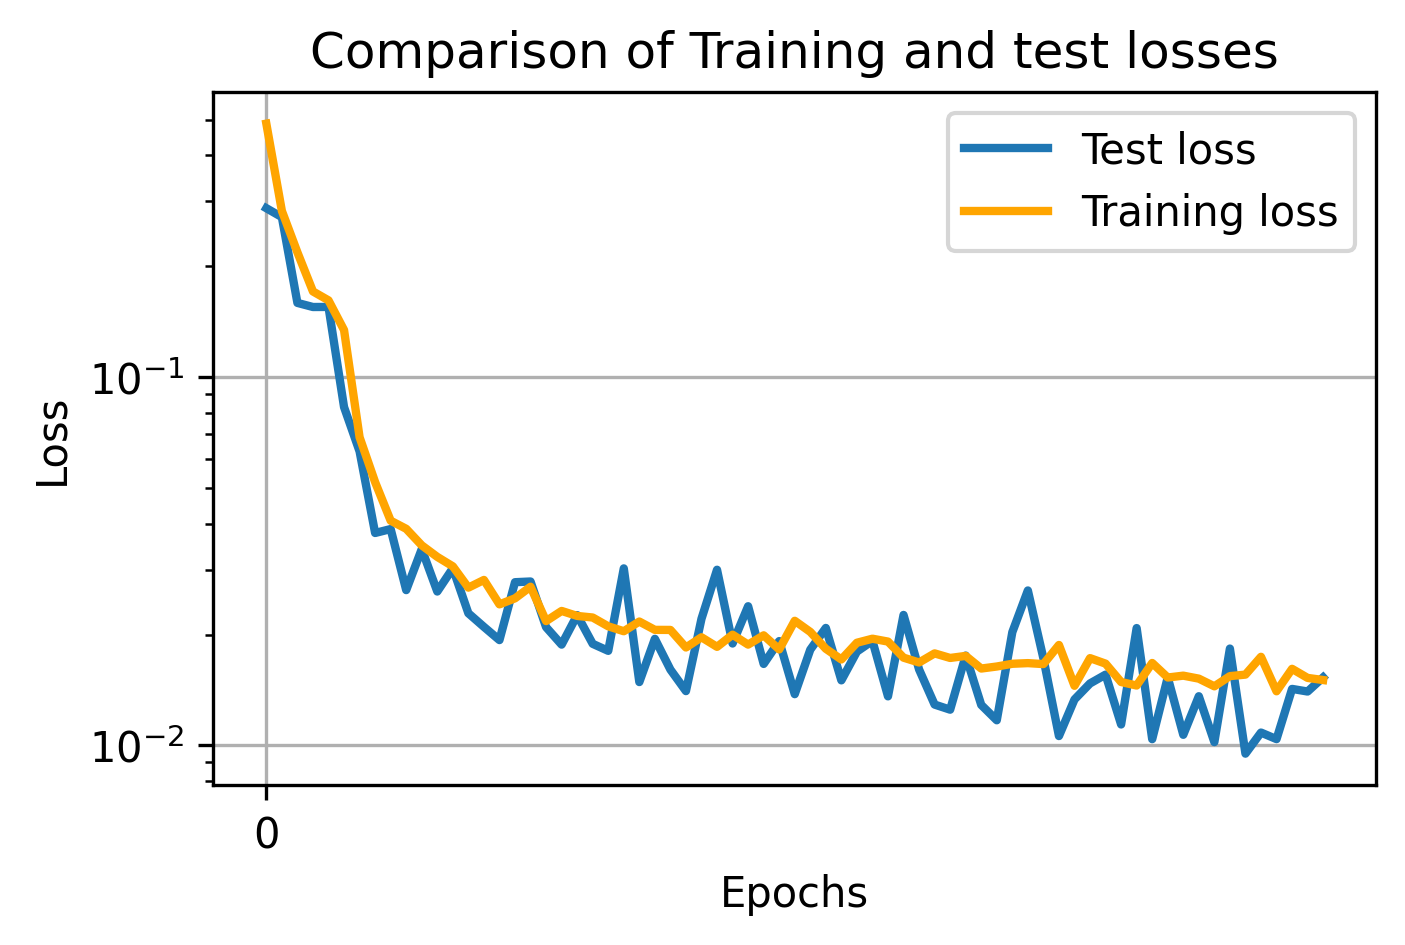

  8%|███                                    | 78/1000 [12:53<2:42:12, 10.56s/it]

Epoch:79 
 Training time for  epoch 79: 0.177 minutes,Training loss:  0.013995972222069324, Testing loss: 0.010480753742158413


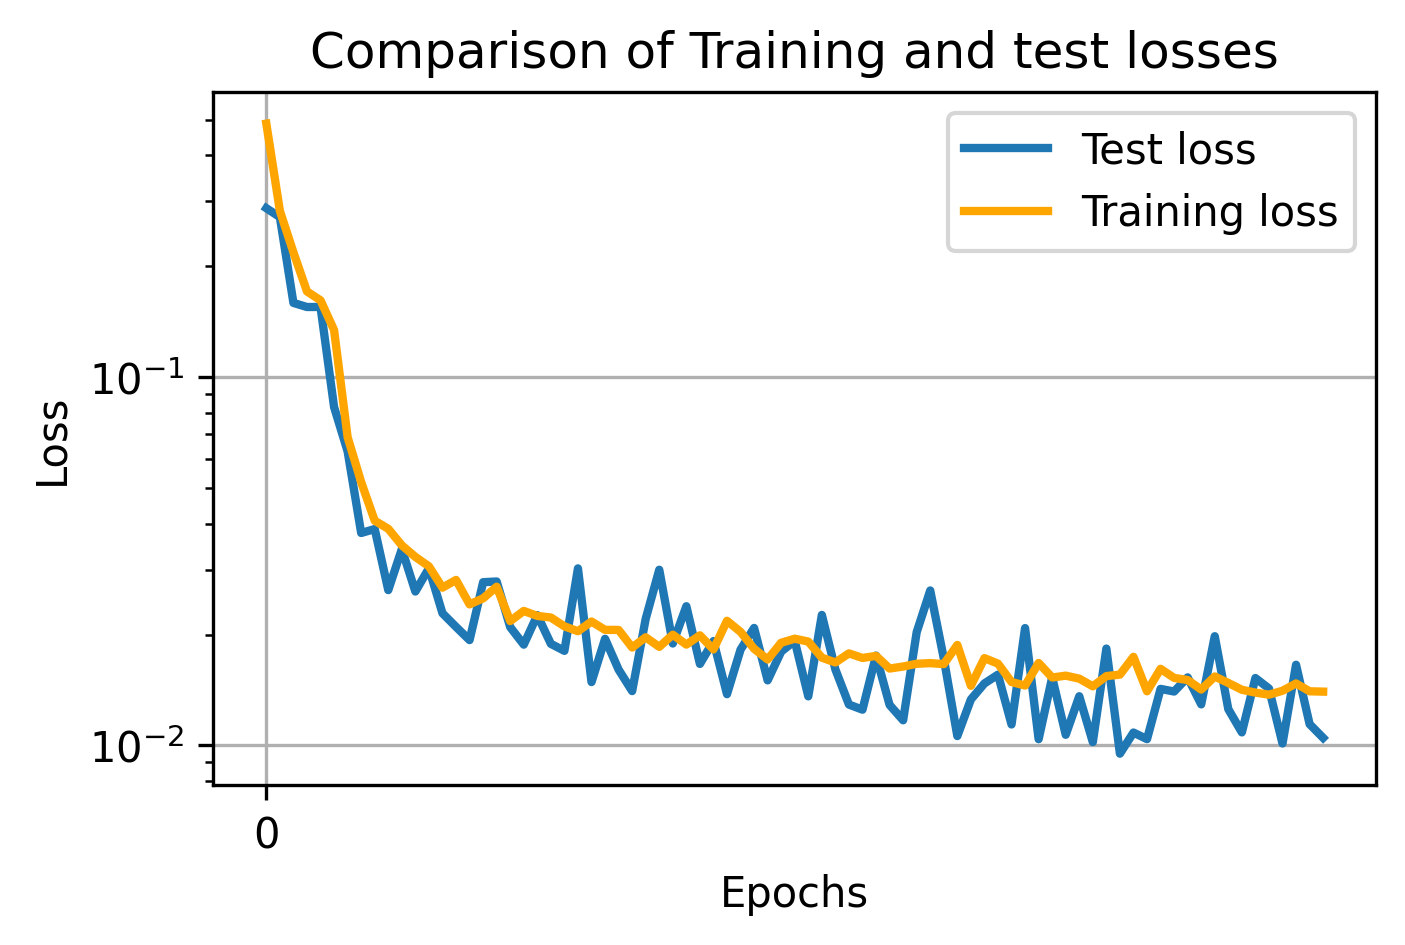

  9%|███▍                                   | 88/1000 [14:29<2:16:00,  8.95s/it]

Epoch:89 
 Training time for  epoch 89: 0.109 minutes,Training loss:  0.012759687606864268, Testing loss: 0.010992990583181381


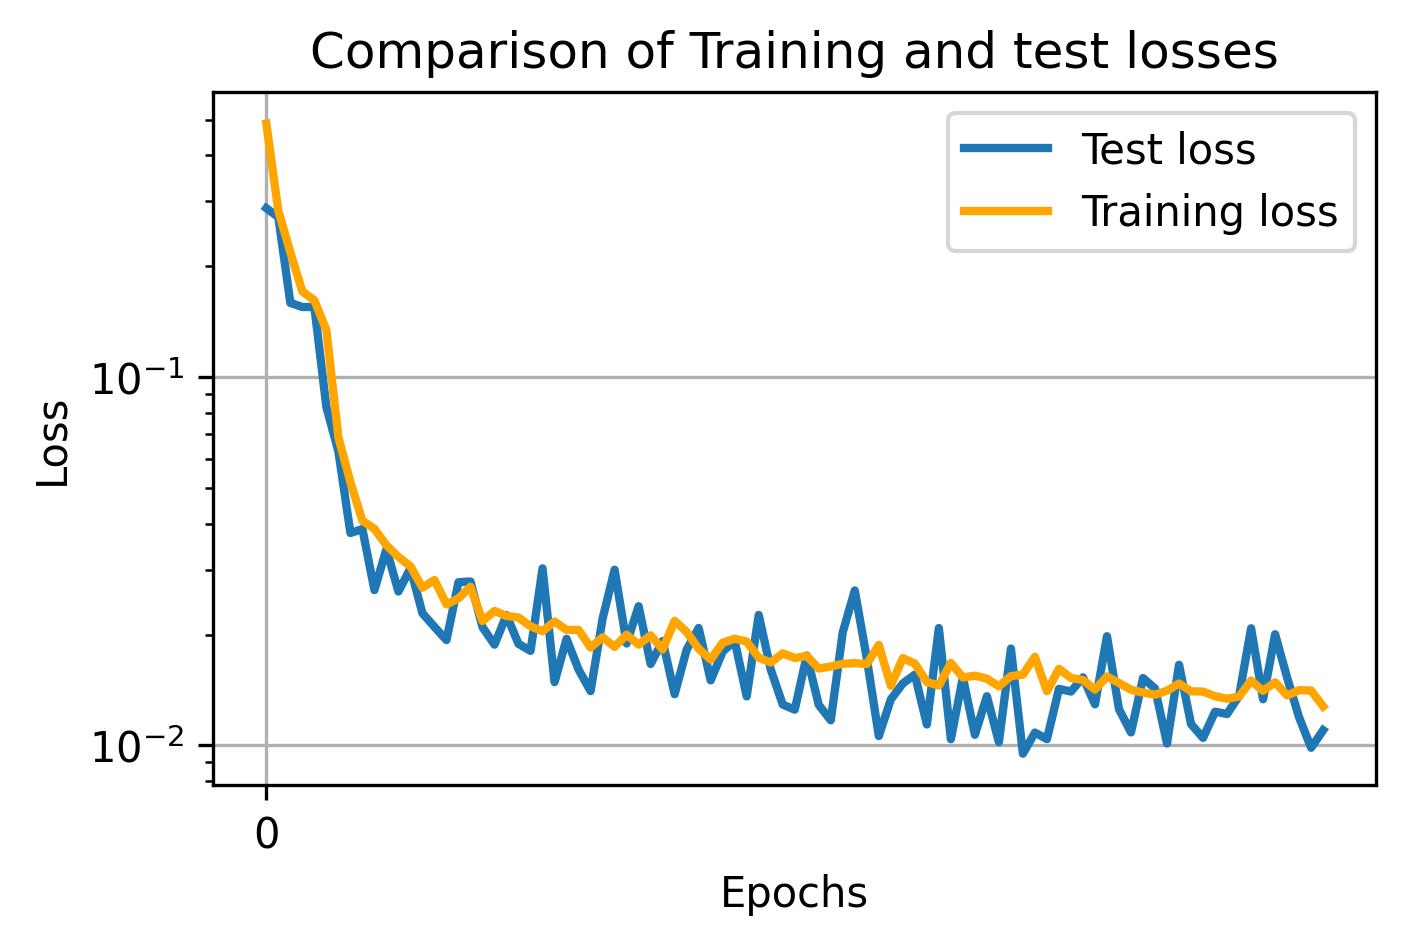

 10%|███▊                                   | 98/1000 [16:10<2:36:17, 10.40s/it]

Epoch:99 
 Training time for  epoch 99: 0.18 minutes,Training loss:  0.01339481252873112, Testing loss: 0.009997064648196101


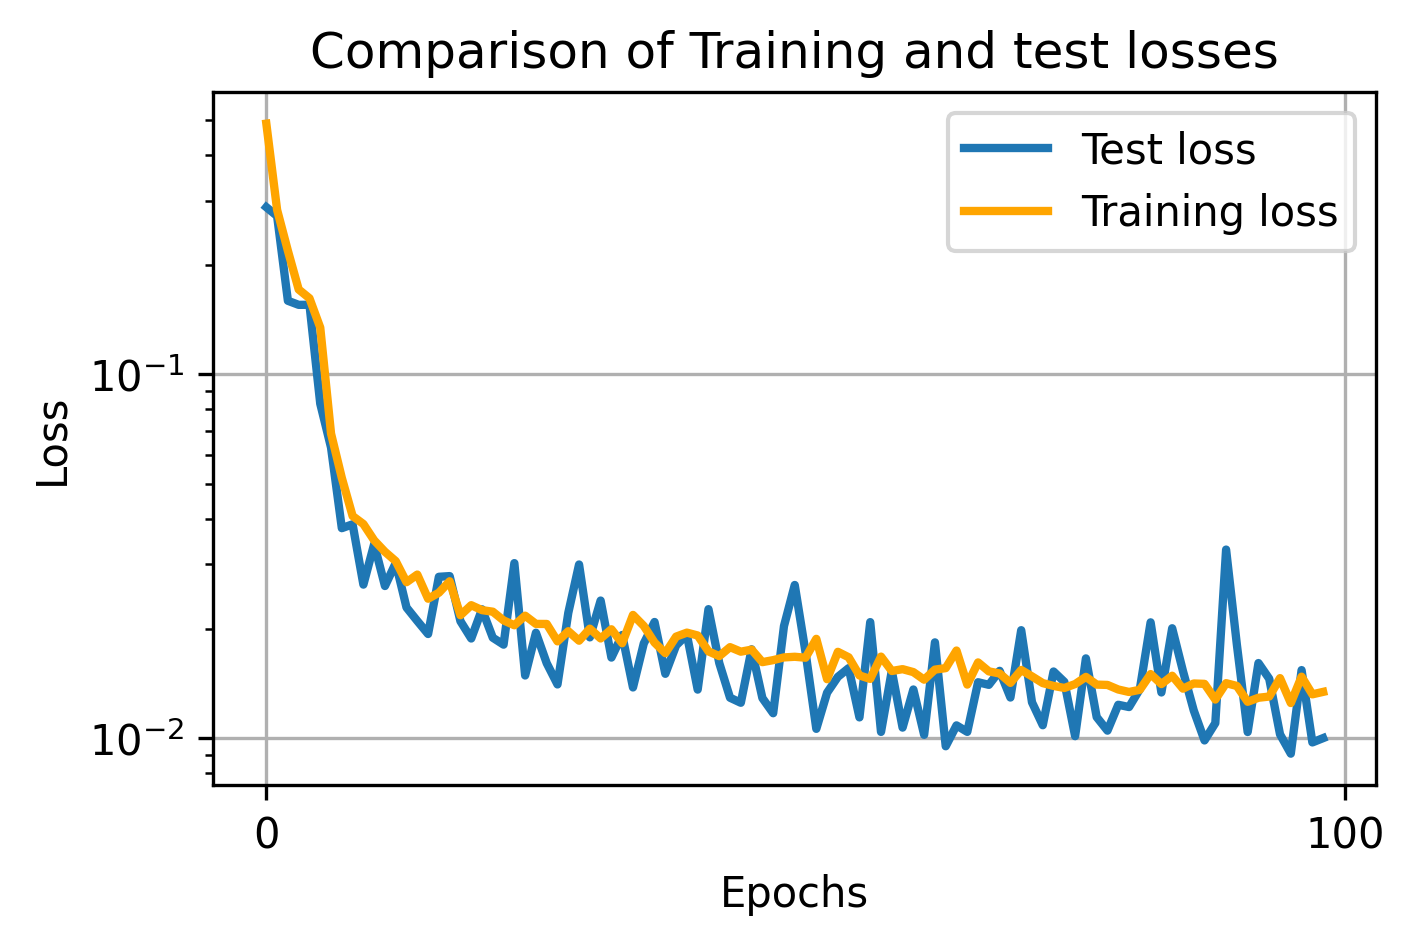

 11%|████                                  | 108/1000 [17:56<2:34:13, 10.37s/it]

Epoch:109 
 Training time for  epoch 109: 0.177 minutes,Training loss:  0.014040399122012144, Testing loss: 0.013877773527055978


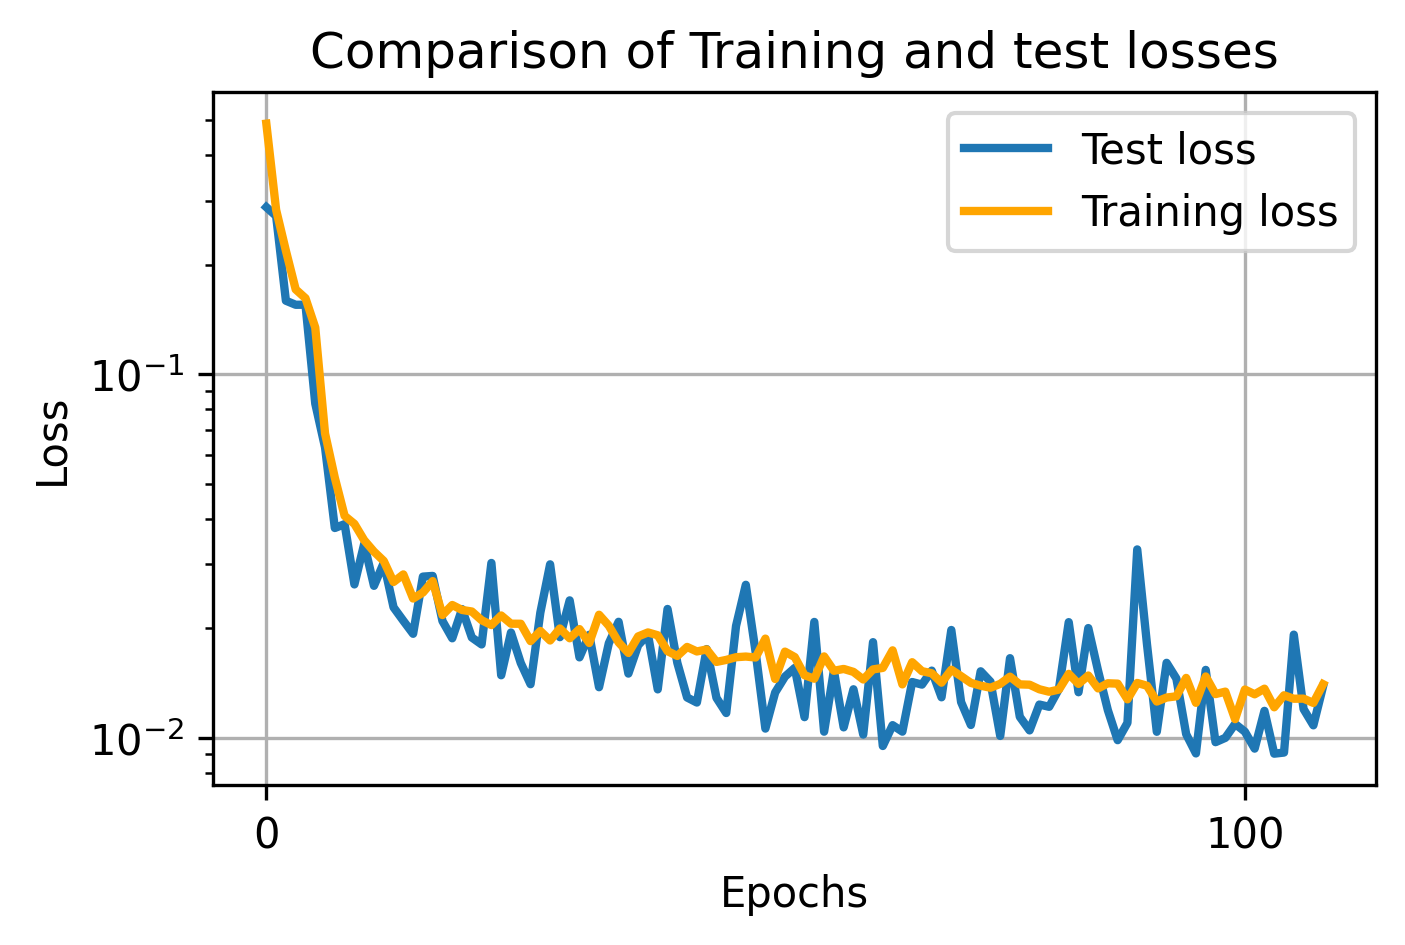

 11%|████▏                                 | 110/1000 [18:18<2:38:53, 10.71s/it]

Epoch 00111: reducing learning rate of group 0 to 8.0000e-04.


 12%|████▍                                 | 118/1000 [19:33<2:22:32,  9.70s/it]

Epoch:119 
 Training time for  epoch 119: 0.18 minutes,Training loss:  0.009890701586278382, Testing loss: 0.011131396908313036


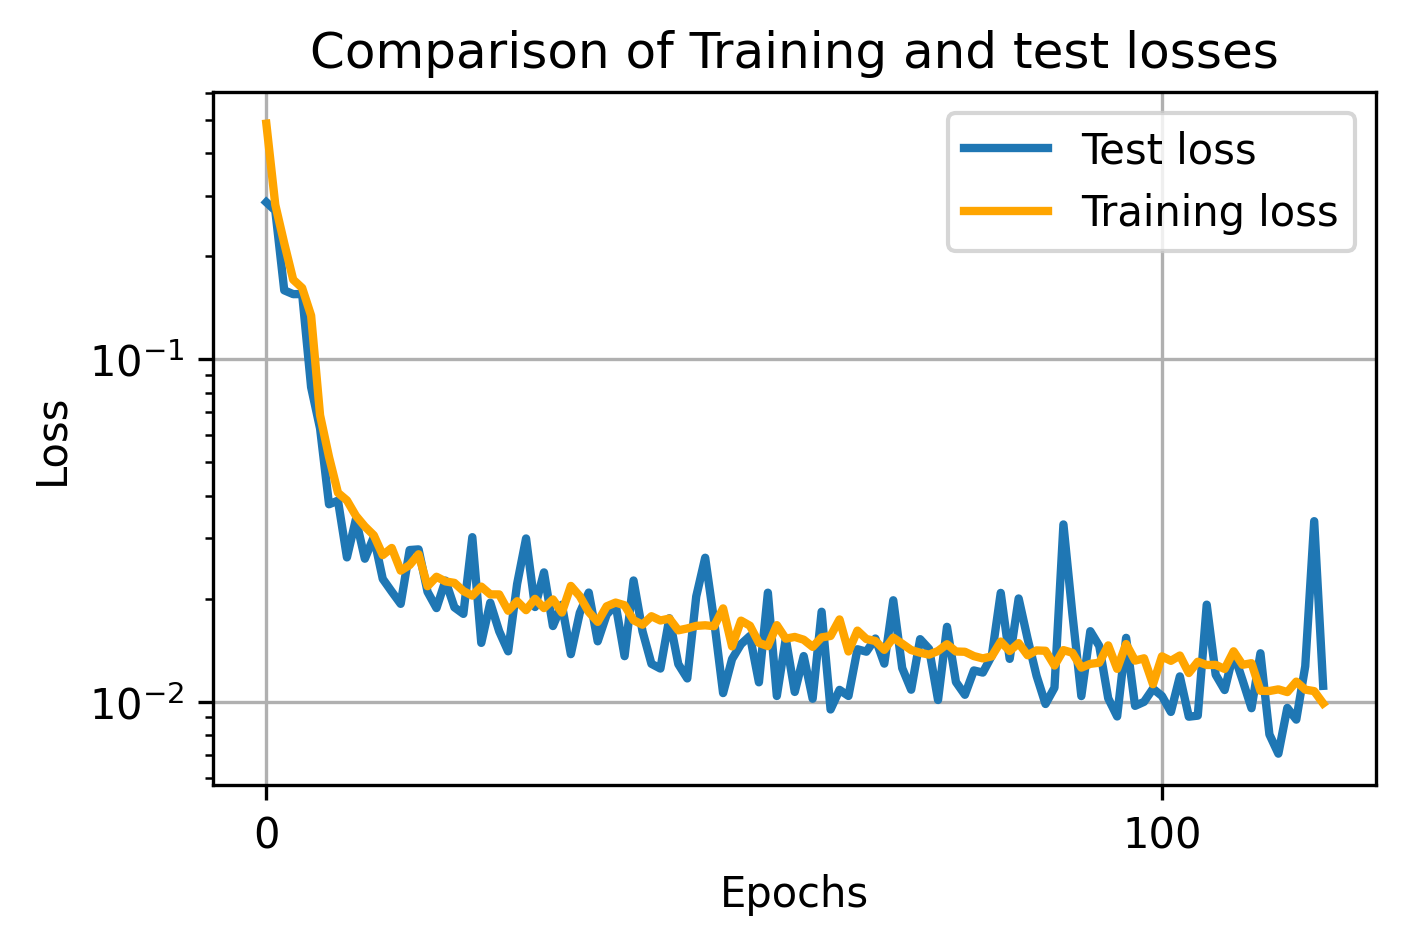

 13%|████▊                                 | 128/1000 [21:15<2:31:21, 10.41s/it]

Epoch:129 
 Training time for  epoch 129: 0.171 minutes,Training loss:  0.010262205380458021, Testing loss: 0.012135981544852258


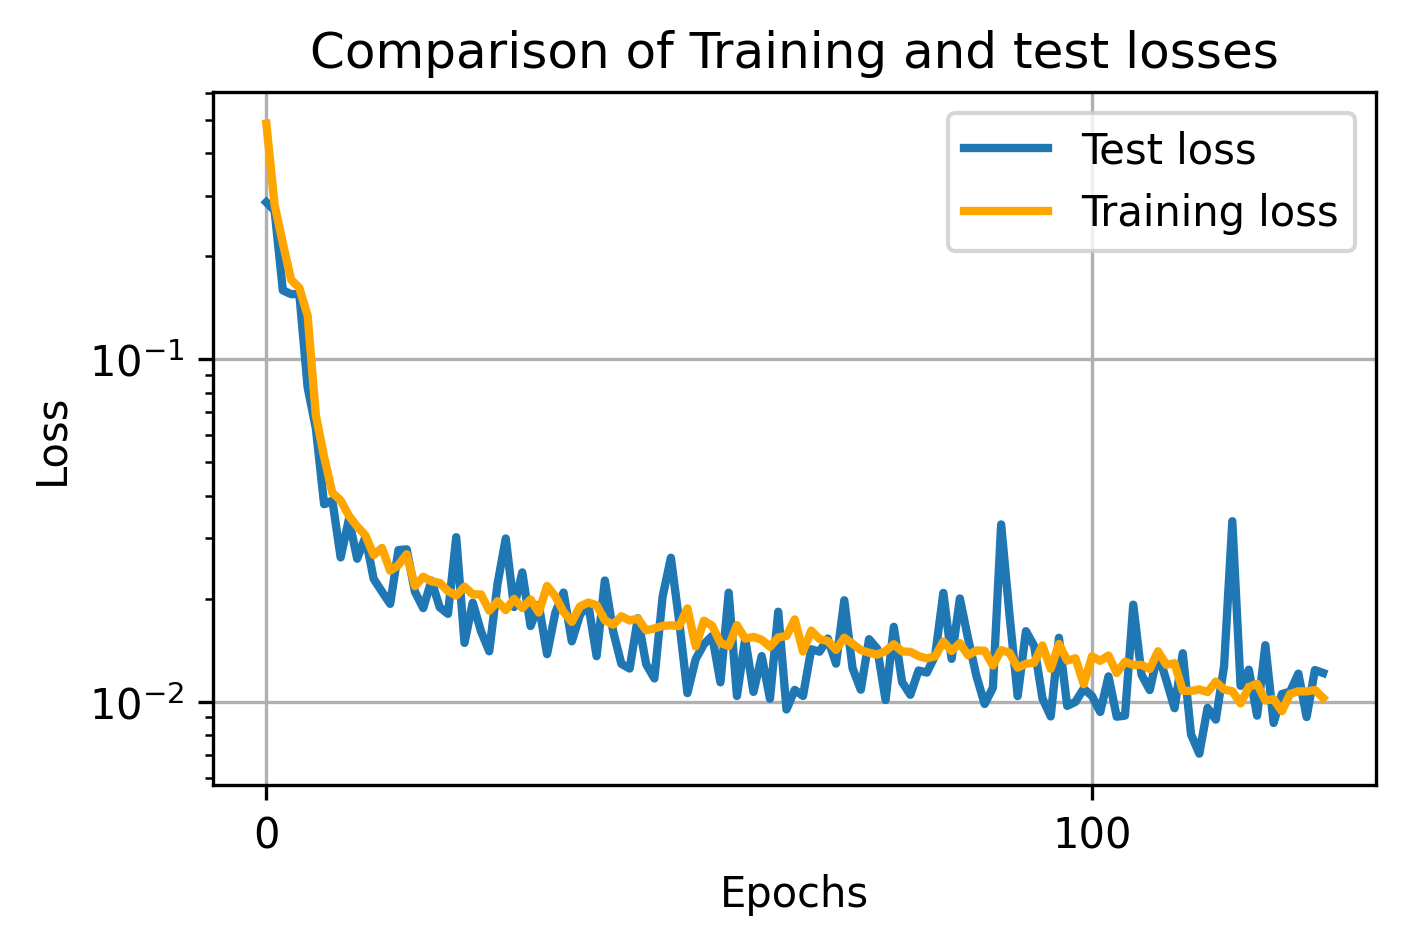

 13%|█████                                 | 134/1000 [22:18<2:31:34, 10.50s/it]

Epoch 00135: reducing learning rate of group 0 to 6.4000e-04.


 14%|█████▏                                | 138/1000 [23:01<2:36:26, 10.89s/it]

Epoch:139 
 Training time for  epoch 139: 0.172 minutes,Training loss:  0.008579166293024972, Testing loss: 0.012551070507615805


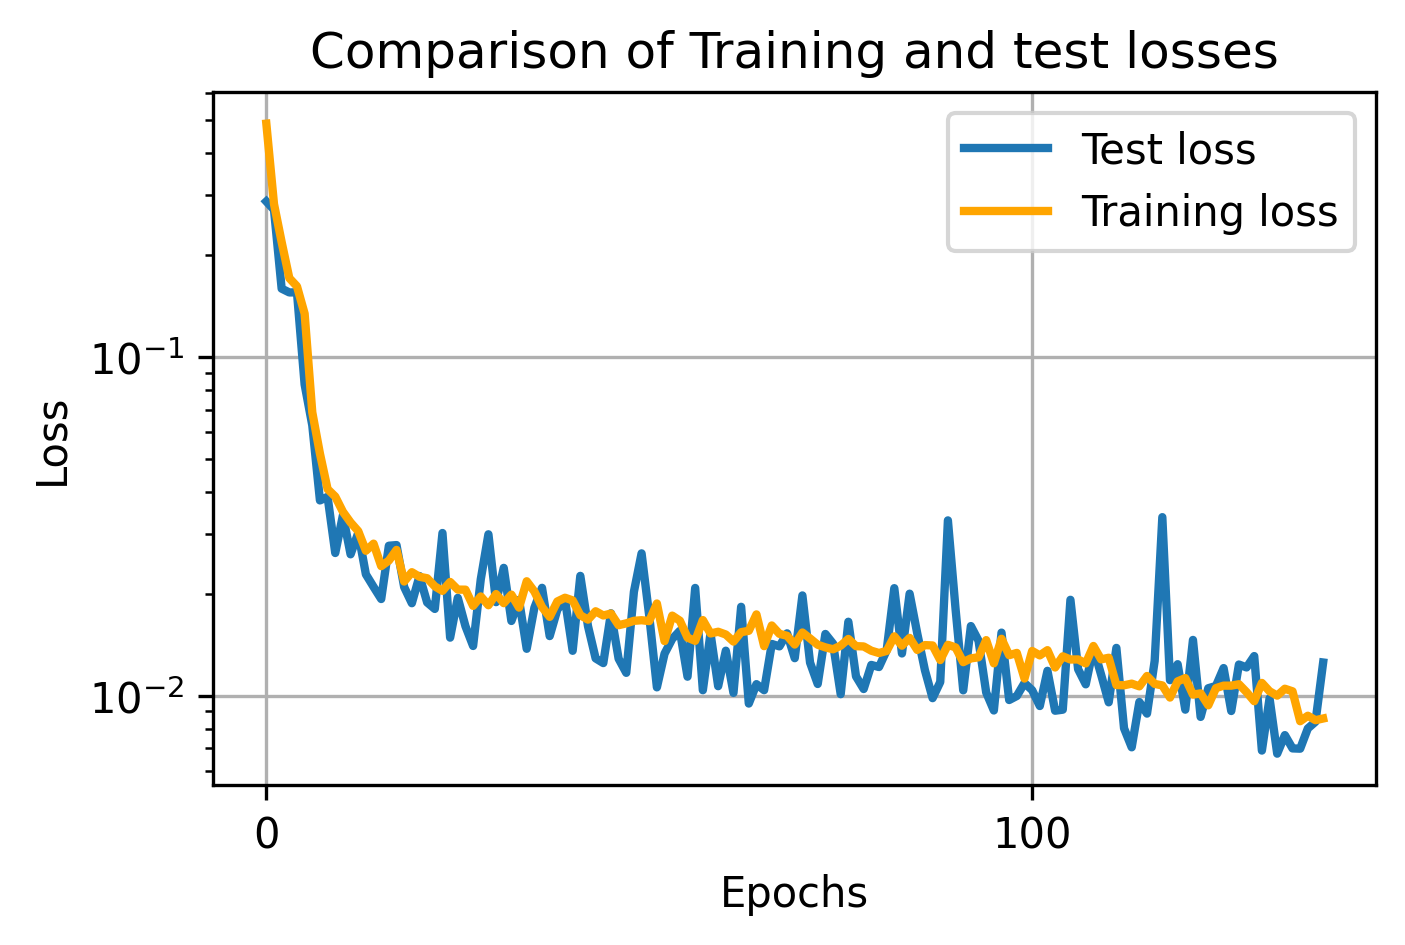

 15%|█████▌                                | 148/1000 [24:42<2:07:27,  8.98s/it]

Epoch:149 
 Training time for  epoch 149: 0.184 minutes,Training loss:  0.008274225681372805, Testing loss: 0.00577076755464077


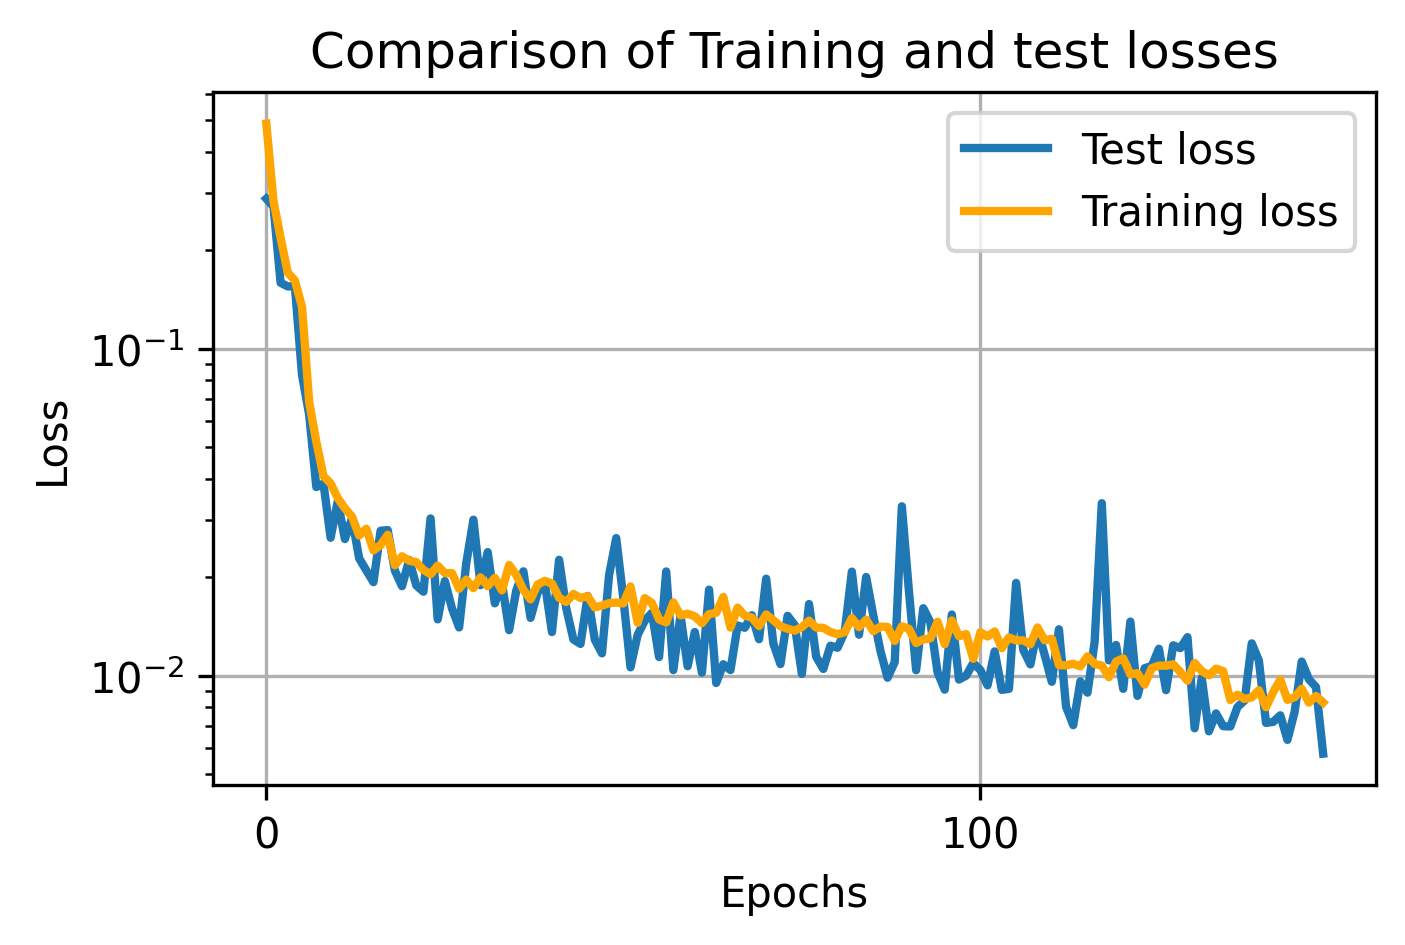

 15%|█████▋                                | 151/1000 [25:13<2:18:22,  9.78s/it]

Epoch 00152: reducing learning rate of group 0 to 5.1200e-04.


 16%|██████                                | 158/1000 [26:25<2:14:53,  9.61s/it]

Epoch:159 
 Training time for  epoch 159: 0.107 minutes,Training loss:  0.007227702567456063, Testing loss: 0.005115052964538336


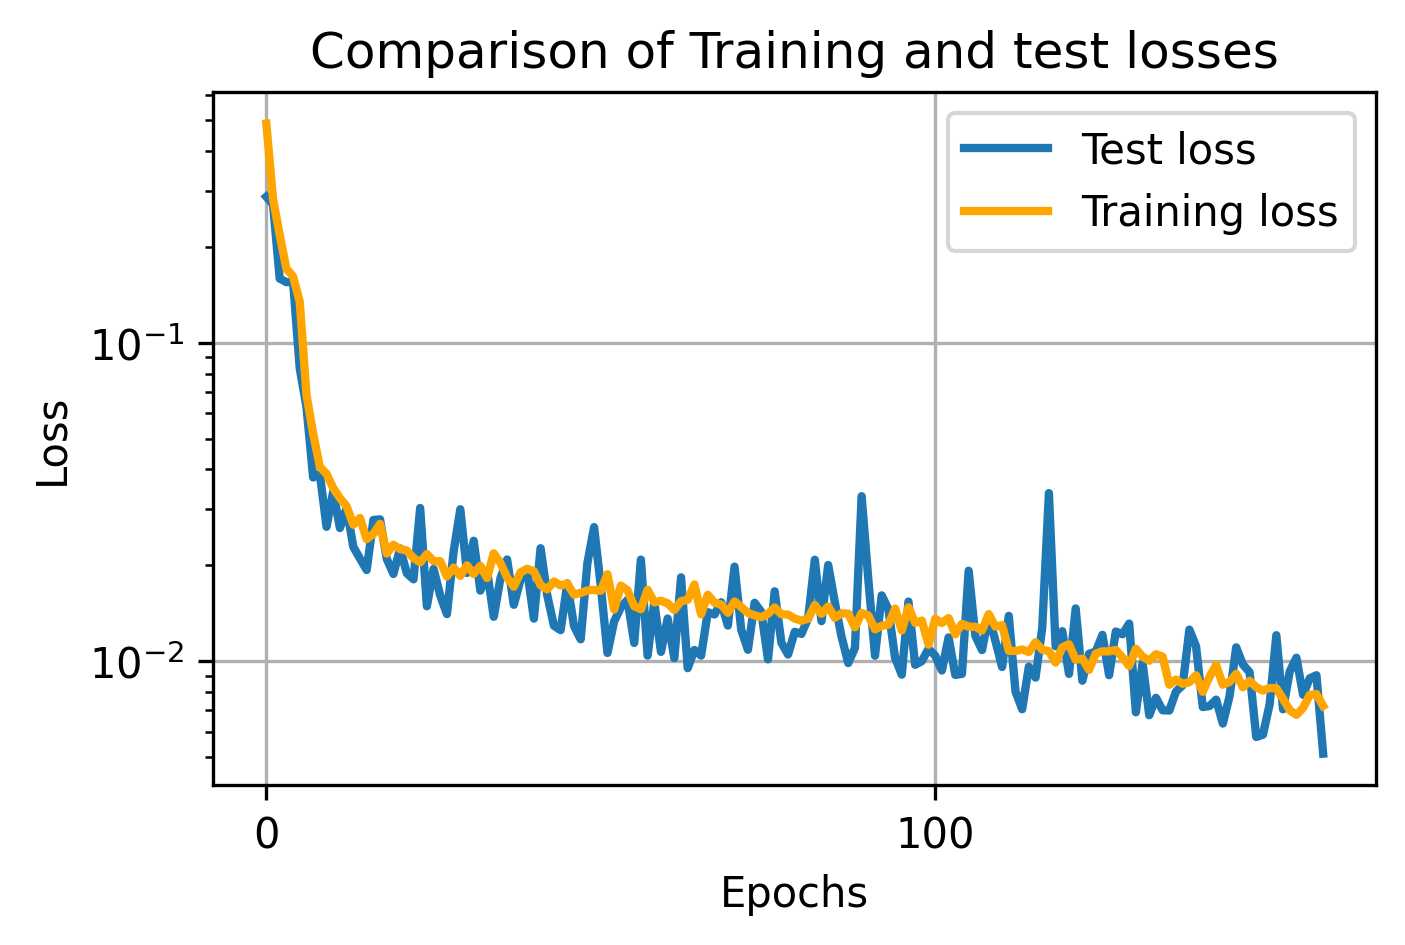

 17%|██████▍                               | 168/1000 [27:28<1:30:56,  6.56s/it]

Epoch:169 
 Training time for  epoch 169: 0.107 minutes,Training loss:  0.007417349445082747, Testing loss: 0.00758923583664


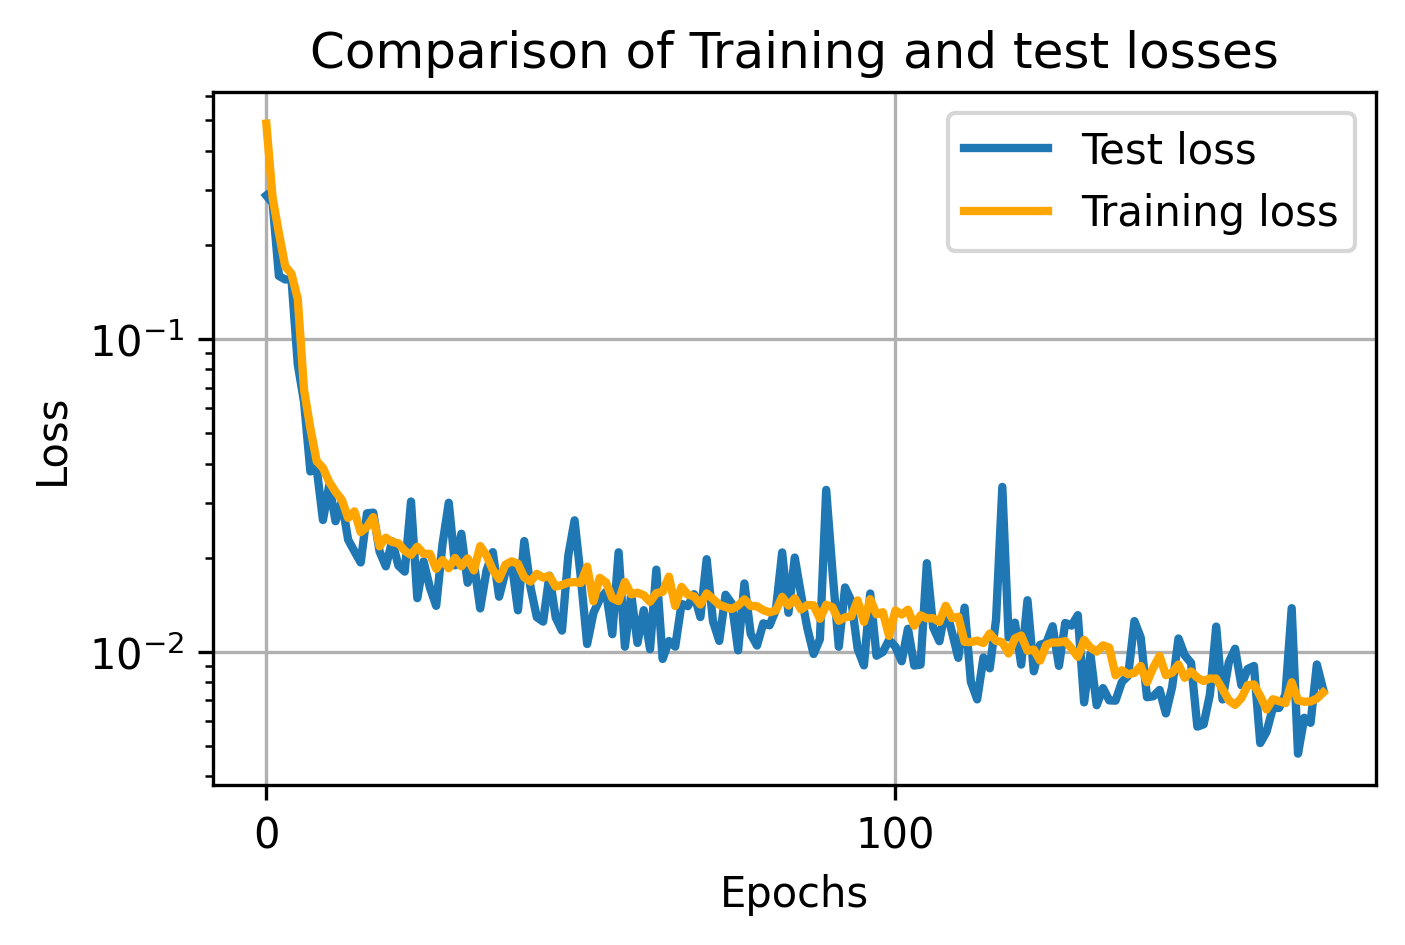

 17%|██████▍                               | 171/1000 [27:47<1:29:25,  6.47s/it]

Epoch 00171: reducing learning rate of group 0 to 4.0960e-04.


 18%|██████▊                               | 178/1000 [28:32<1:28:09,  6.43s/it]

Epoch:179 
 Training time for  epoch 179: 0.109 minutes,Training loss:  0.006305566605921585, Testing loss: 0.005103870825842023


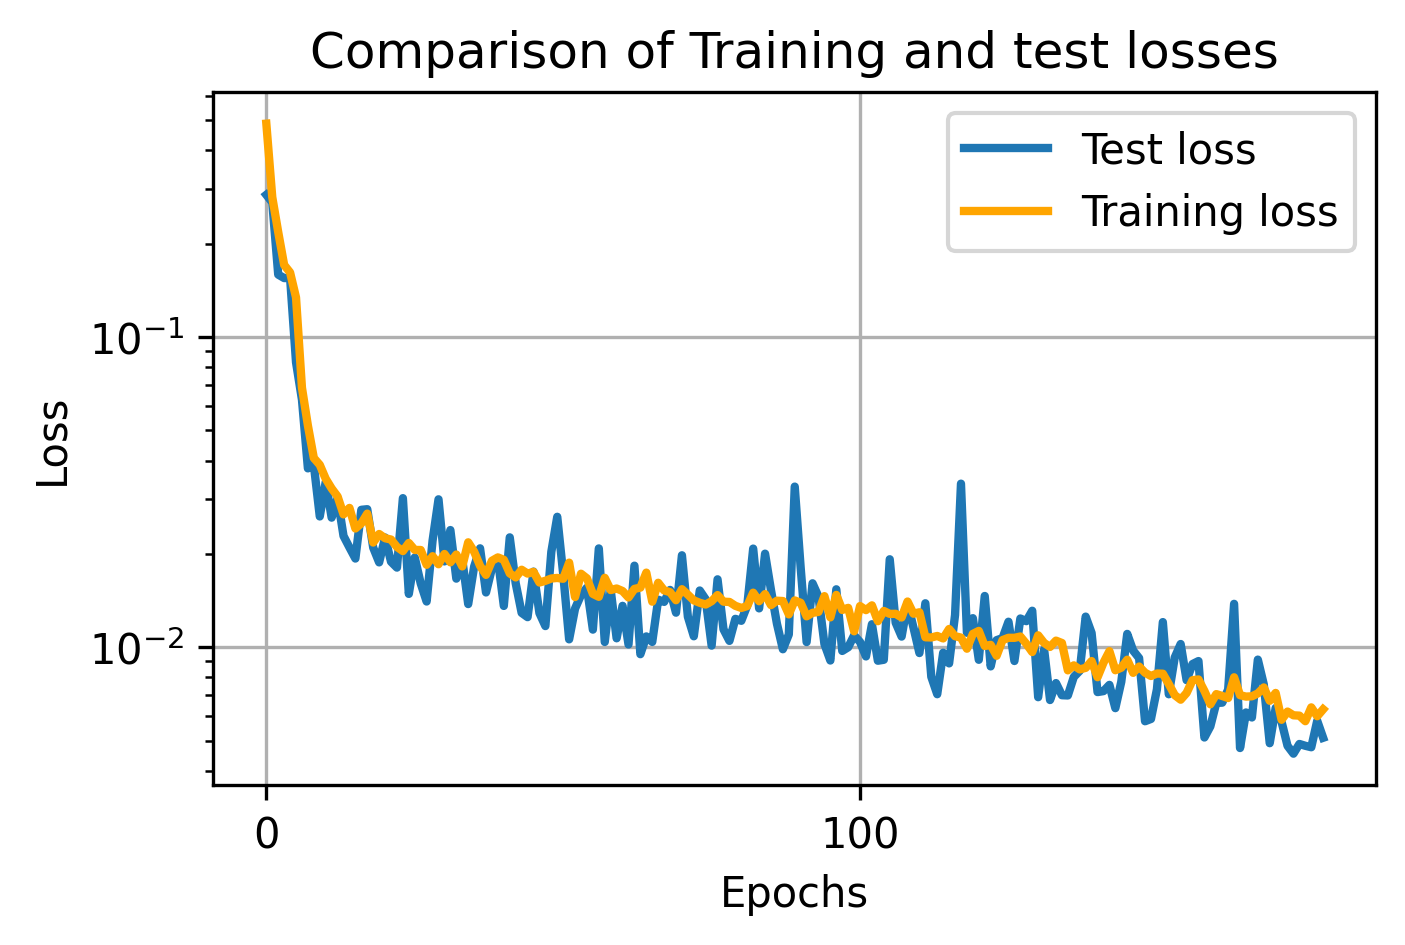

 19%|███████                               | 187/1000 [29:30<1:26:48,  6.41s/it]

Epoch 00187: reducing learning rate of group 0 to 3.2768e-04.


 19%|███████▏                              | 188/1000 [29:36<1:26:45,  6.41s/it]

Epoch:189 
 Training time for  epoch 189: 0.107 minutes,Training loss:  0.005249336330296767, Testing loss: 0.005061722369864583


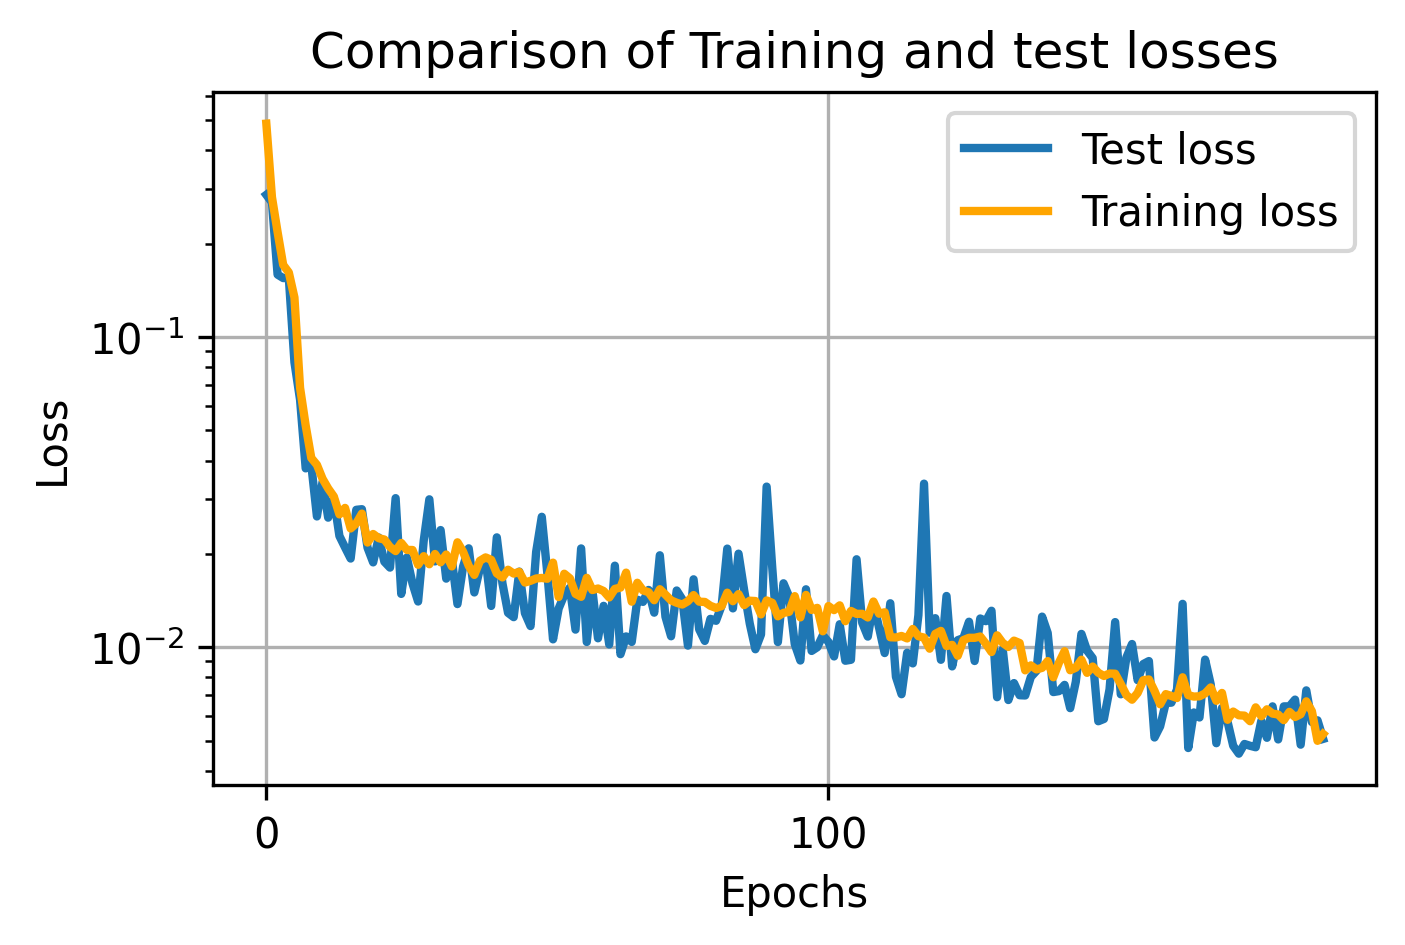

 20%|███████▌                              | 198/1000 [30:41<1:26:30,  6.47s/it]

Epoch 00199: reducing learning rate of group 0 to 2.6214e-04.
Epoch:199 
 Training time for  epoch 199: 0.106 minutes,Training loss:  0.005338959247881842, Testing loss: 0.004485362414270639


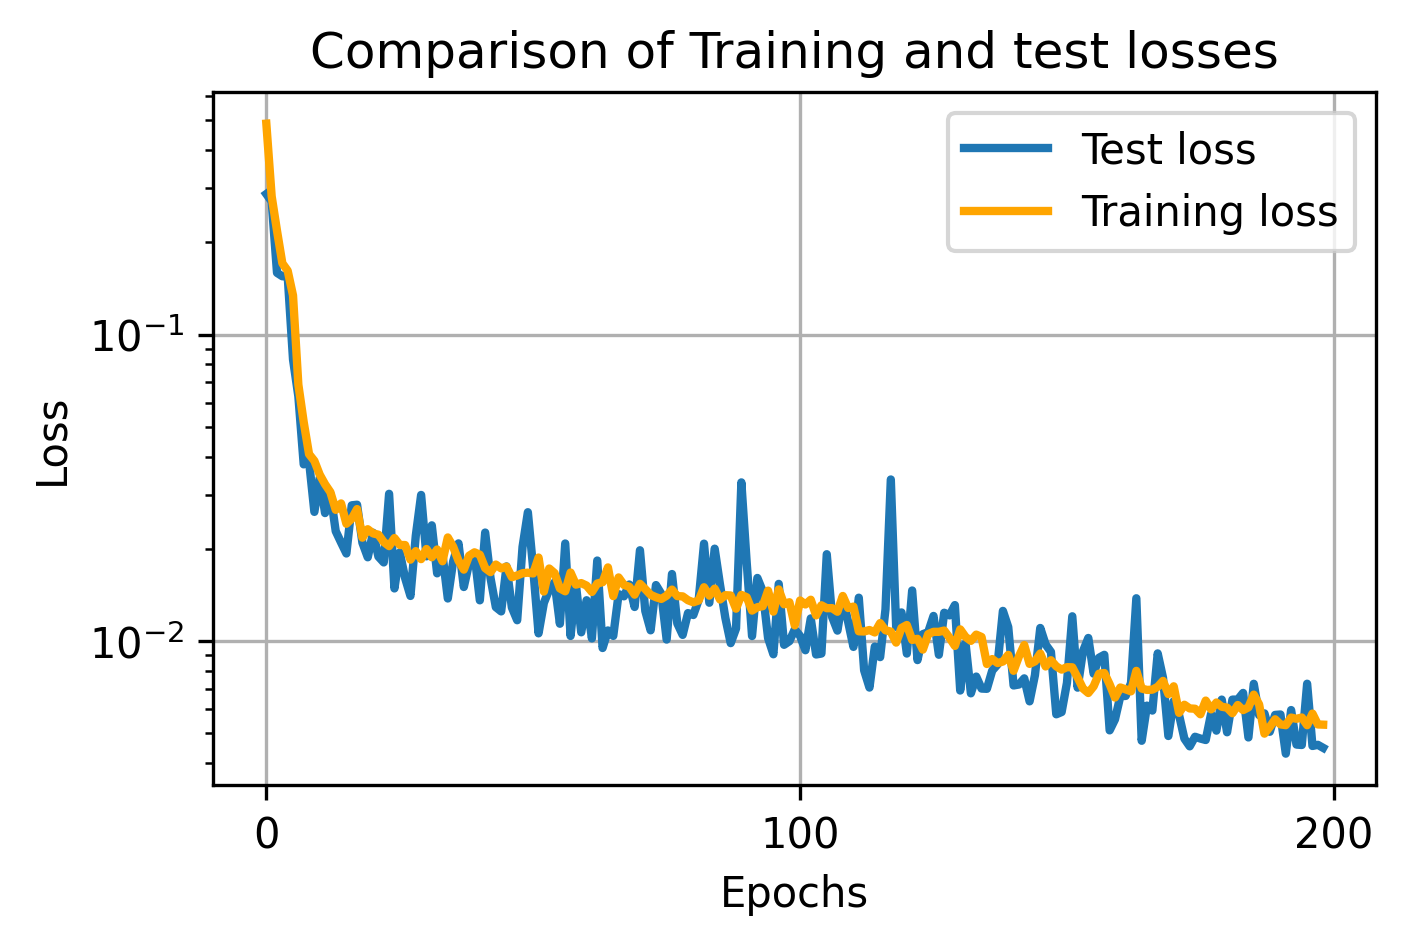

 21%|███████▉                              | 208/1000 [31:43<1:21:48,  6.20s/it]

Epoch:209 
 Training time for  epoch 209: 0.104 minutes,Training loss:  0.004788975626380728, Testing loss: 0.00426891322247684


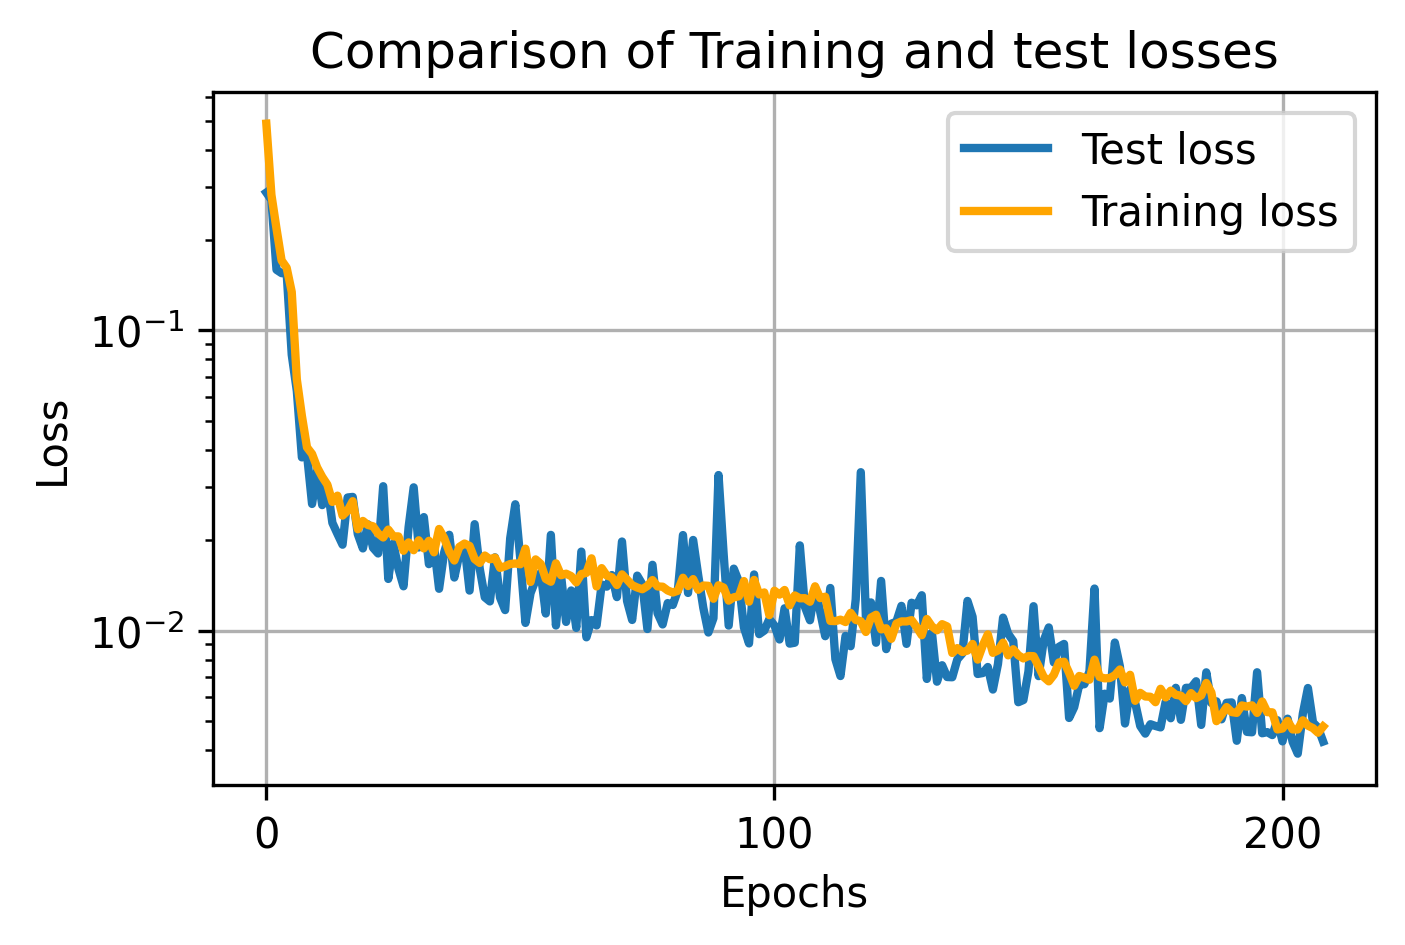

 22%|████████▎                             | 218/1000 [32:46<1:21:20,  6.24s/it]

Epoch:219 
 Training time for  epoch 219: 0.099 minutes,Training loss:  0.004558316040812515, Testing loss: 0.004087277334183455


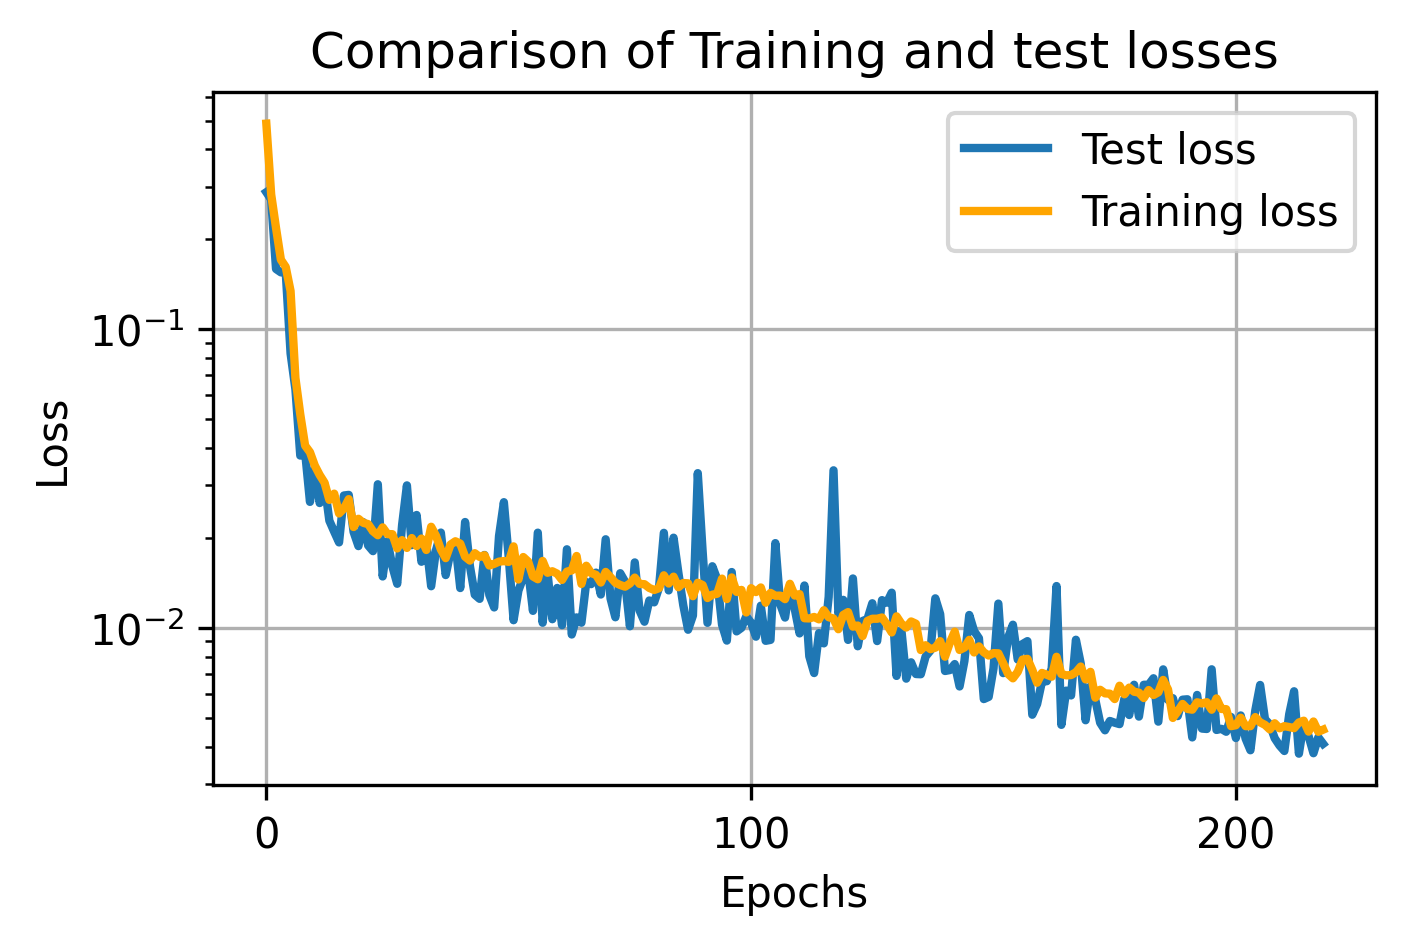

 23%|████████▋                             | 228/1000 [33:49<1:21:33,  6.34s/it]

Epoch:229 
 Training time for  epoch 229: 0.094 minutes,Training loss:  0.004730904281775399, Testing loss: 0.0037602887442335486


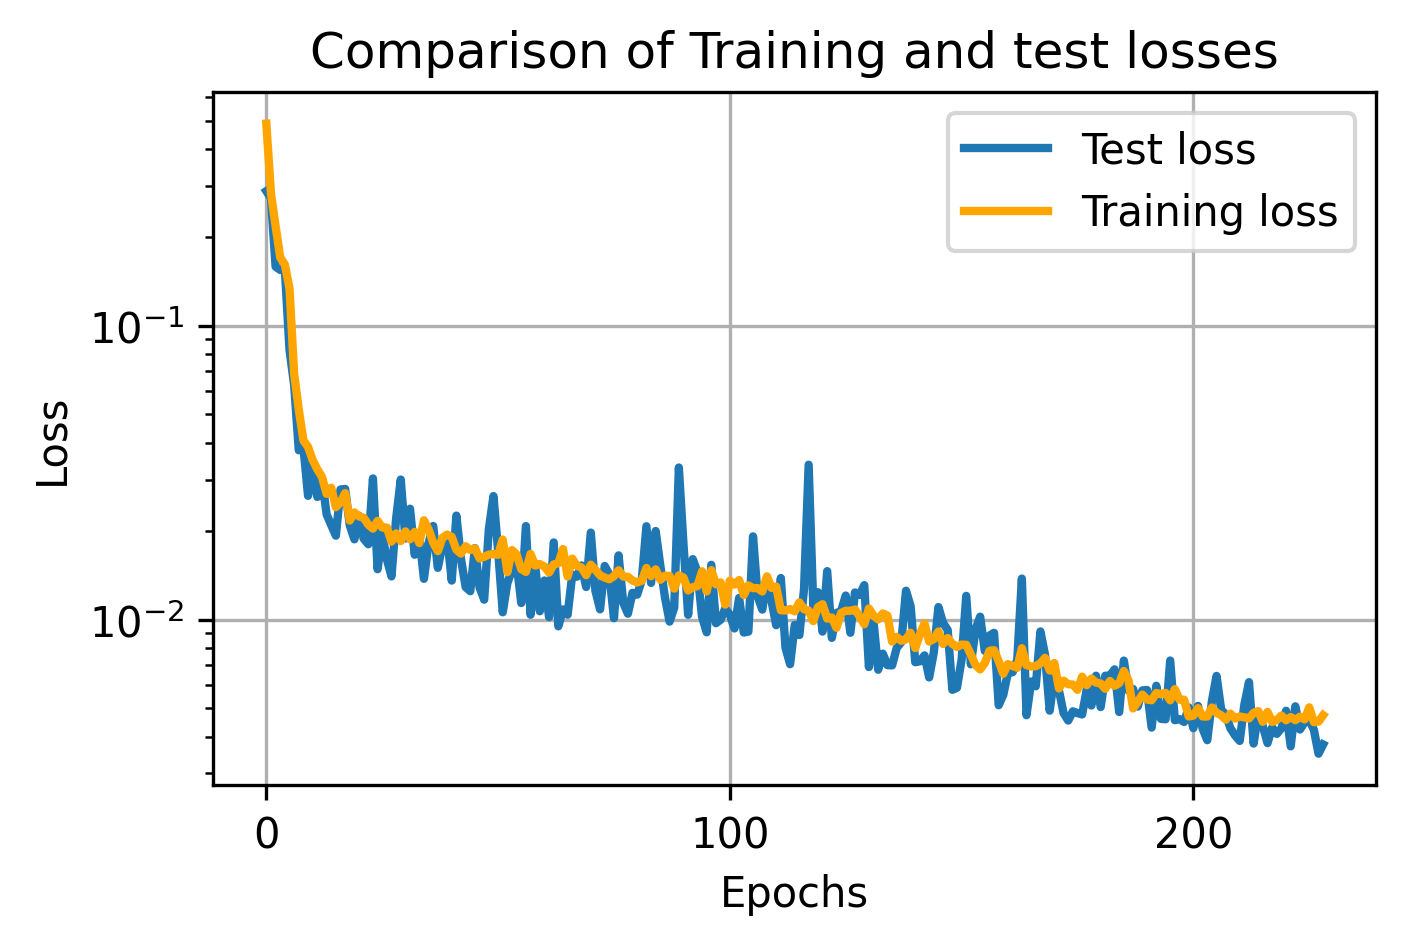

 24%|█████████                             | 238/1000 [34:53<1:21:02,  6.38s/it]

Epoch:239 
 Training time for  epoch 239: 0.106 minutes,Training loss:  0.0050510008008043256, Testing loss: 0.003669280814938247


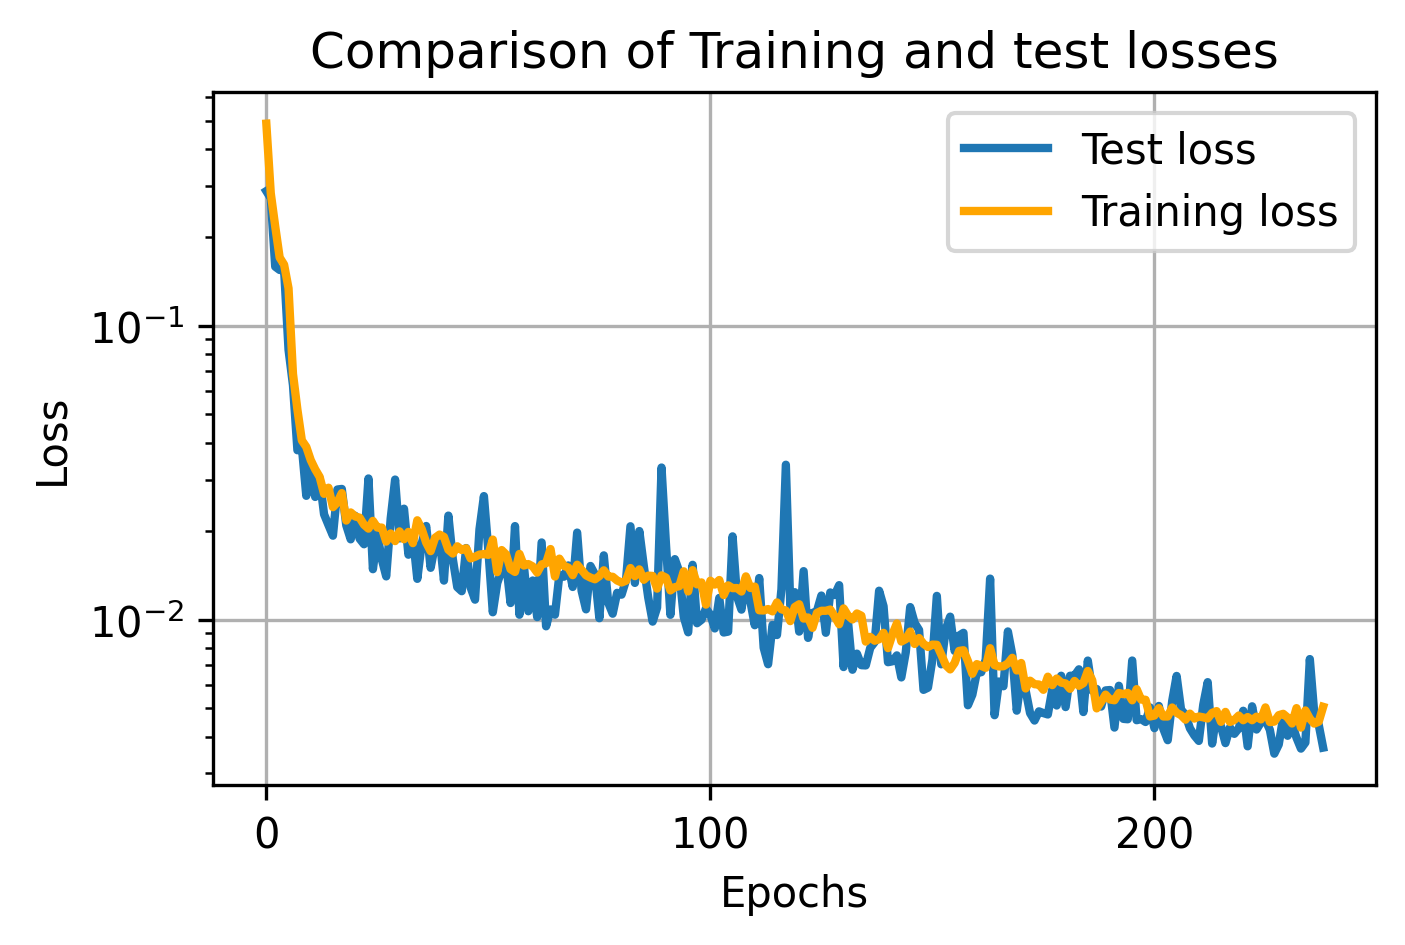

 24%|█████████▎                            | 244/1000 [35:36<1:29:54,  7.14s/it]

Epoch 00245: reducing learning rate of group 0 to 2.0972e-04.


 25%|█████████▍                            | 248/1000 [36:16<1:55:28,  9.21s/it]

Epoch:249 
 Training time for  epoch 249: 0.168 minutes,Training loss:  0.004109264090202931, Testing loss: 0.003370897942222655


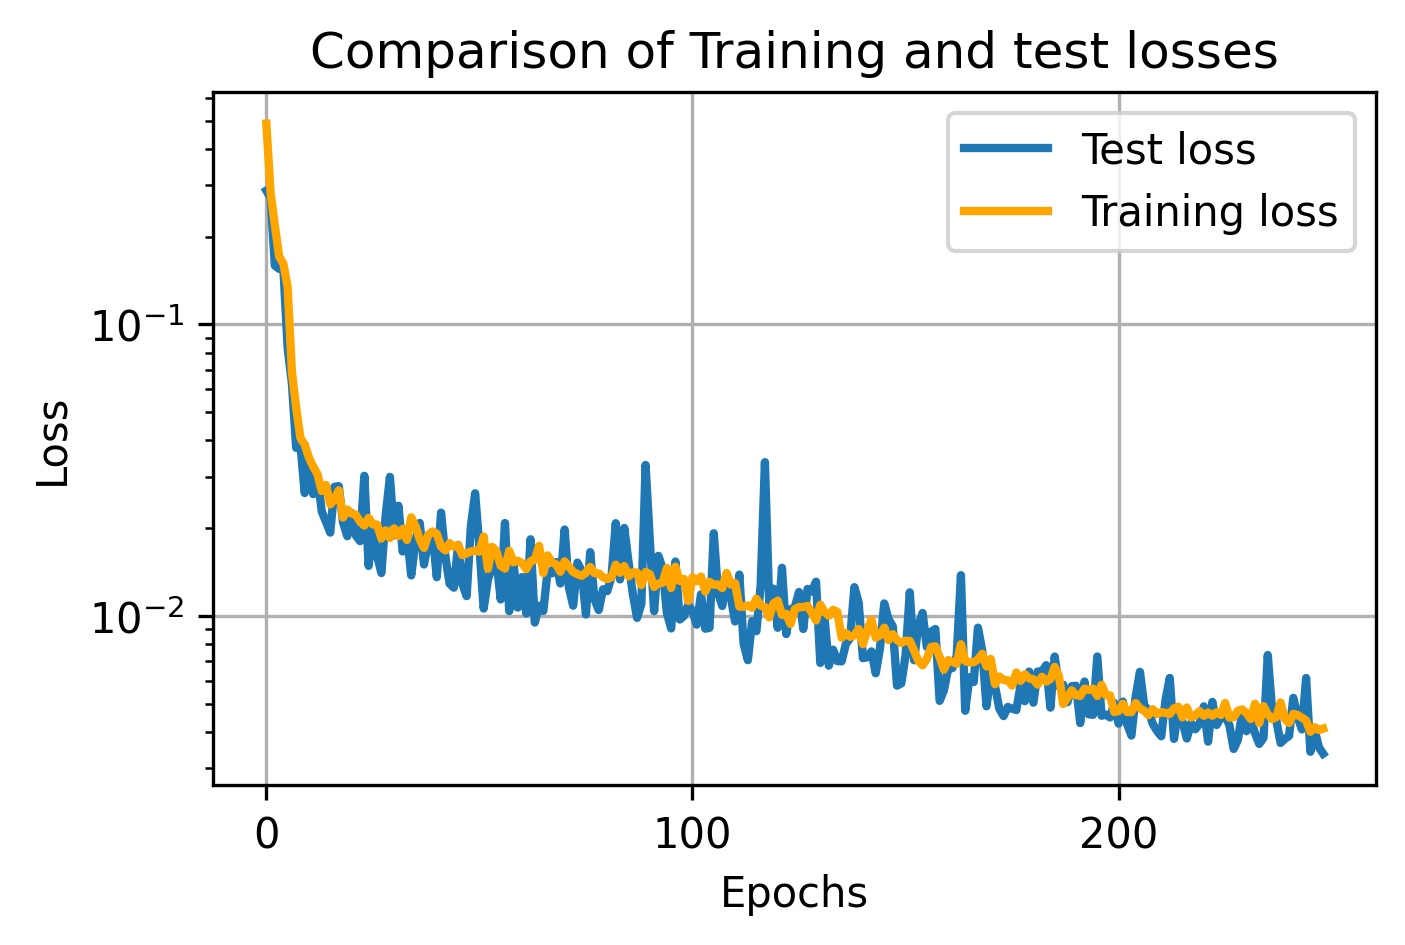

 26%|█████████▊                            | 258/1000 [38:00<2:08:58, 10.43s/it]

Epoch:259 
 Training time for  epoch 259: 0.176 minutes,Training loss:  0.003917582210993803, Testing loss: 0.003334508640691638


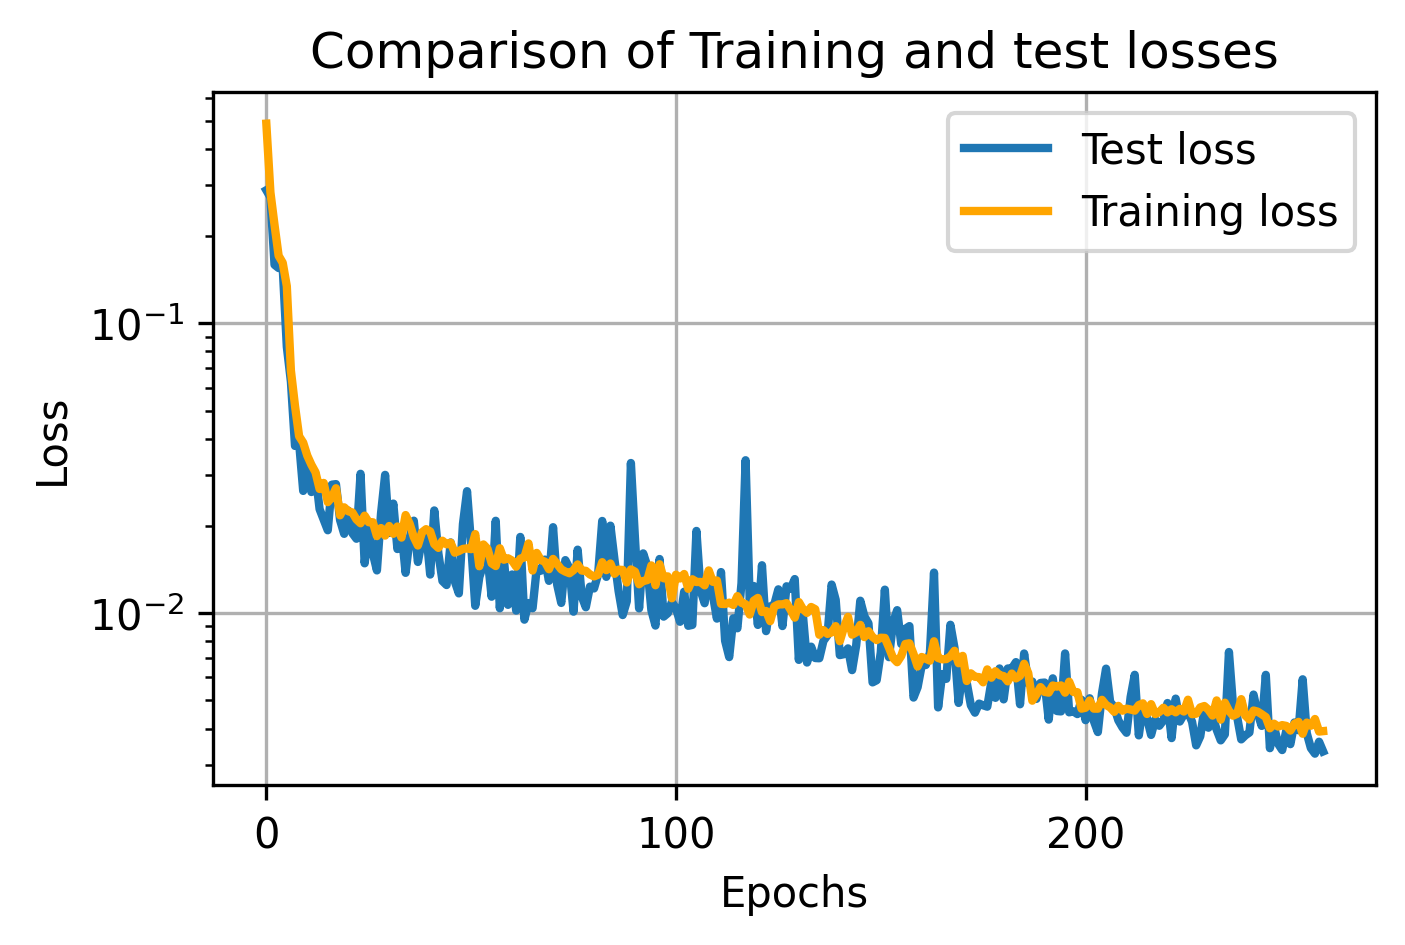

 27%|██████████▏                           | 268/1000 [39:35<1:42:24,  8.39s/it]

Epoch:269 
 Training time for  epoch 269: 0.171 minutes,Training loss:  0.004117415073645733, Testing loss: 0.004135868567973375


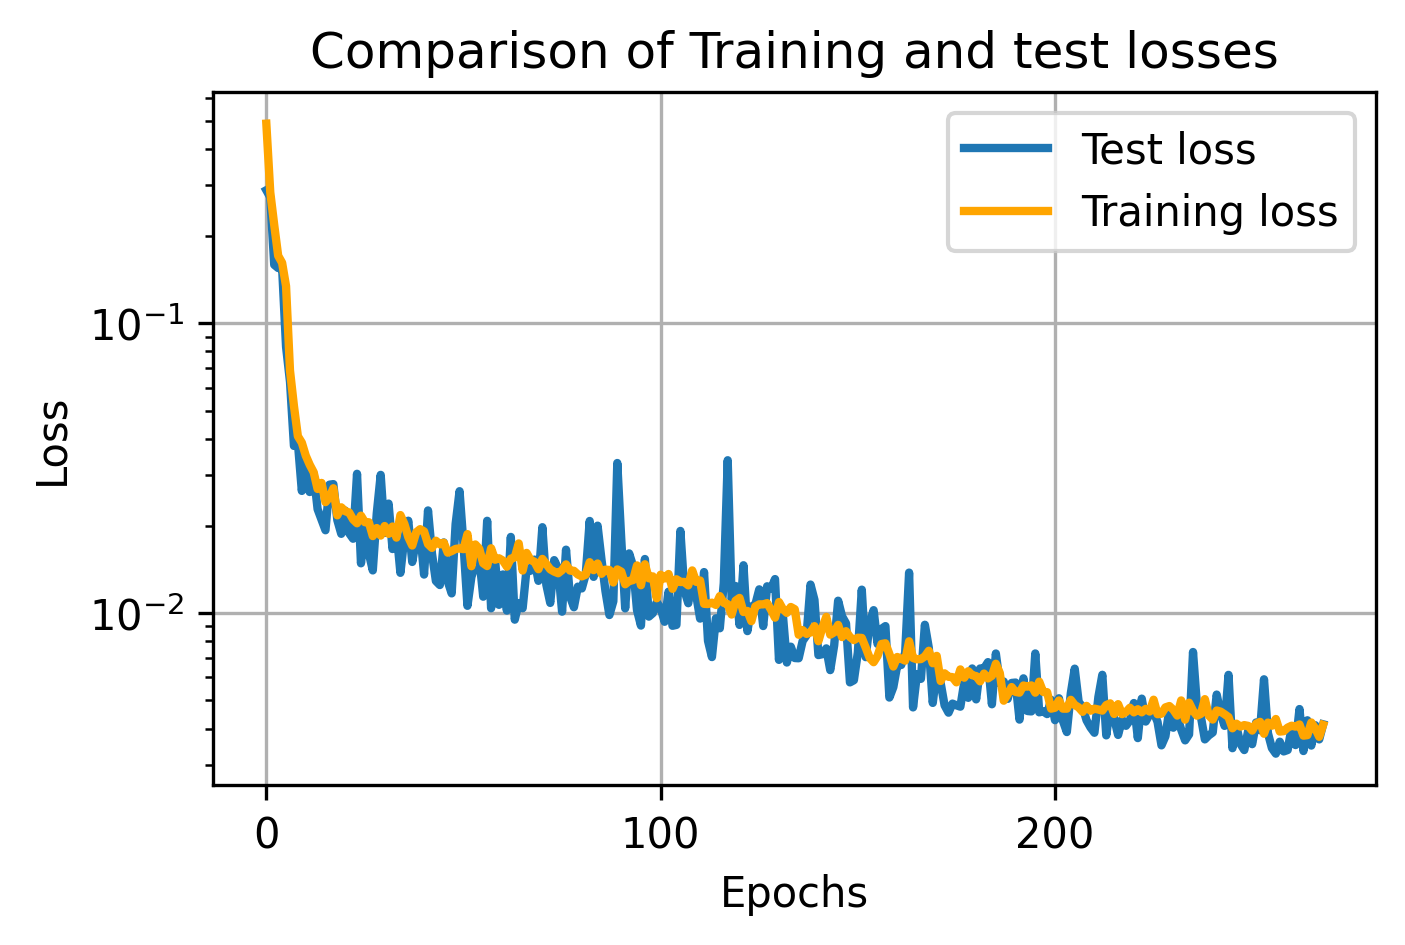

 28%|██████████▌                           | 278/1000 [41:11<2:03:35, 10.27s/it]

Epoch:279 
 Training time for  epoch 279: 0.18 minutes,Training loss:  0.003959858836890085, Testing loss: 0.005321367243304849


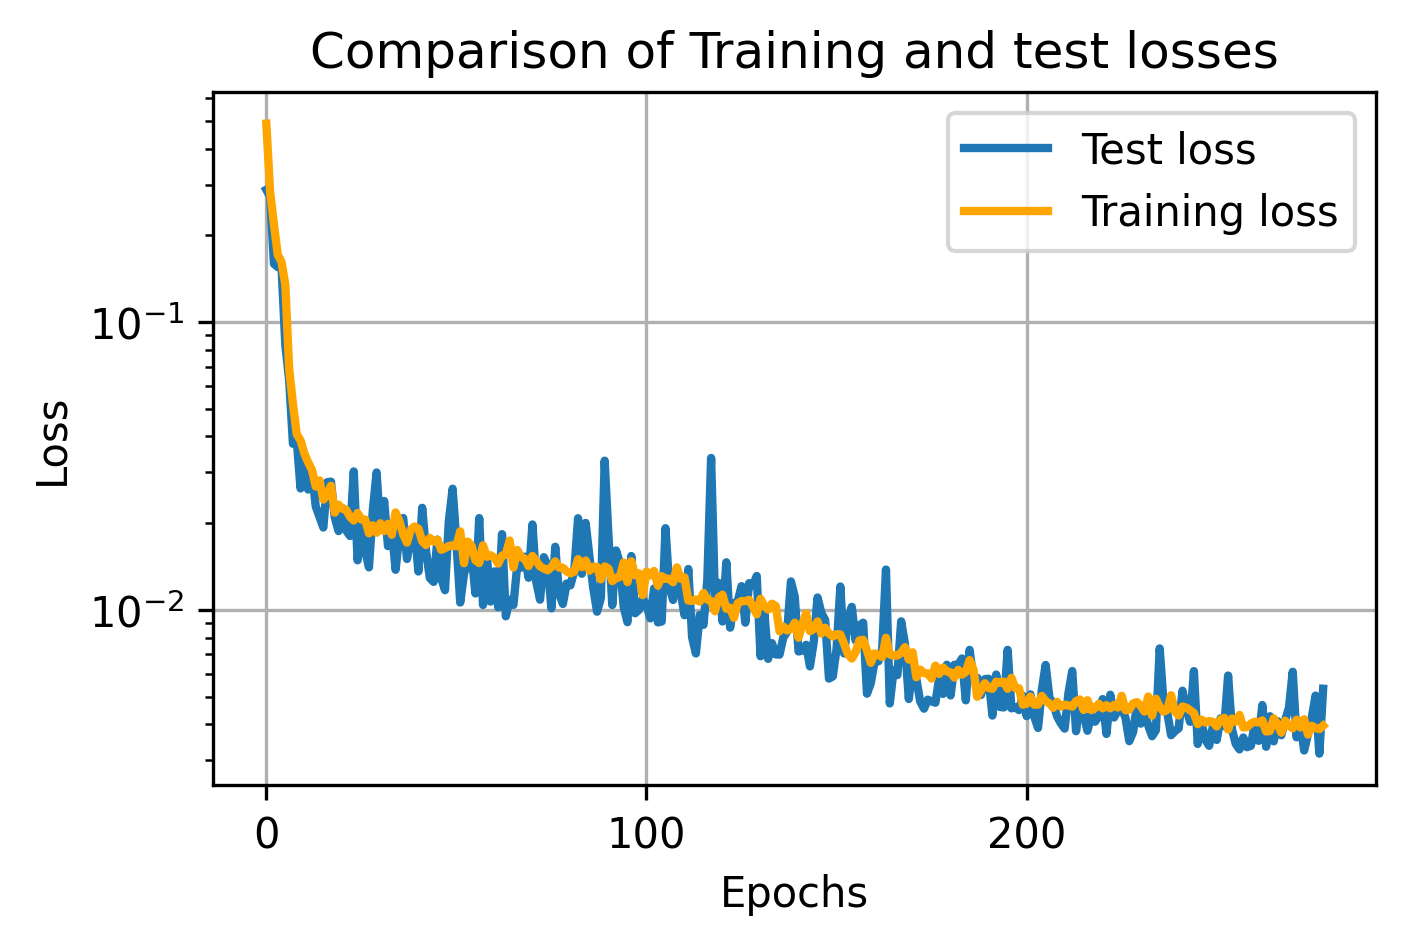

 28%|██████████▊                           | 285/1000 [42:26<2:05:43, 10.55s/it]

Epoch 00286: reducing learning rate of group 0 to 1.6777e-04.


 29%|██████████▉                           | 288/1000 [42:57<2:03:09, 10.38s/it]

Epoch:289 
 Training time for  epoch 289: 0.151 minutes,Training loss:  0.003436908084706108, Testing loss: 0.0033448985638096927


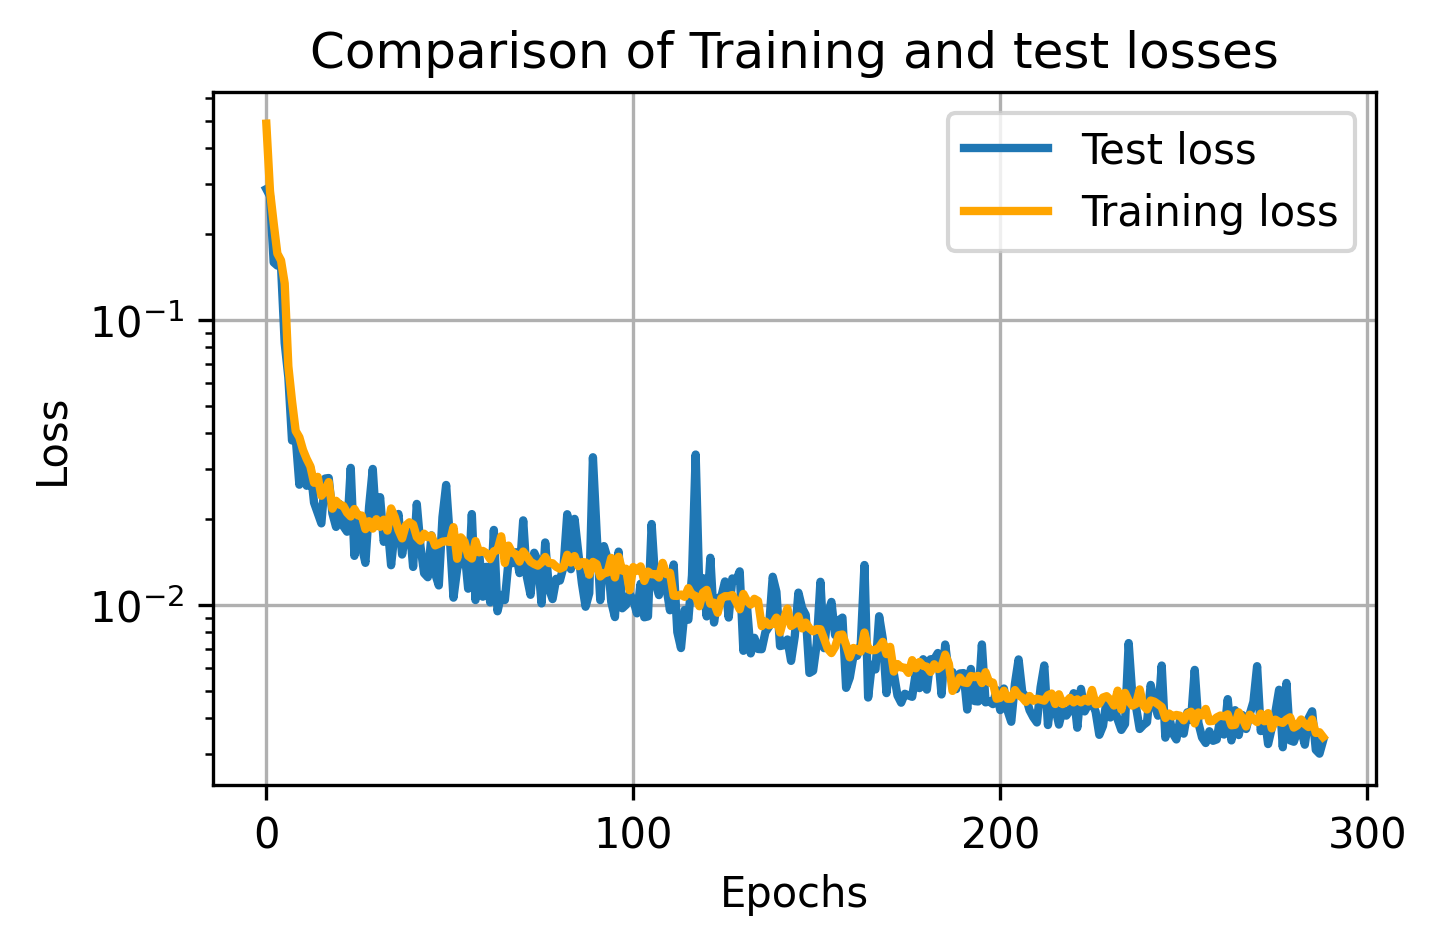

 30%|███████████▎                          | 298/1000 [44:40<1:59:52, 10.25s/it]

Epoch:299 
 Training time for  epoch 299: 0.178 minutes,Training loss:  0.003531236422287936, Testing loss: 0.0037234448408707977


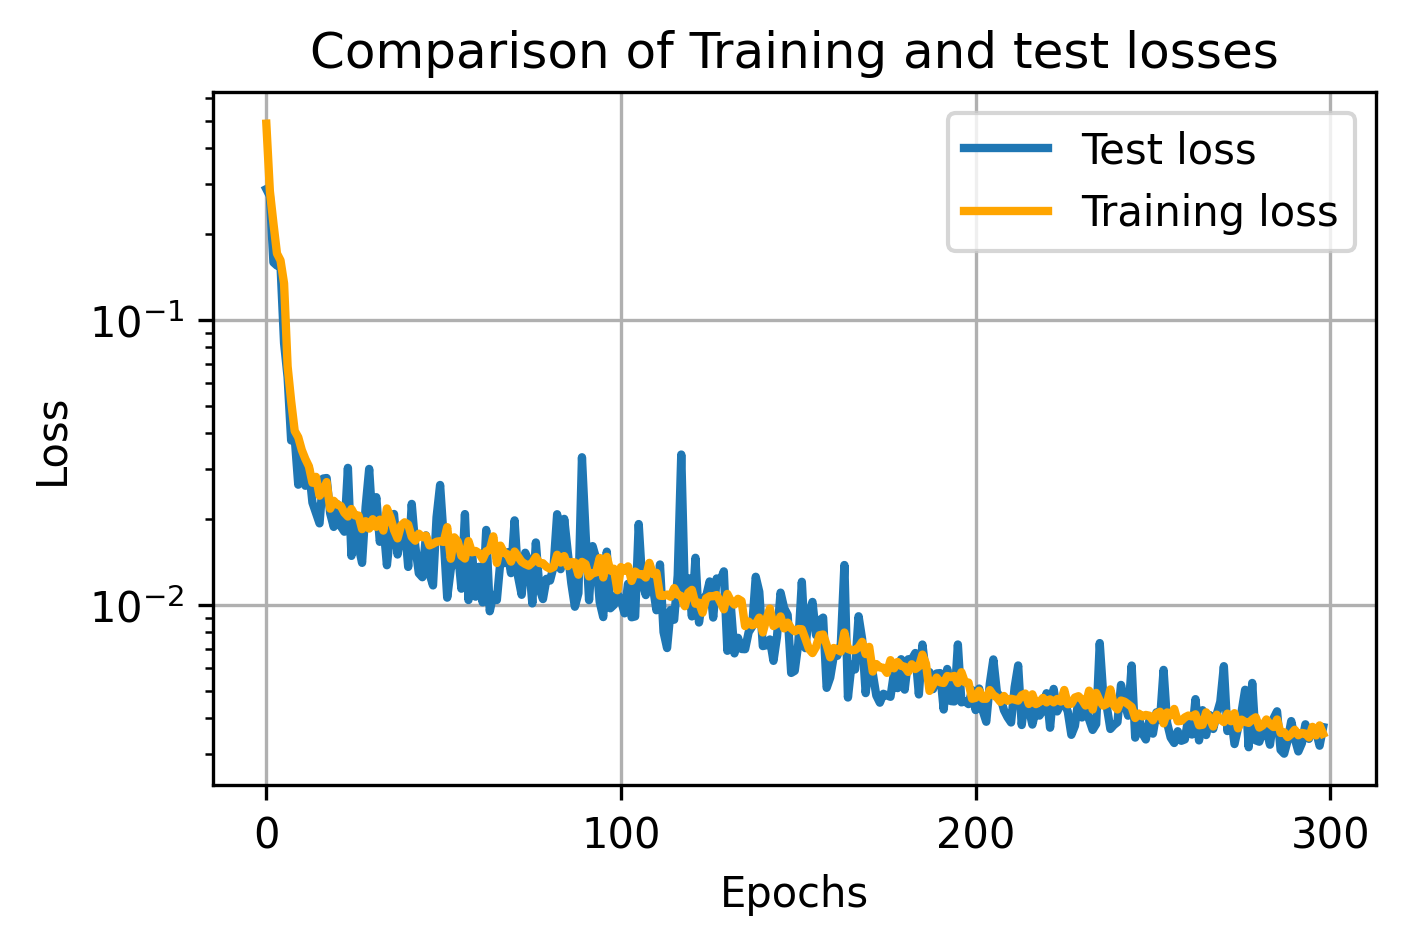

 31%|███████████▋                          | 308/1000 [46:17<1:34:42,  8.21s/it]

Epoch:309 
 Training time for  epoch 309: 0.105 minutes,Training loss:  0.00334838951835636, Testing loss: 0.0030401589069515467


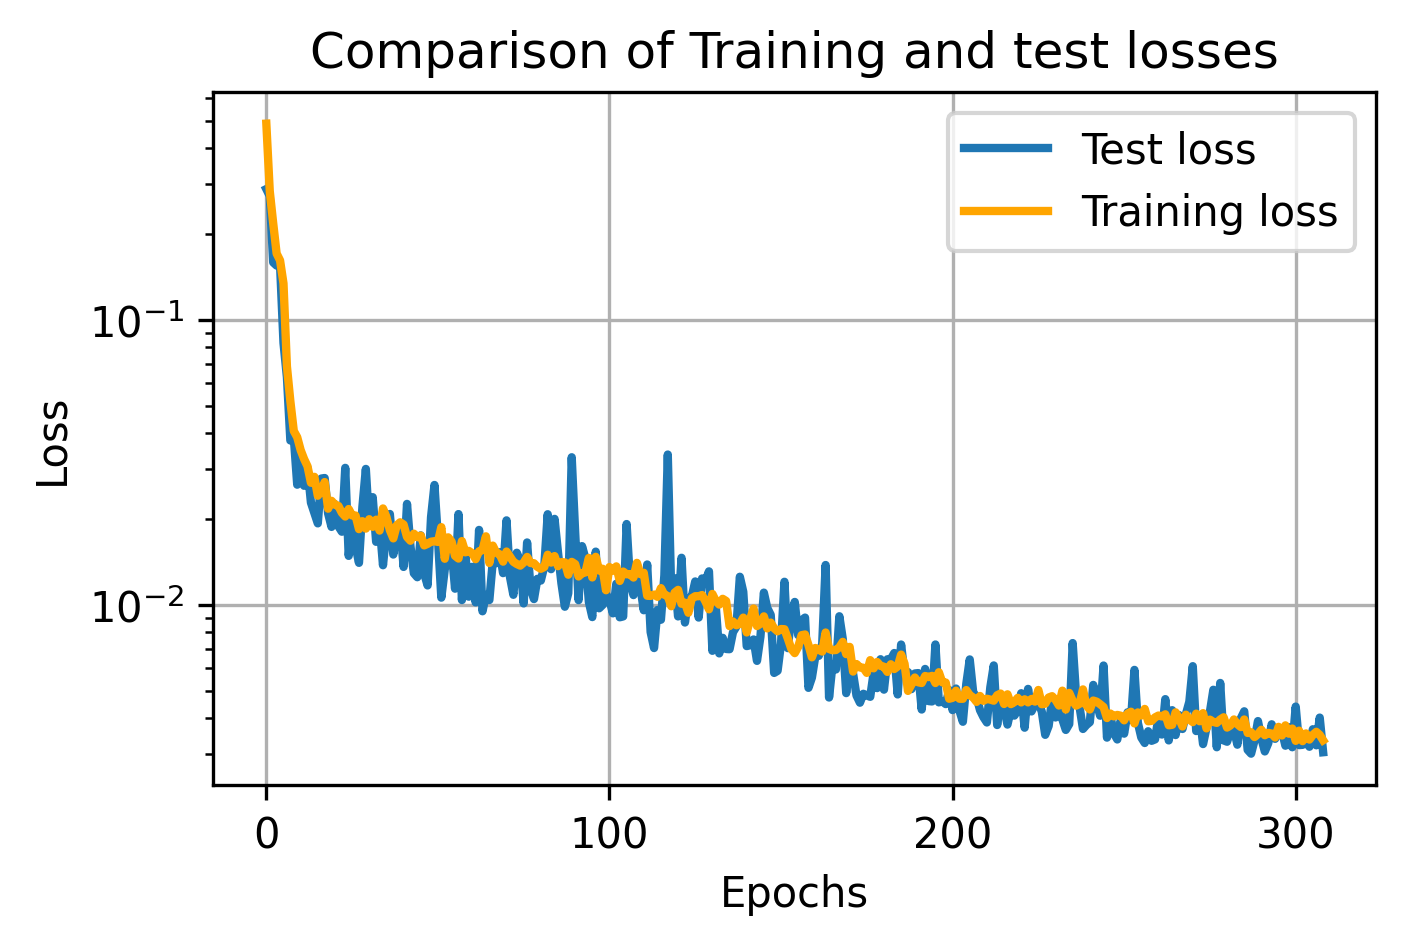

 32%|████████████                          | 318/1000 [47:28<1:20:02,  7.04s/it]

Epoch:319 
 Training time for  epoch 319: 0.141 minutes,Training loss:  0.003351429978487786, Testing loss: 0.0035869972826913


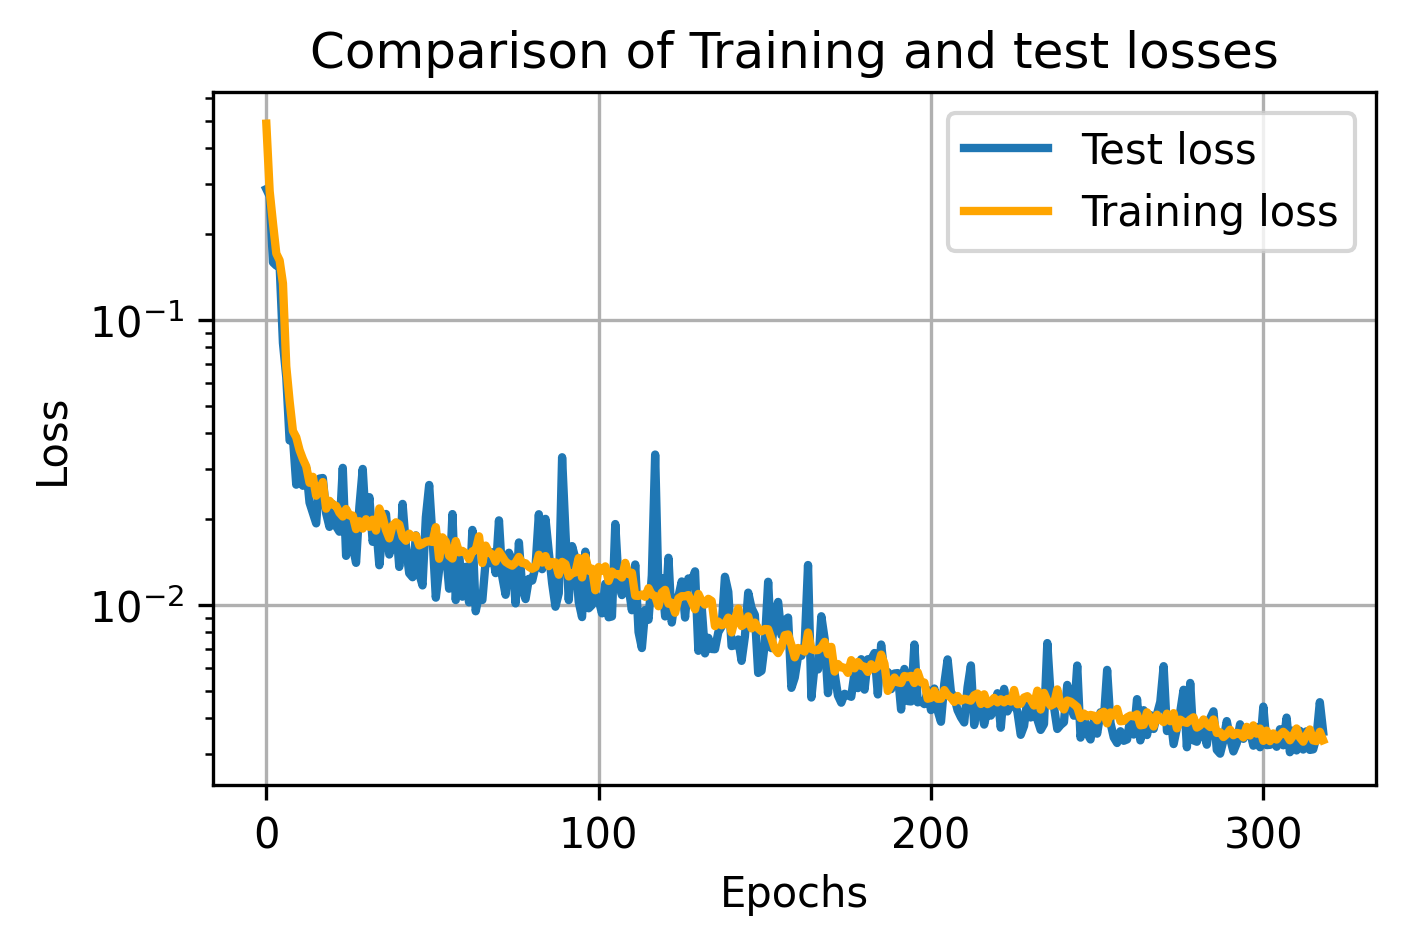

 32%|████████████▎                         | 324/1000 [48:11<1:16:44,  6.81s/it]

Epoch 00324: reducing learning rate of group 0 to 1.3422e-04.


 33%|████████████▍                         | 328/1000 [48:37<1:12:57,  6.51s/it]

Epoch:329 
 Training time for  epoch 329: 0.107 minutes,Training loss:  0.003197051932546878, Testing loss: 0.0035824315715581177


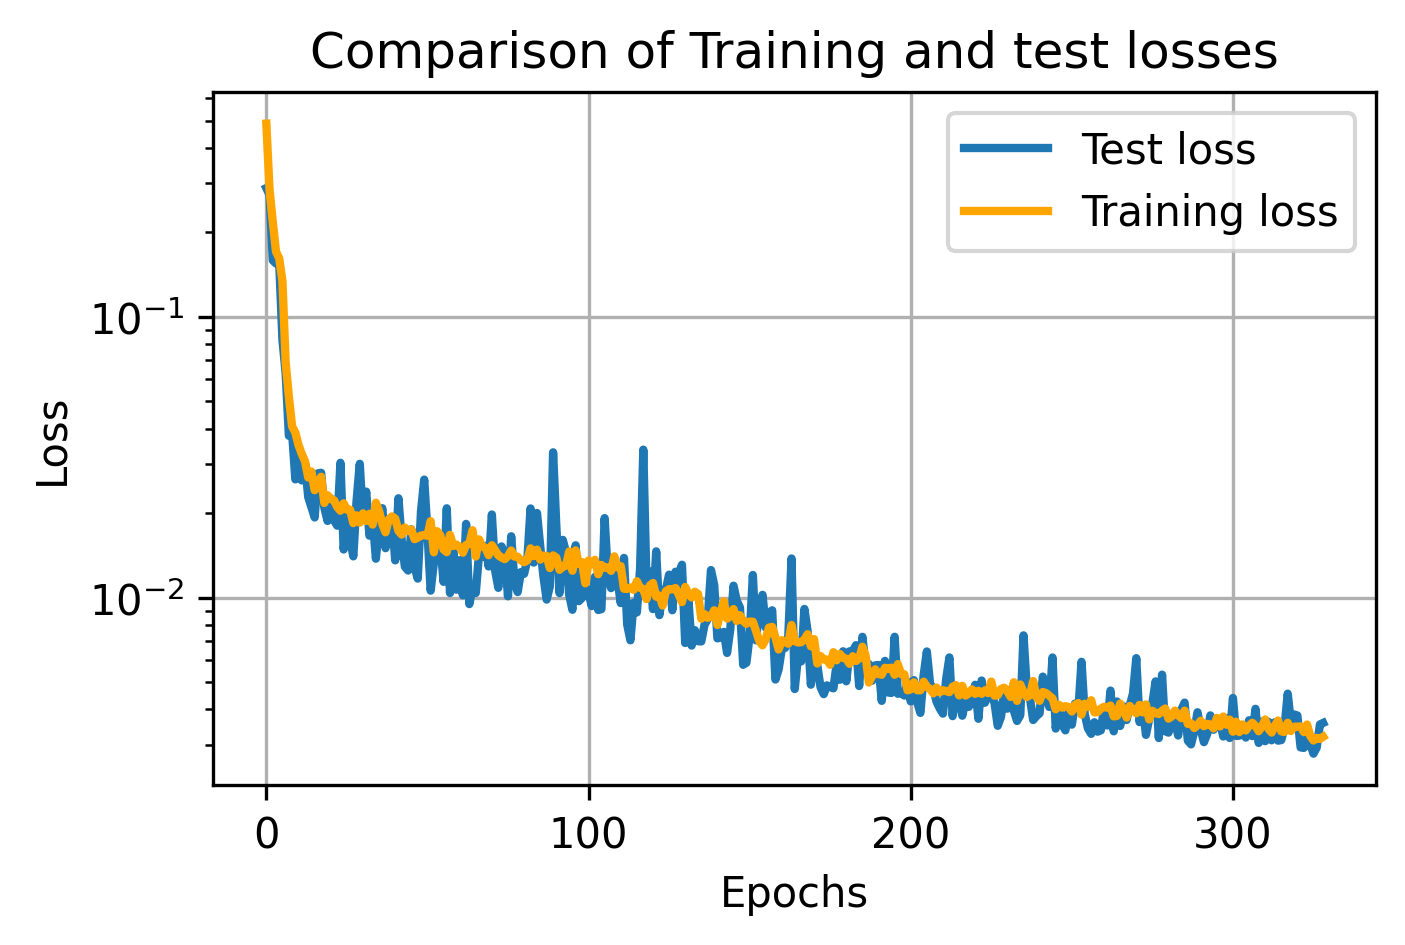

 34%|████████████▊                         | 338/1000 [49:41<1:10:24,  6.38s/it]

Epoch:339 
 Training time for  epoch 339: 0.105 minutes,Training loss:  0.0032868657130520882, Testing loss: 0.0028125868923962118


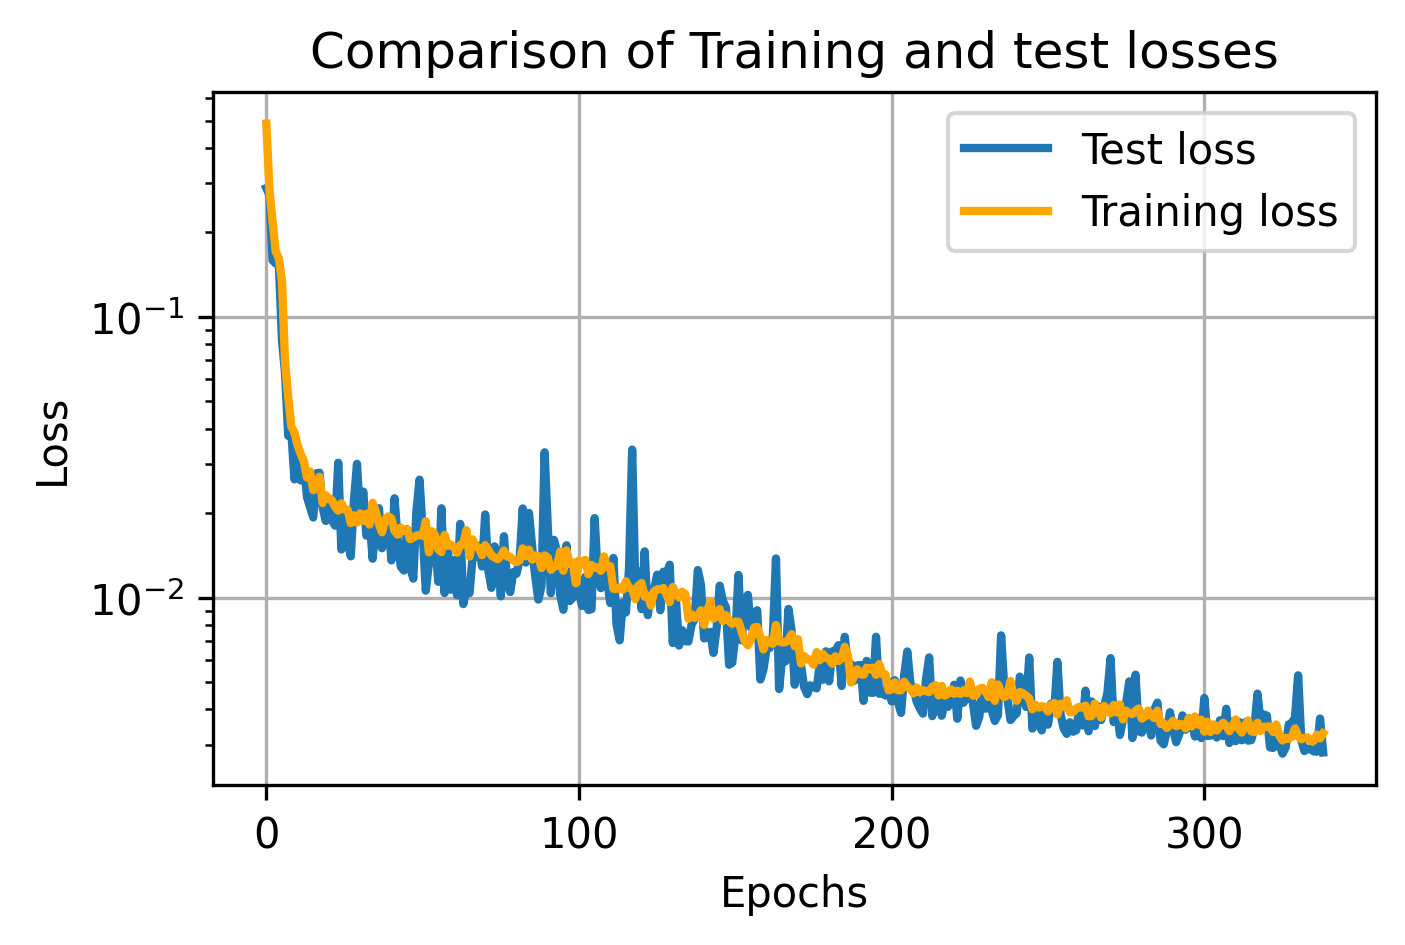

 35%|█████████████▏                        | 348/1000 [50:45<1:10:15,  6.46s/it]

Epoch:349 
 Training time for  epoch 349: 0.105 minutes,Training loss:  0.003148845880343465, Testing loss: 0.0029030916979536415


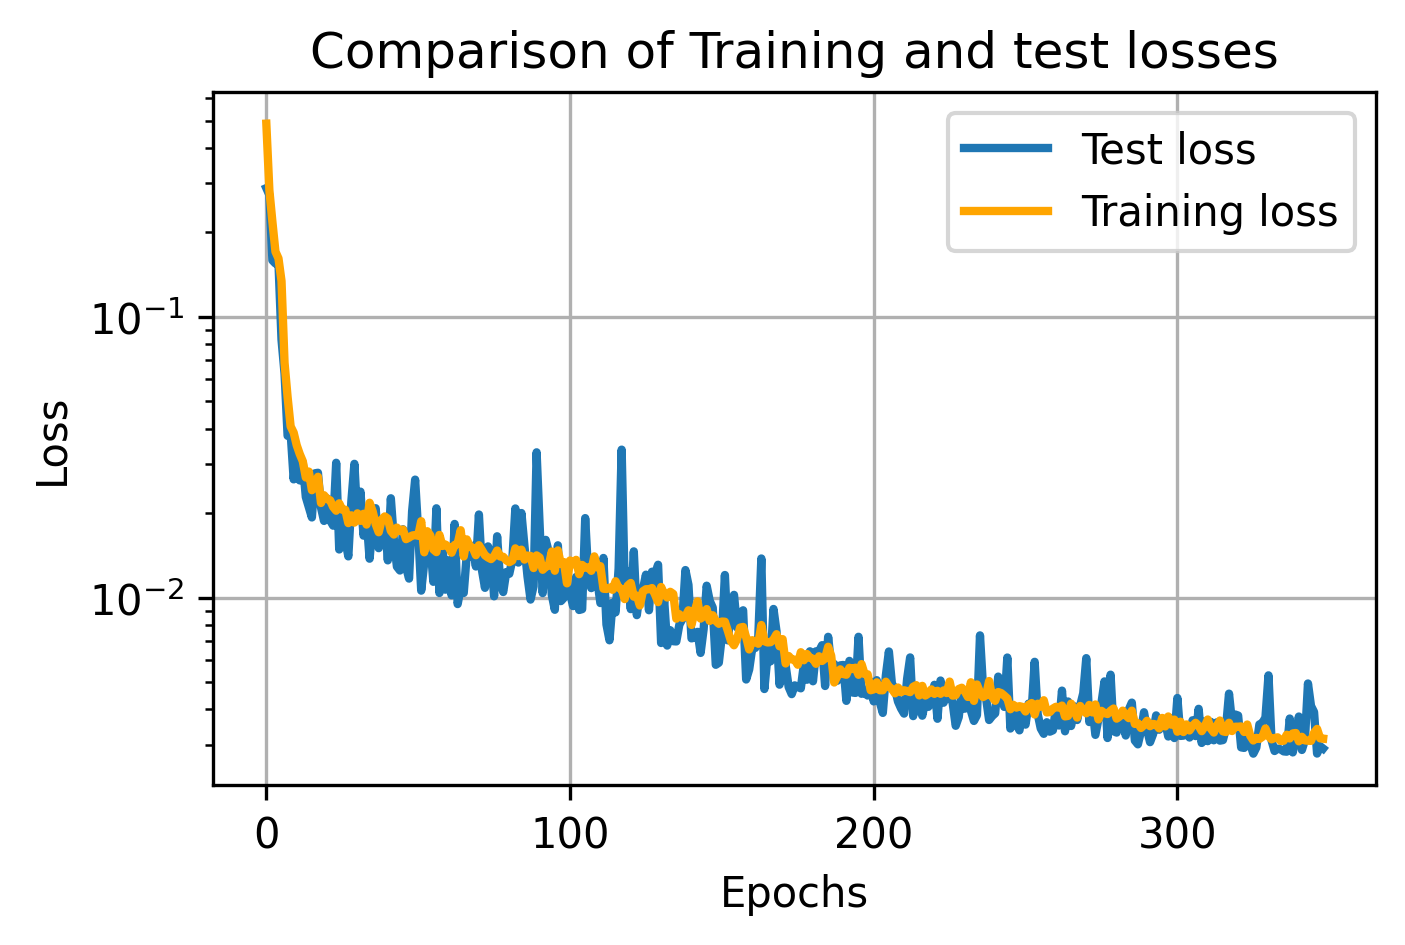

 36%|█████████████▌                        | 358/1000 [51:50<1:08:46,  6.43s/it]

Epoch:359 
 Training time for  epoch 359: 0.107 minutes,Training loss:  0.00307361309440727, Testing loss: 0.002706025317311287


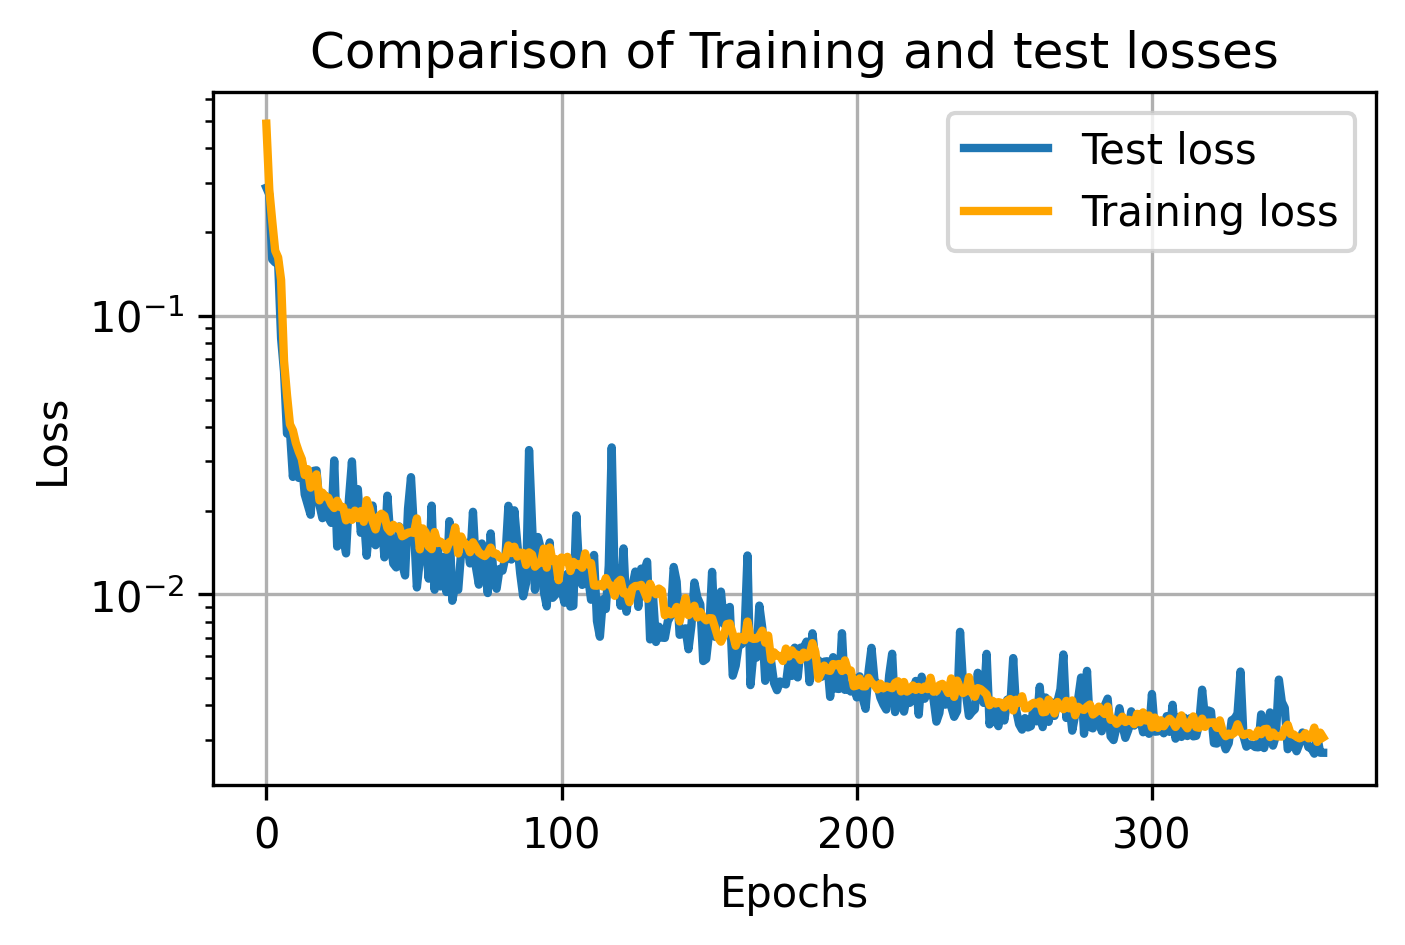

 37%|█████████████▉                        | 368/1000 [52:54<1:07:52,  6.44s/it]

Epoch 00368: reducing learning rate of group 0 to 1.0737e-04.
Epoch:369 
 Training time for  epoch 369: 0.108 minutes,Training loss:  0.002867573025358114, Testing loss: 0.002645420511253178


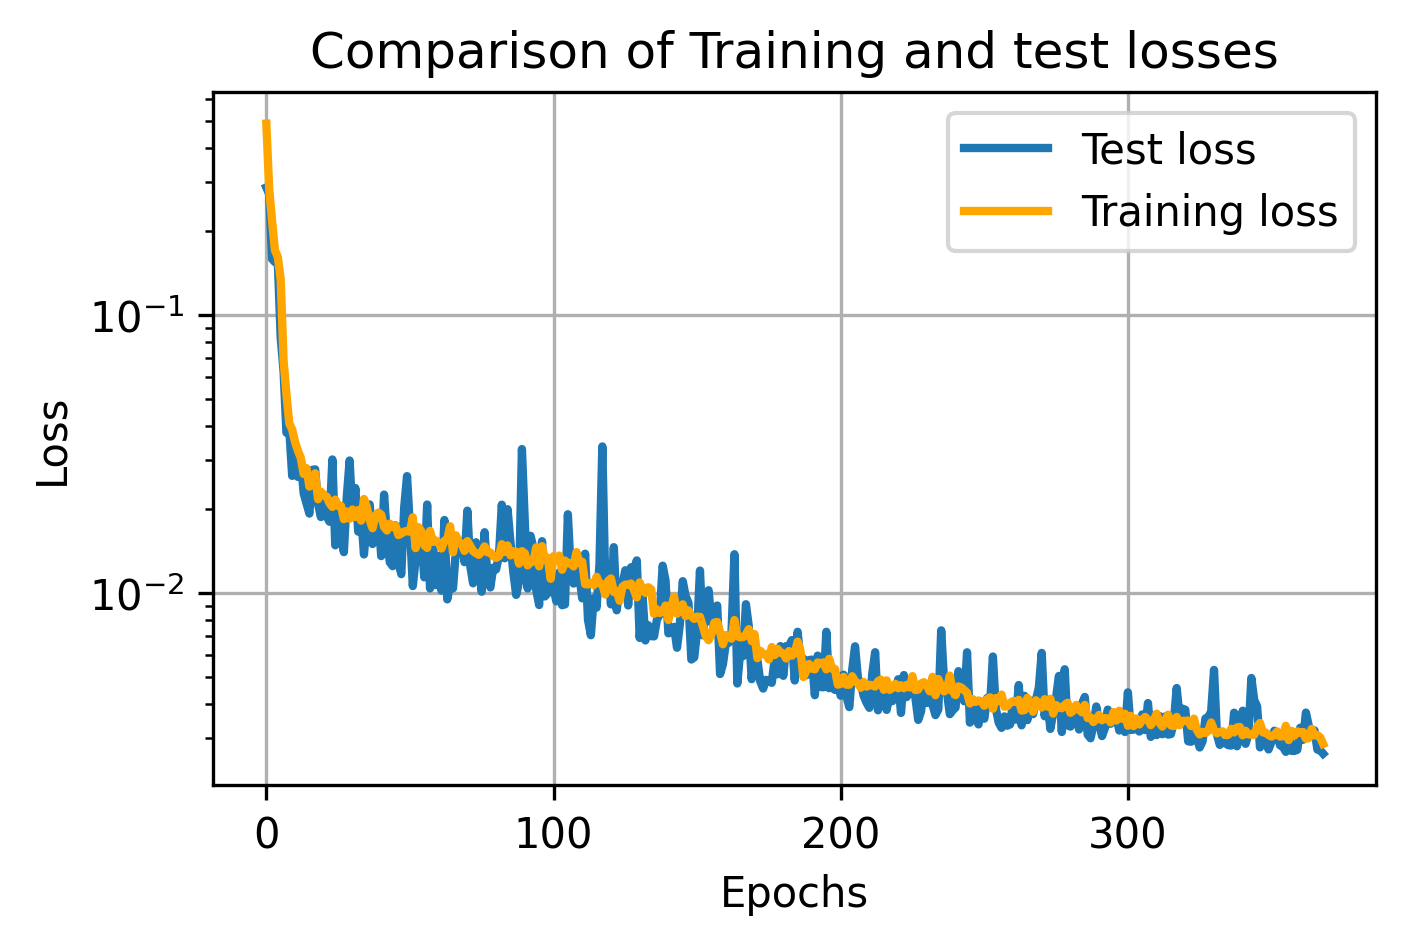

 38%|██████████████▎                       | 378/1000 [53:59<1:07:08,  6.48s/it]

Epoch:379 
 Training time for  epoch 379: 0.116 minutes,Training loss:  0.002963564657853212, Testing loss: 0.00260257912799716


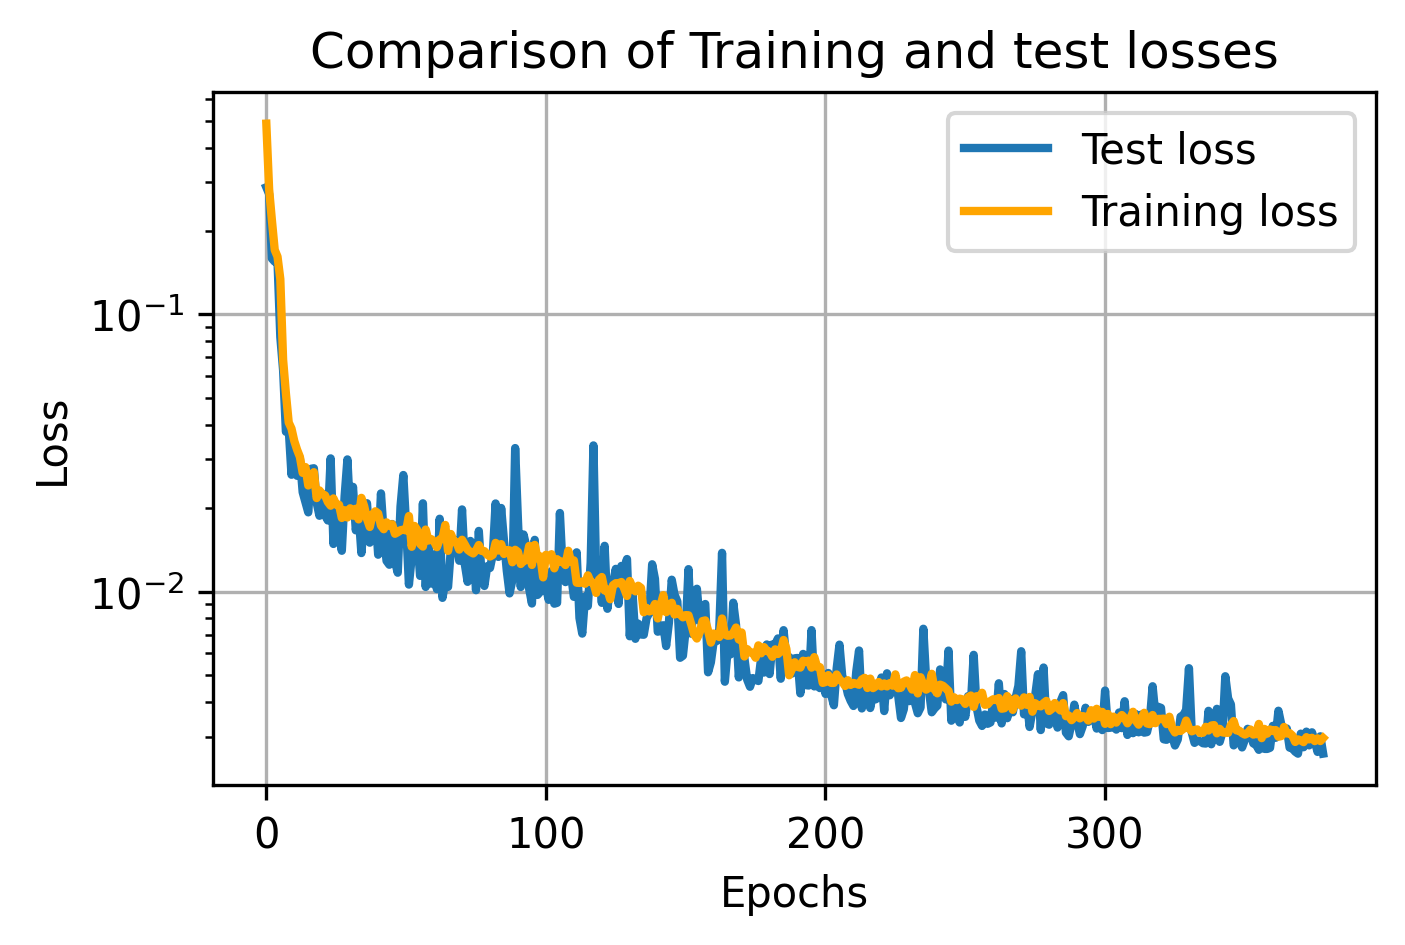

 38%|██████████████▌                       | 382/1000 [54:27<1:08:36,  6.66s/it]

Epoch 00383: reducing learning rate of group 0 to 8.5899e-05.


 39%|██████████████▋                       | 388/1000 [55:24<1:36:20,  9.44s/it]

Epoch:389 
 Training time for  epoch 389: 0.168 minutes,Training loss:  0.002778986795087027, Testing loss: 0.002958296490833163


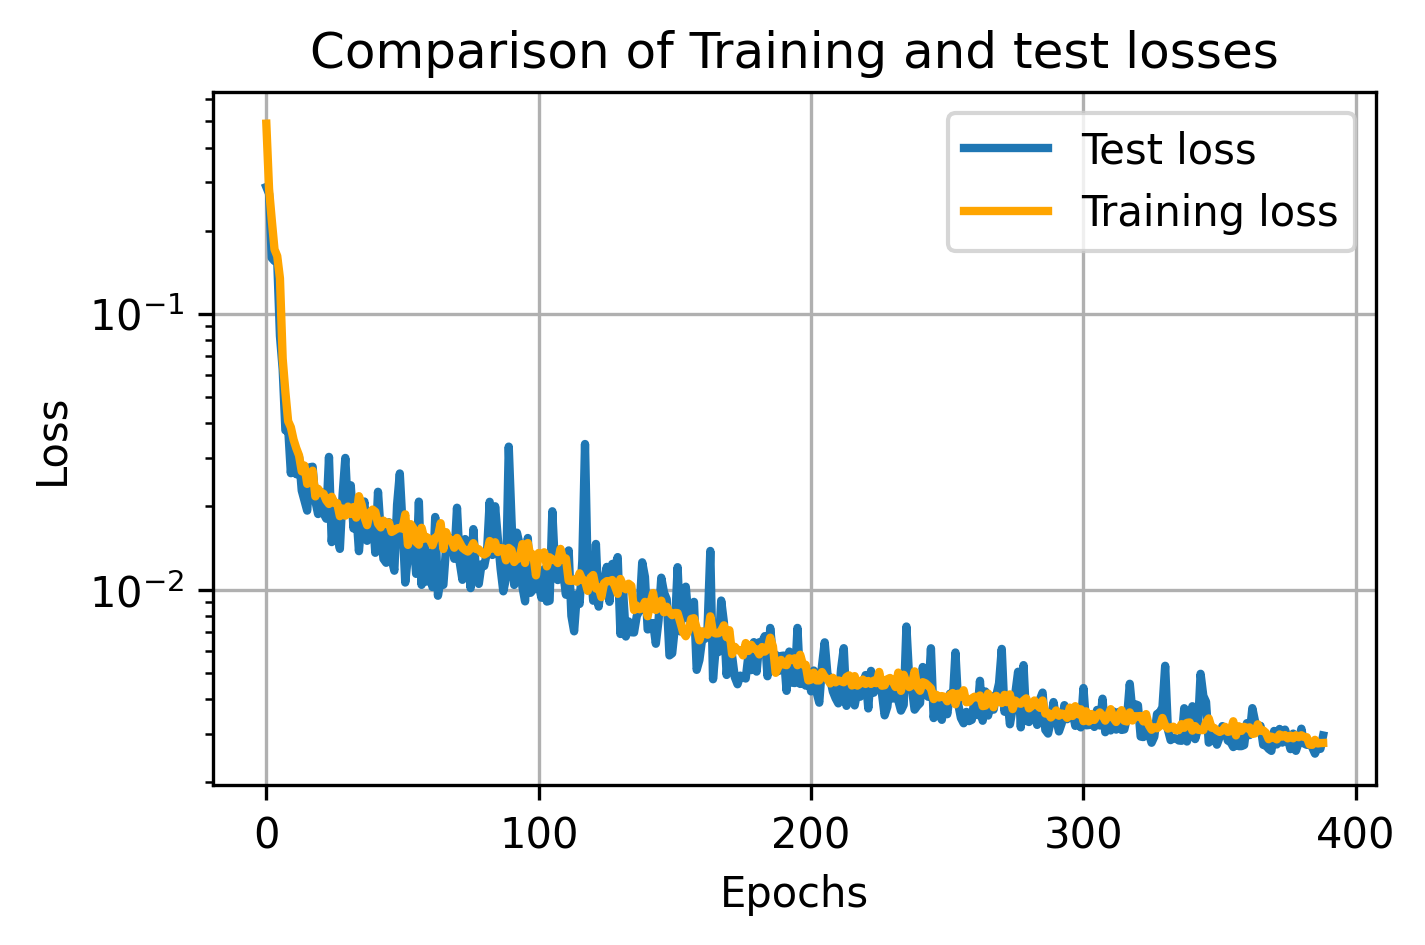

 40%|███████████████                       | 398/1000 [57:06<1:40:33, 10.02s/it]

Epoch:399 
 Training time for  epoch 399: 0.179 minutes,Training loss:  0.0028254024165529166, Testing loss: 0.0025386518612504007


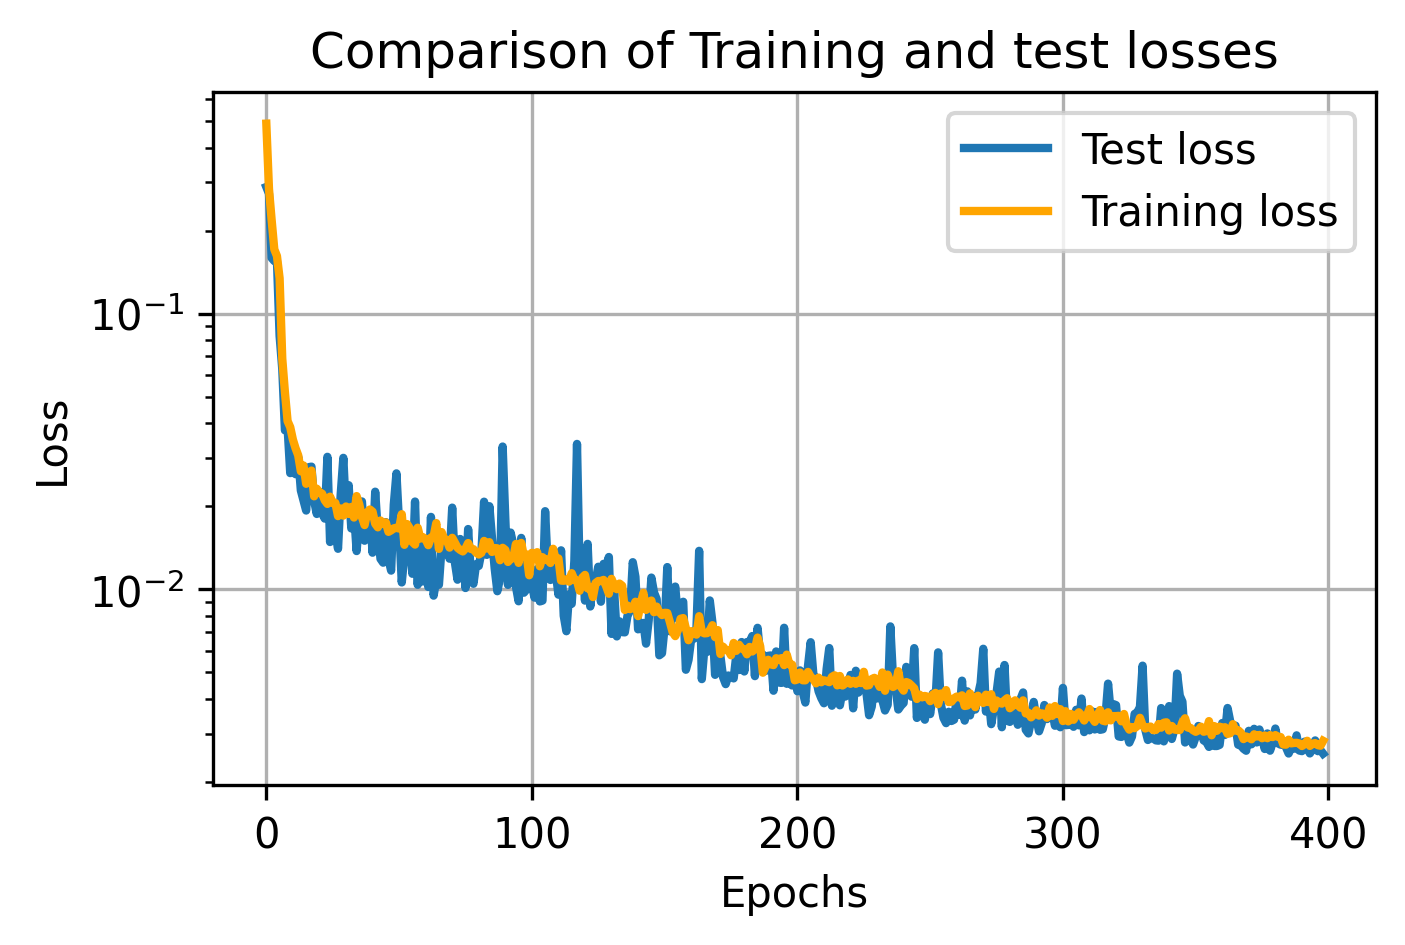

 40%|███████████████▎                      | 402/1000 [57:47<1:39:30,  9.98s/it]

Epoch 00402: reducing learning rate of group 0 to 6.8719e-05.


 41%|███████████████▌                      | 408/1000 [58:34<1:13:47,  7.48s/it]

Epoch:409 
 Training time for  epoch 409: 0.088 minutes,Training loss:  0.0026854074942714696, Testing loss: 0.0027327313320711253


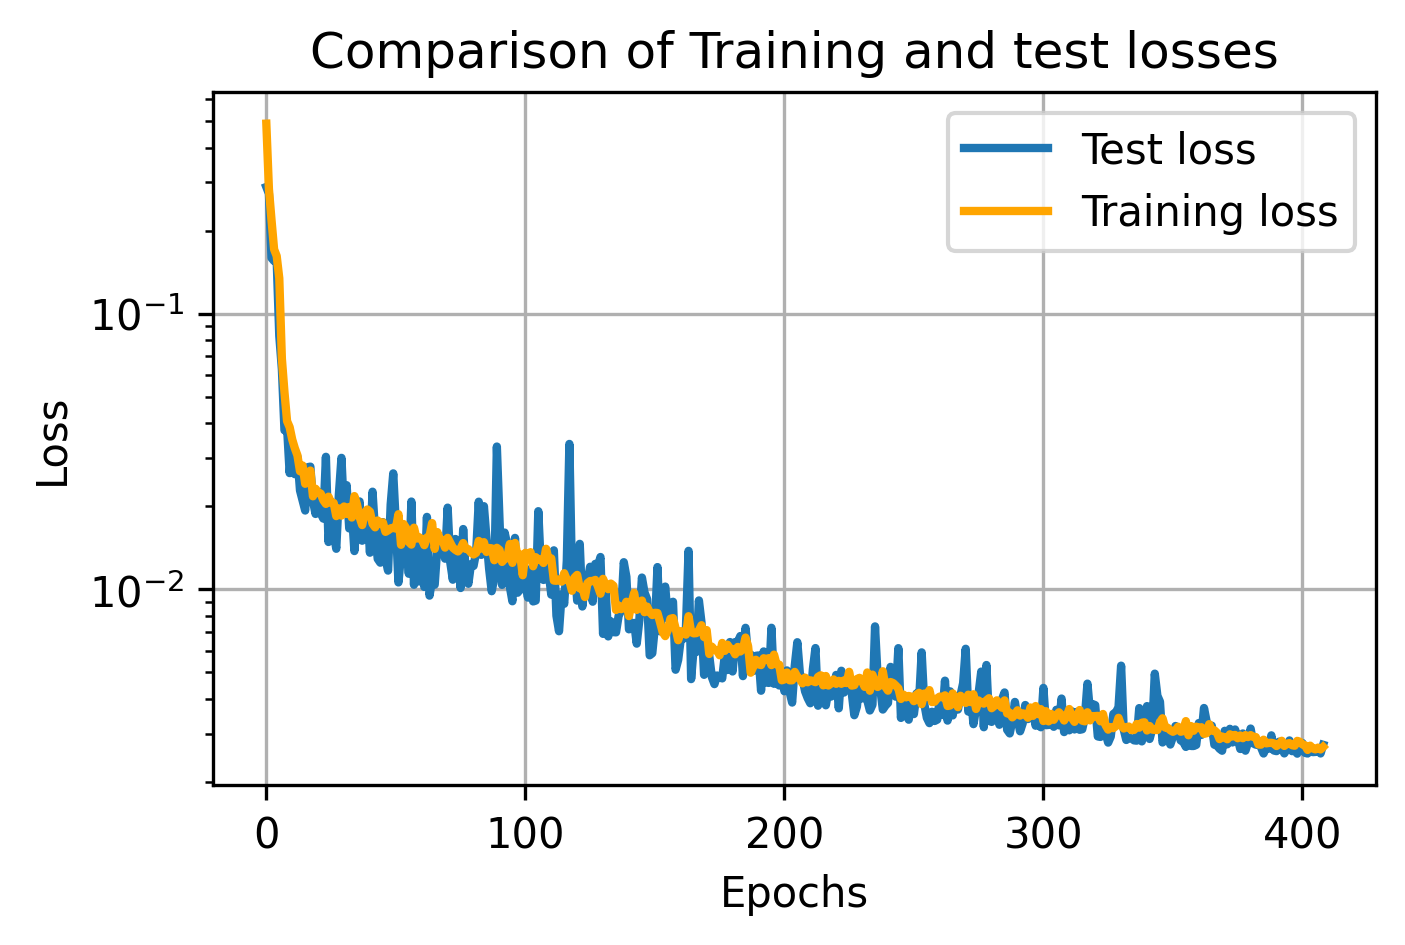

 42%|███████████████▉                      | 418/1000 [59:39<1:02:57,  6.49s/it]

Epoch:419 
 Training time for  epoch 419: 0.109 minutes,Training loss:  0.002651623639394529, Testing loss: 0.002459907755255699


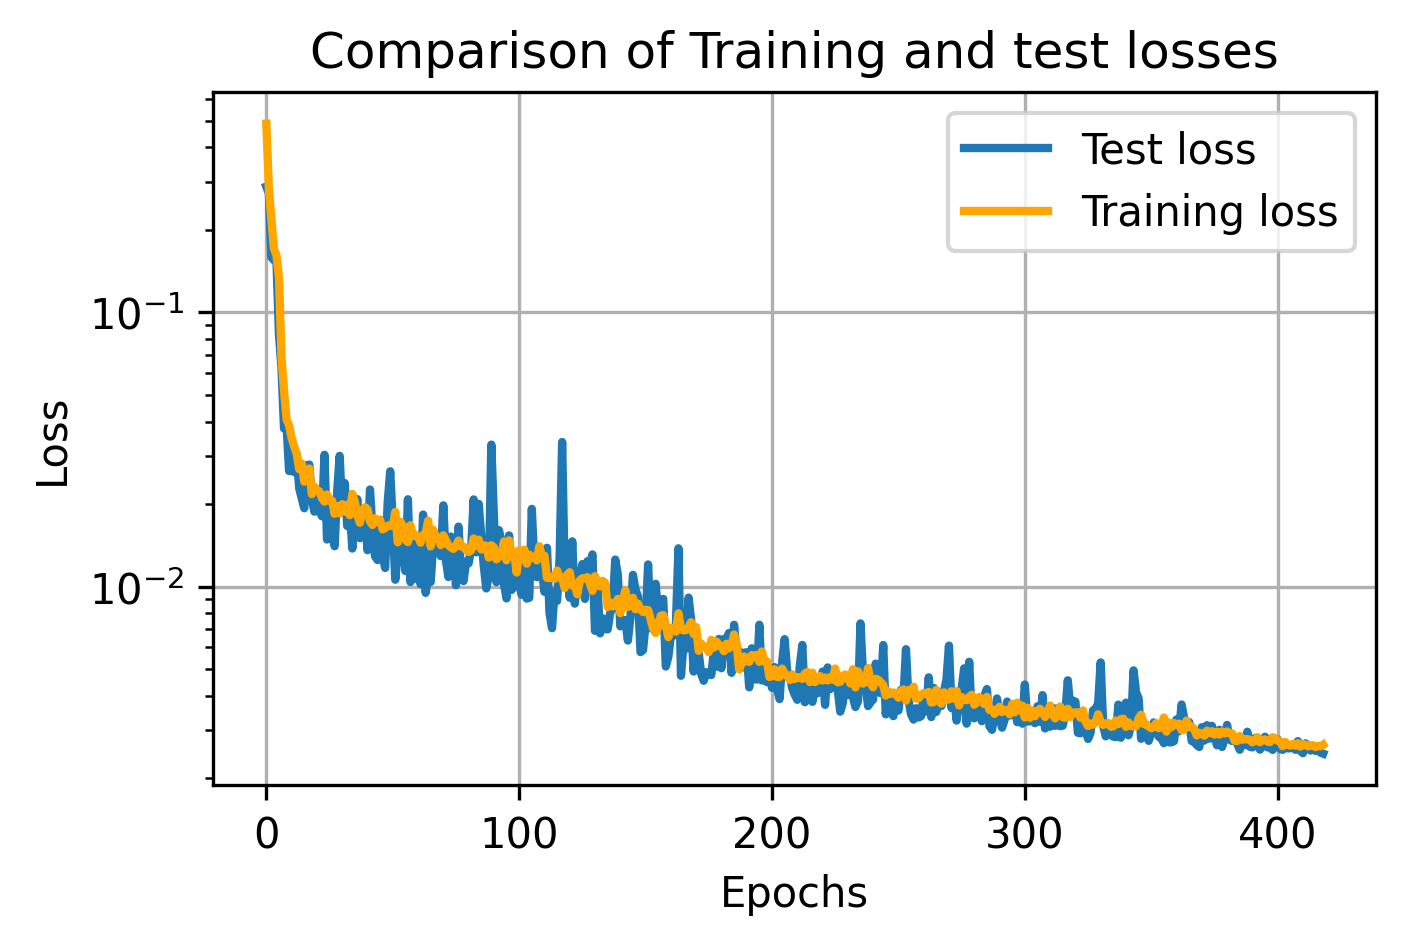

 43%|███████████████▍                    | 428/1000 [1:00:44<1:00:59,  6.40s/it]

Epoch:429 
 Training time for  epoch 429: 0.108 minutes,Training loss:  0.002636953501922374, Testing loss: 0.002753367815166712


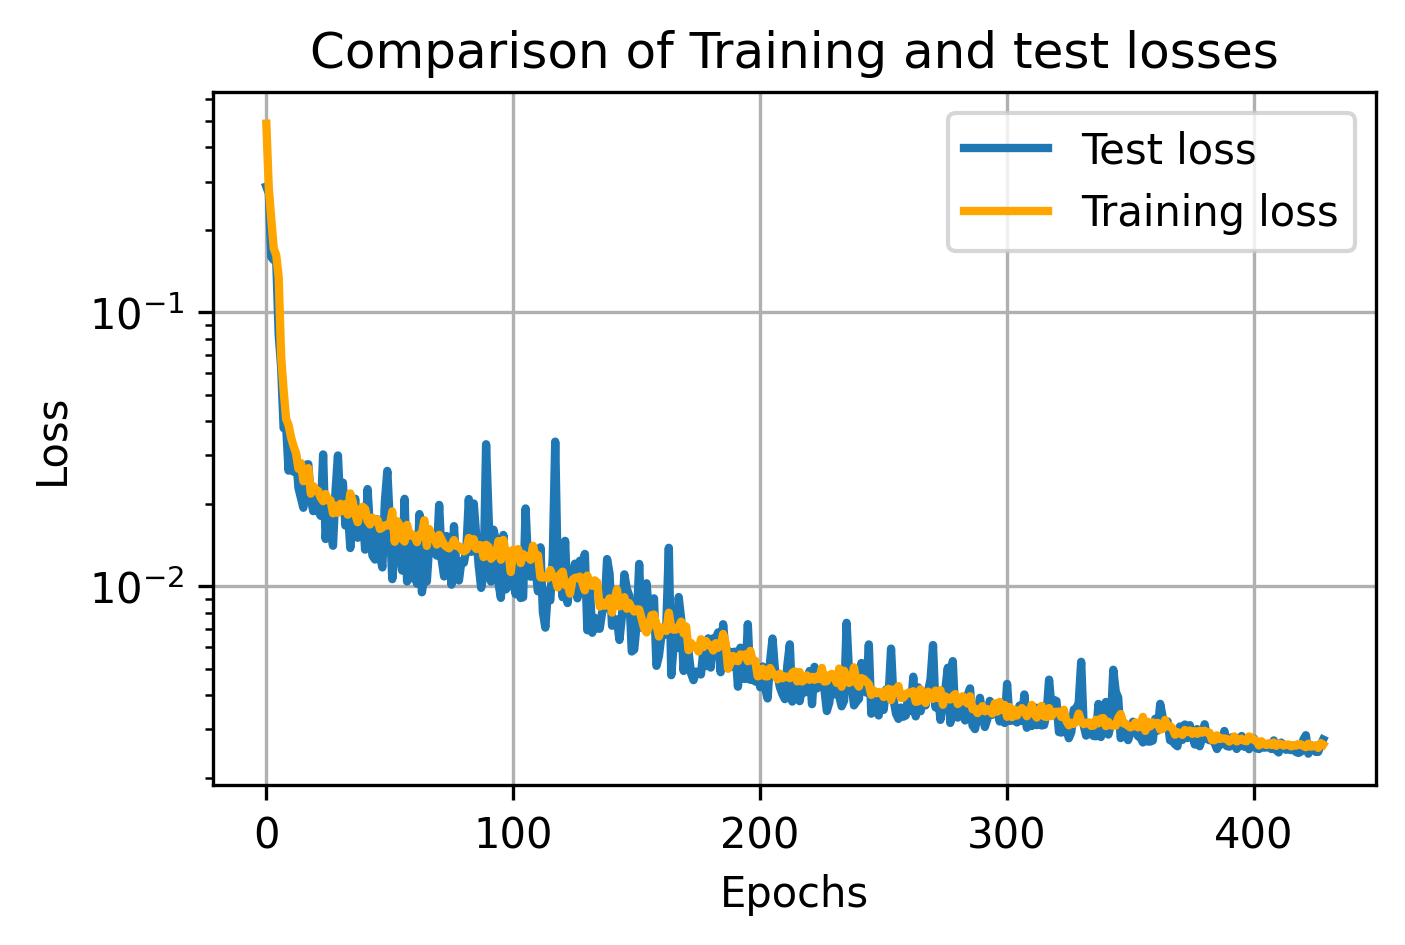

 44%|███████████████▊                    | 438/1000 [1:01:49<1:00:45,  6.49s/it]

Epoch 00438: reducing learning rate of group 0 to 5.4976e-05.
Epoch:439 
 Training time for  epoch 439: 0.108 minutes,Training loss:  0.0024909727671467586, Testing loss: 0.0024069619411602617


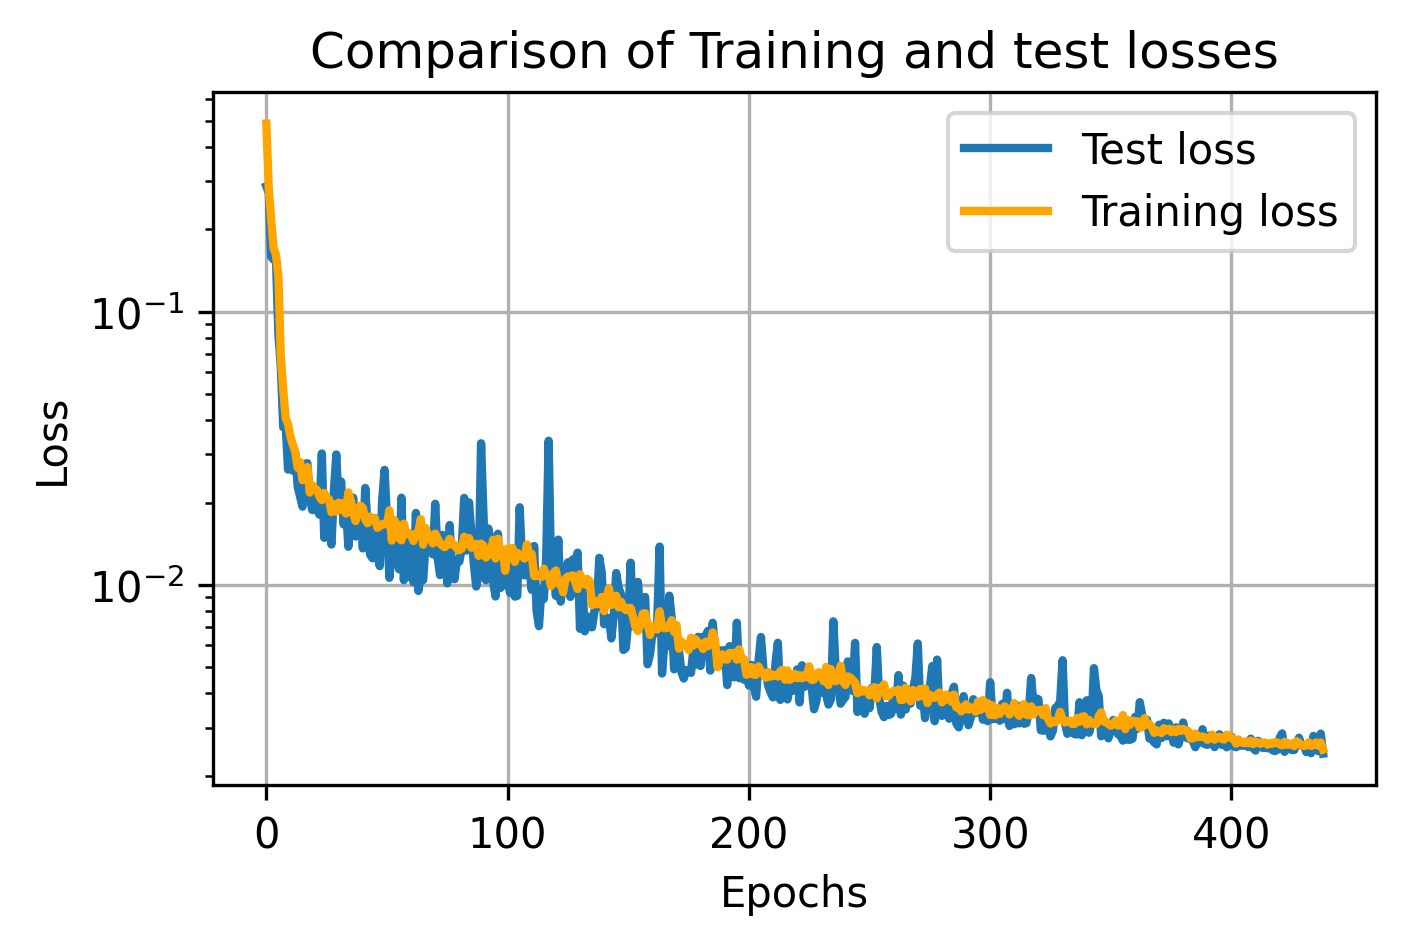

 45%|█████████████████                     | 448/1000 [1:02:48<52:41,  5.73s/it]

Epoch:449 
 Training time for  epoch 449: 0.106 minutes,Training loss:  0.0025292296850238927, Testing loss: 0.0024715692596510054


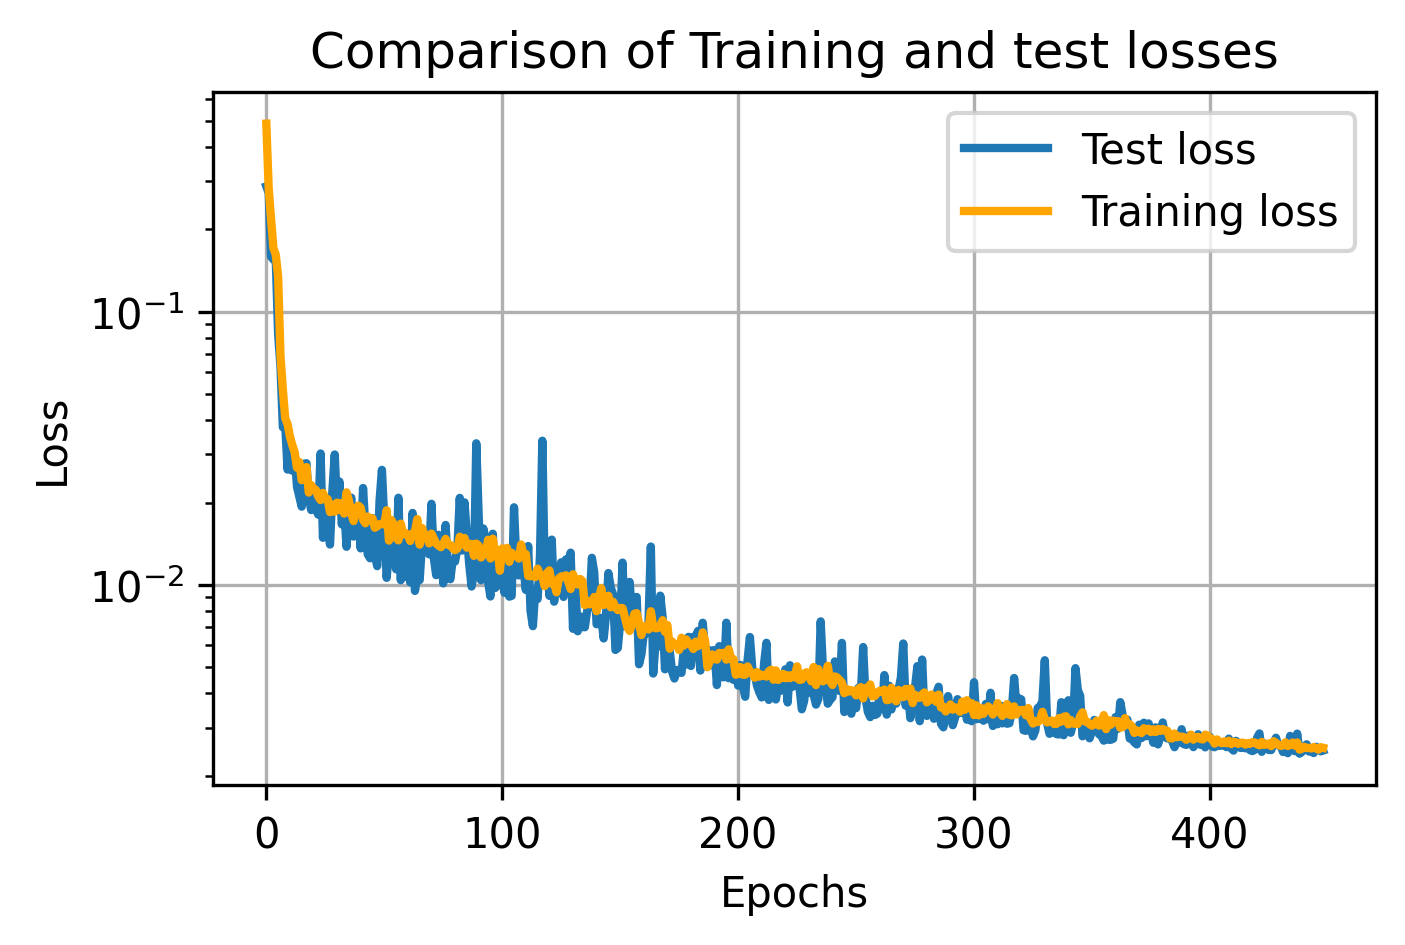

 46%|█████████████████▍                    | 458/1000 [1:03:52<57:40,  6.38s/it]

Epoch:459 
 Training time for  epoch 459: 0.108 minutes,Training loss:  0.002481922783772461, Testing loss: 0.0023584228195250036


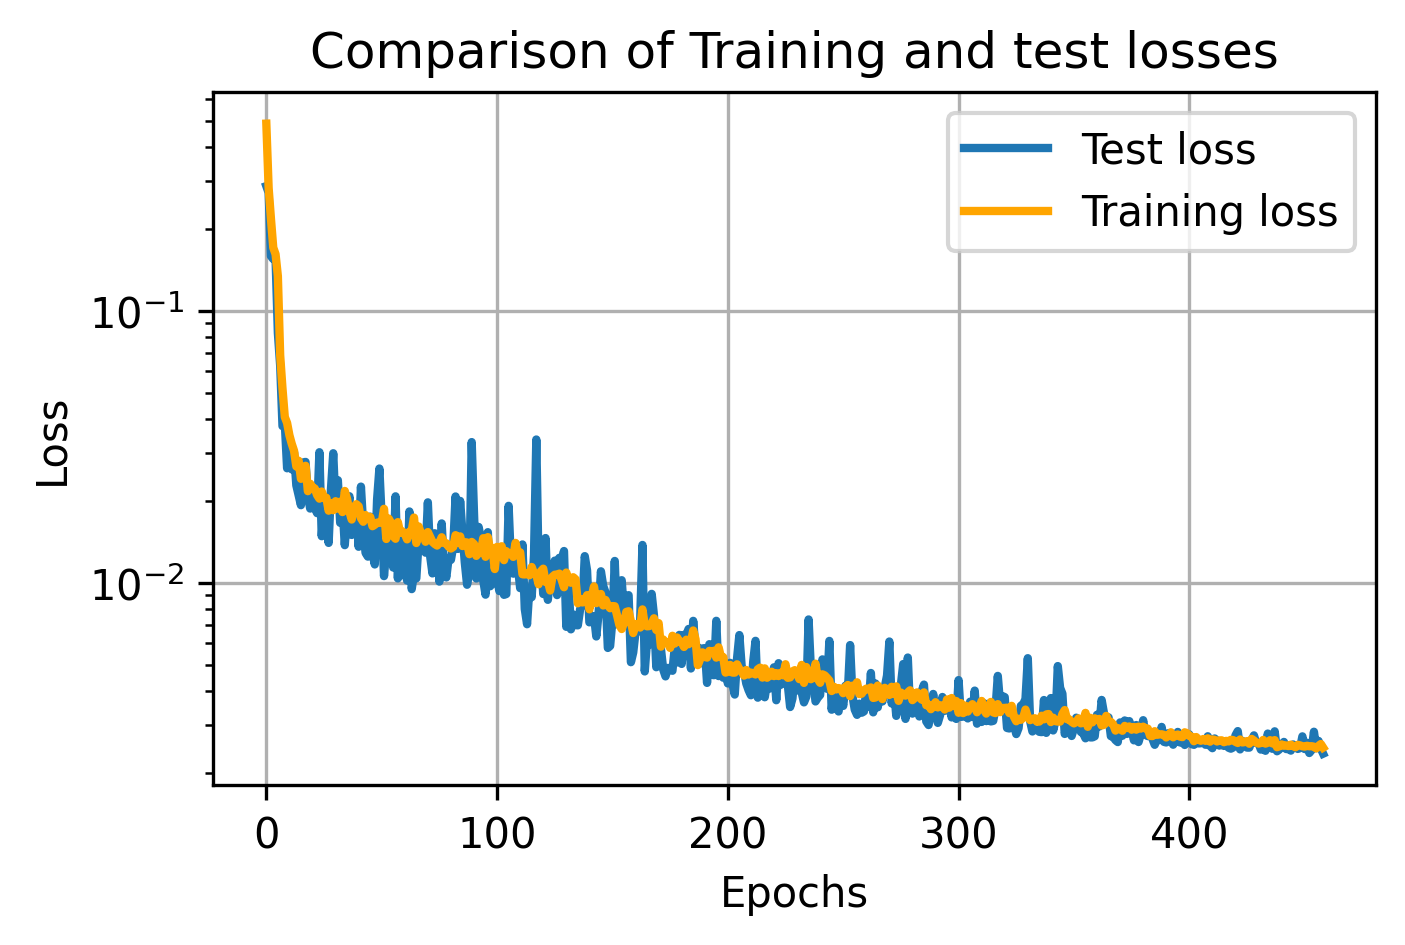

 47%|█████████████████▋                    | 467/1000 [1:04:49<56:26,  6.35s/it]

Epoch 00467: reducing learning rate of group 0 to 4.3980e-05.


 47%|█████████████████▊                    | 468/1000 [1:04:55<56:31,  6.37s/it]

Epoch:469 
 Training time for  epoch 469: 0.108 minutes,Training loss:  0.002478138034880763, Testing loss: 0.0024118723440915346


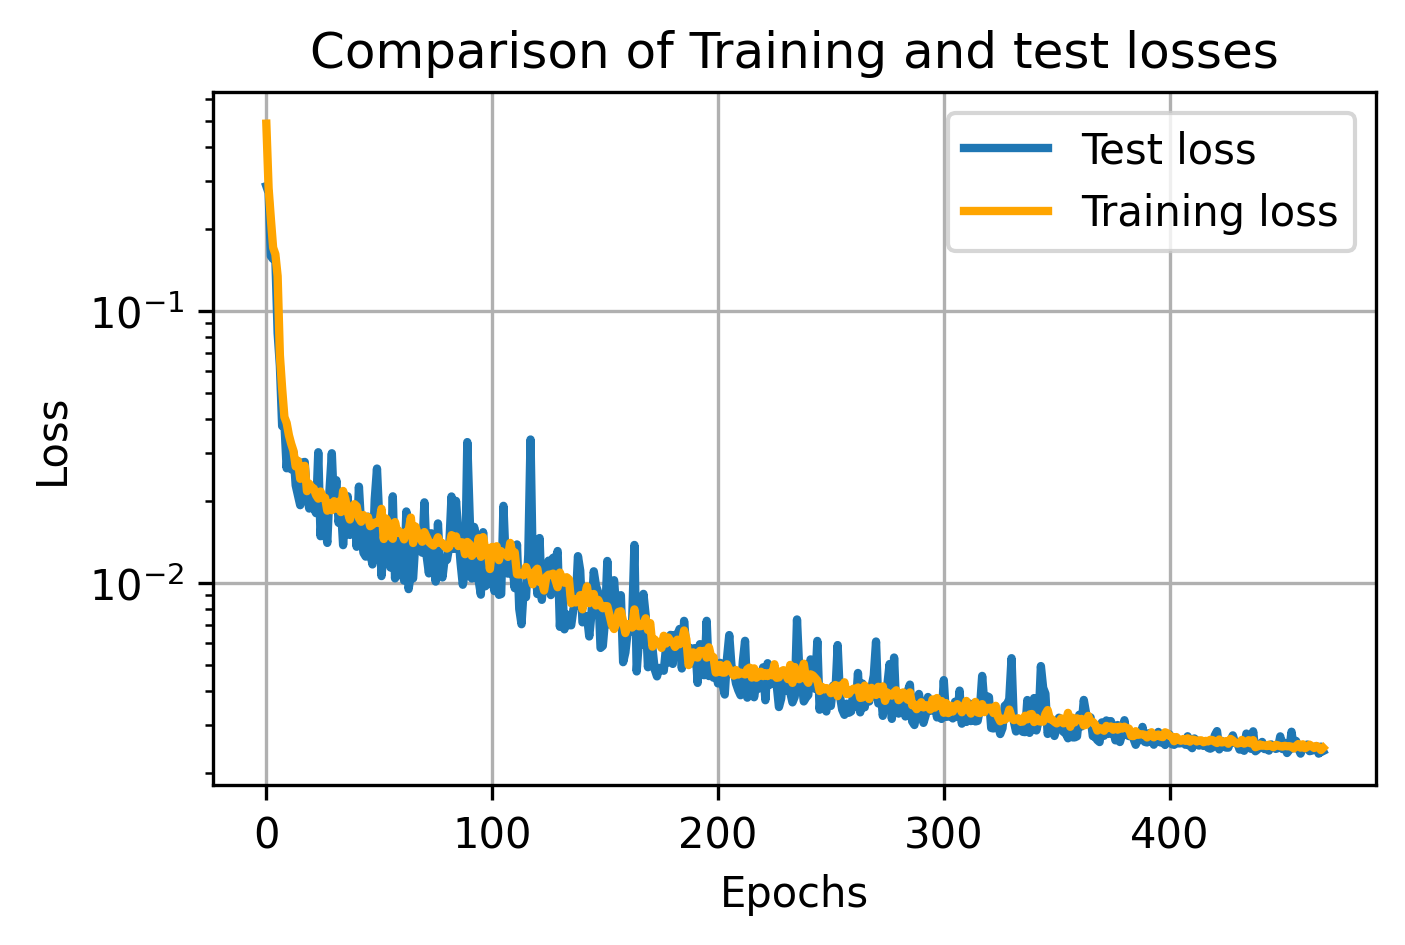

 48%|█████████████████▏                  | 478/1000 [1:06:07<1:09:10,  7.95s/it]

Epoch:479 
 Training time for  epoch 479: 0.178 minutes,Training loss:  0.002442023629200554, Testing loss: 0.0023390401247888803


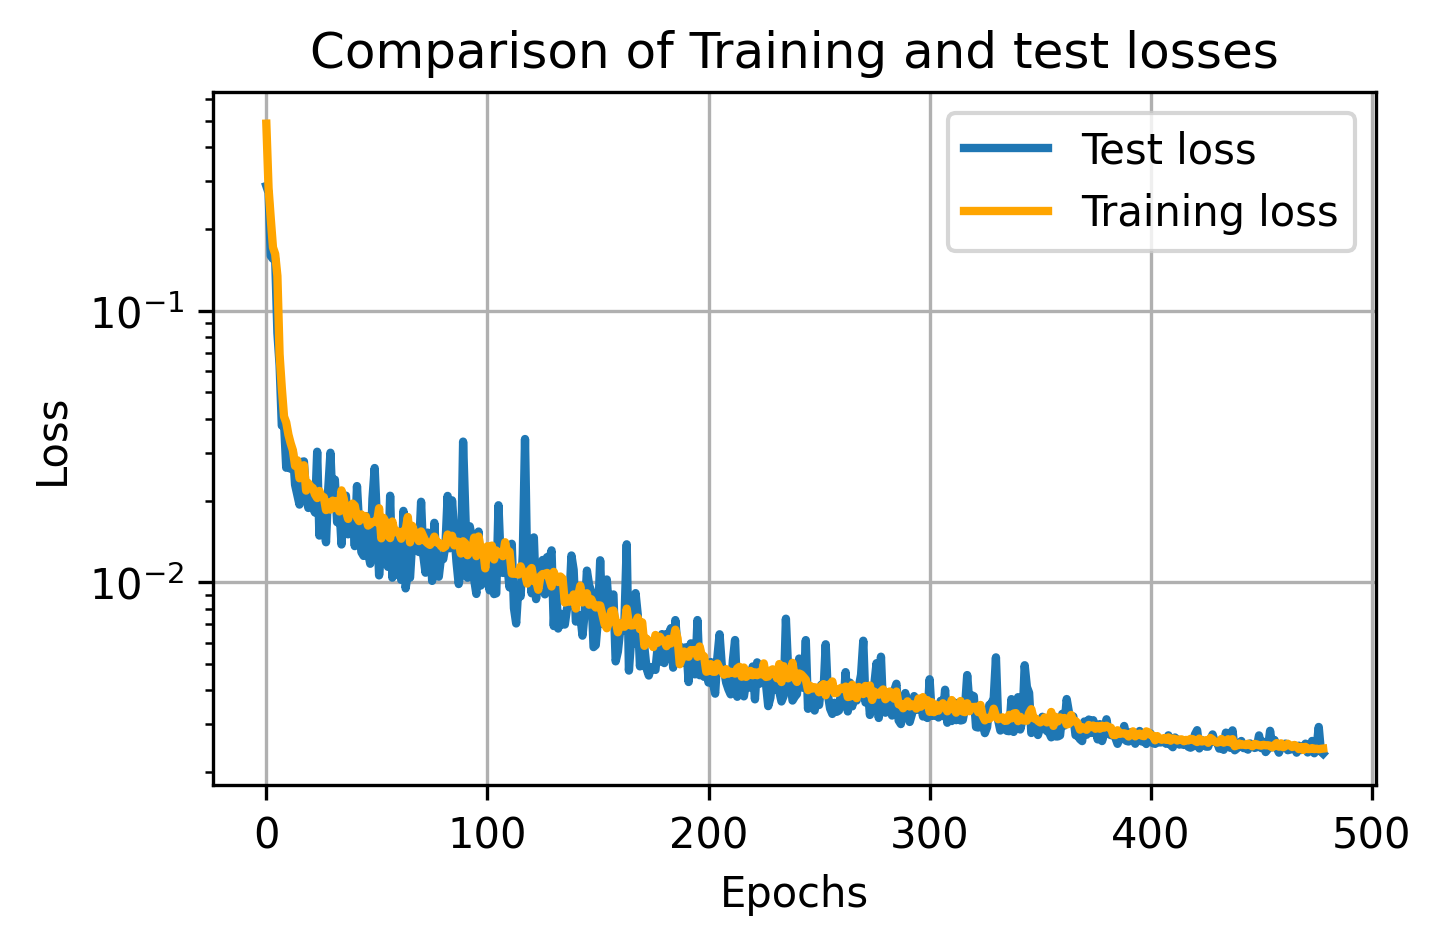

 48%|█████████████████▎                  | 480/1000 [1:06:27<1:17:11,  8.91s/it]

Epoch 00481: reducing learning rate of group 0 to 3.5184e-05.


 49%|█████████████████▌                  | 488/1000 [1:07:50<1:28:39, 10.39s/it]

Epoch:489 
 Training time for  epoch 489: 0.175 minutes,Training loss:  0.0023799760291273366, Testing loss: 0.002357957107014954


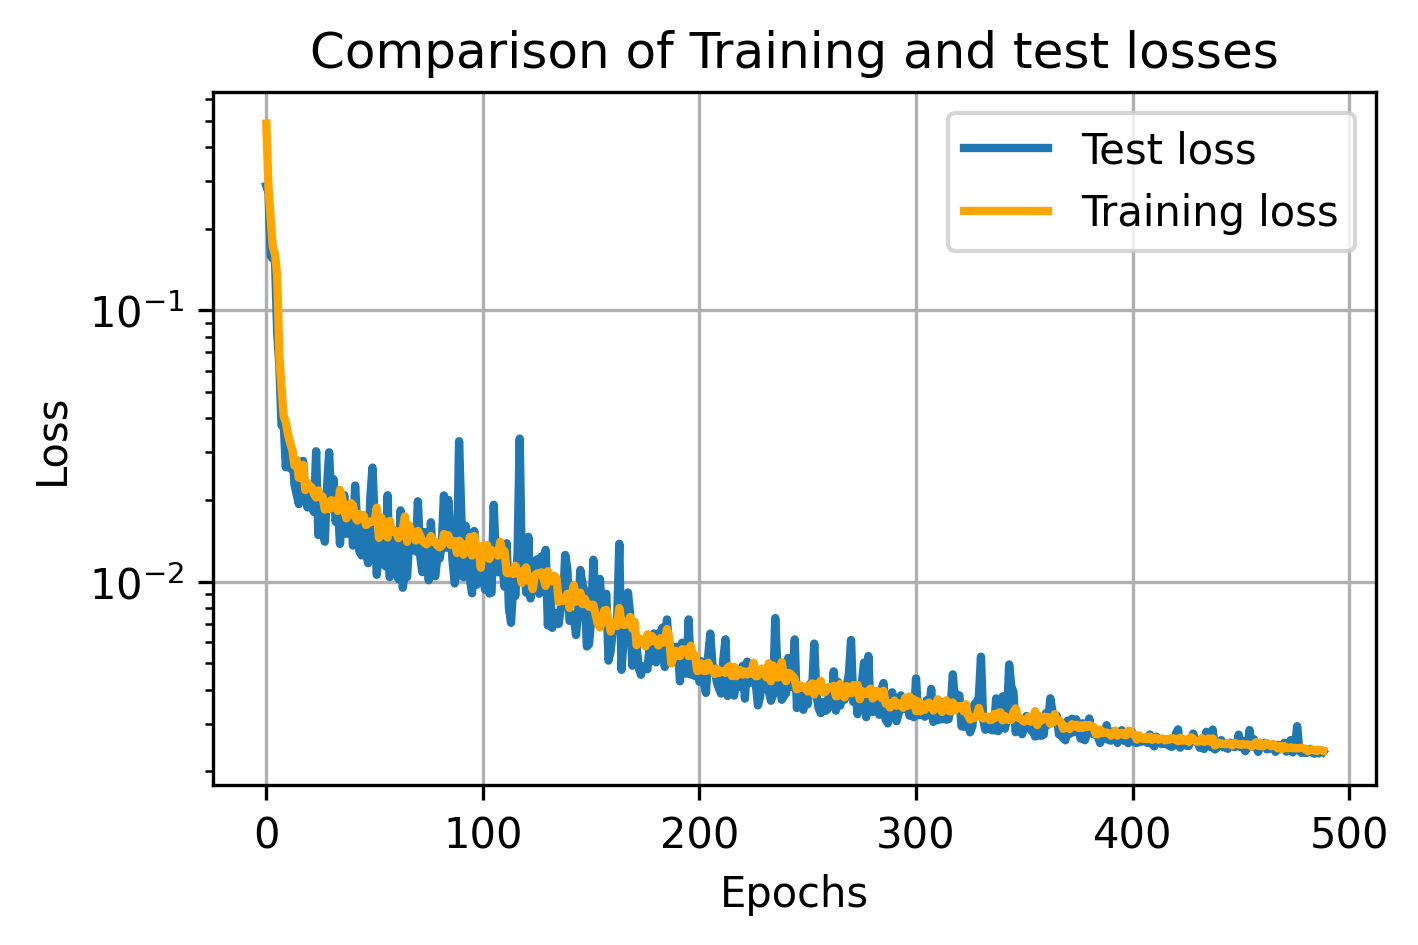

 49%|█████████████████▋                  | 493/1000 [1:08:33<1:09:10,  8.19s/it]

Epoch 00493: reducing learning rate of group 0 to 2.8147e-05.


 50%|██████████████████▉                   | 498/1000 [1:09:05<56:25,  6.74s/it]

Epoch:499 
 Training time for  epoch 499: 0.108 minutes,Training loss:  0.002362986414149551, Testing loss: 0.002303026665467769


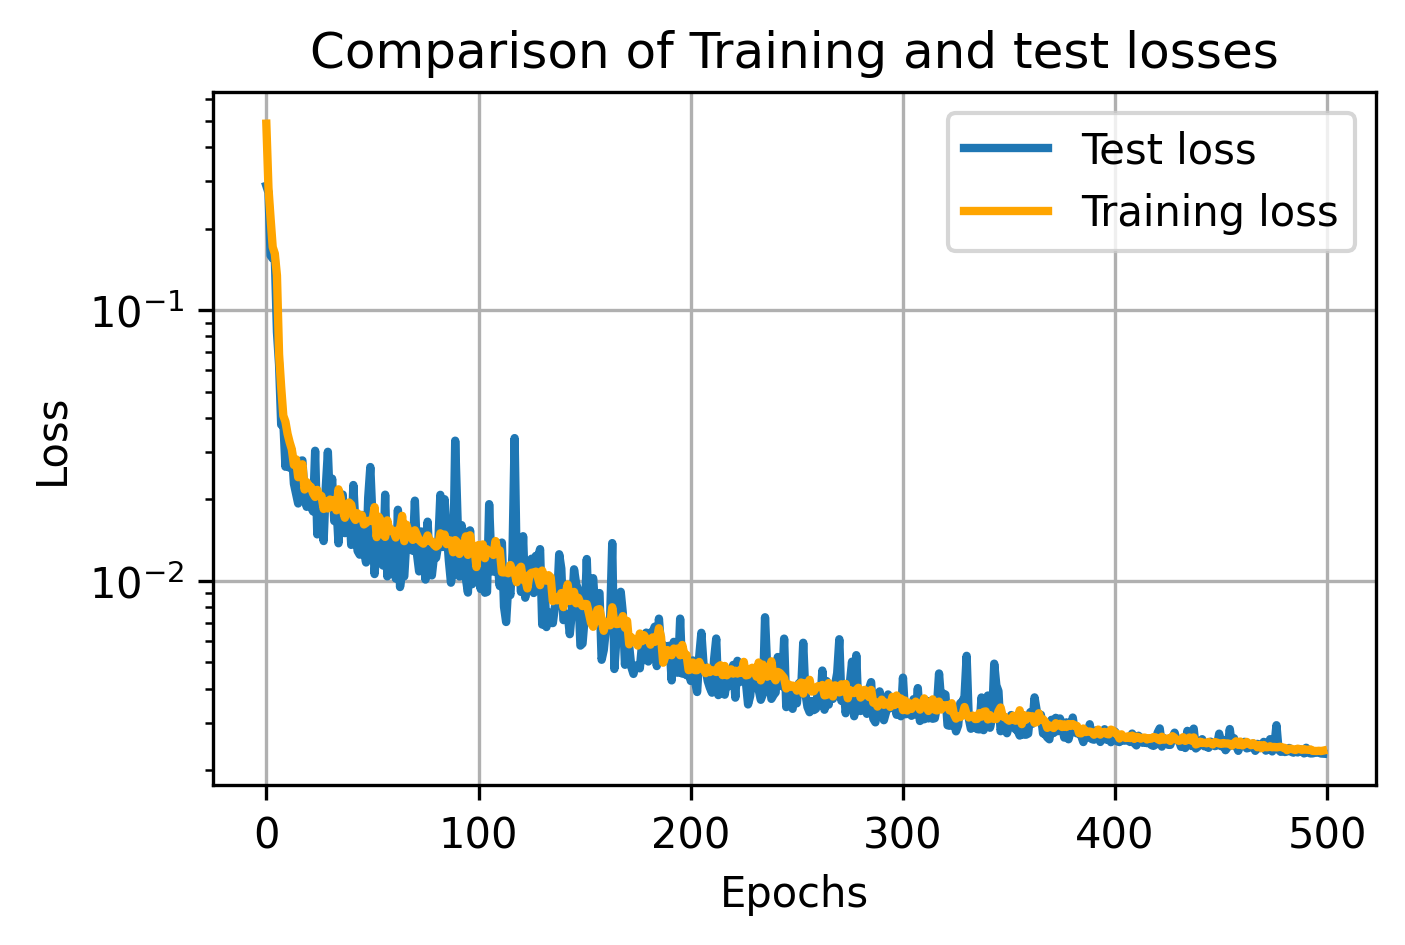

 51%|███████████████████▎                  | 508/1000 [1:10:10<52:55,  6.45s/it]

Epoch:509 
 Training time for  epoch 509: 0.108 minutes,Training loss:  0.0023415499170191542, Testing loss: 0.002351859277114272


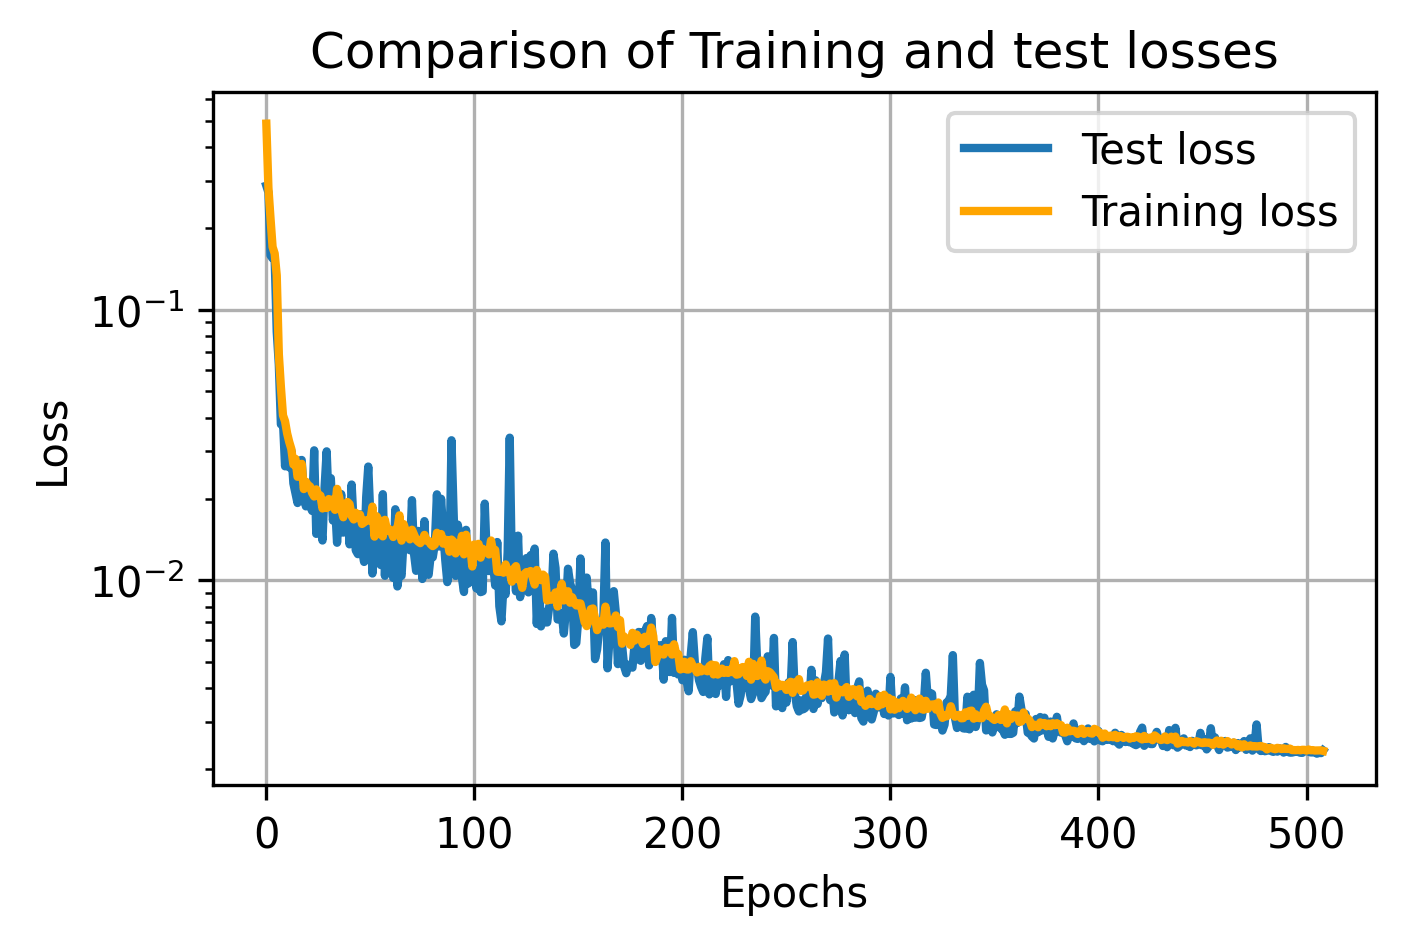

 52%|███████████████████▋                  | 518/1000 [1:11:16<54:51,  6.83s/it]

Epoch:519 
 Training time for  epoch 519: 0.105 minutes,Training loss:  0.002336758189435719, Testing loss: 0.002286460055038333


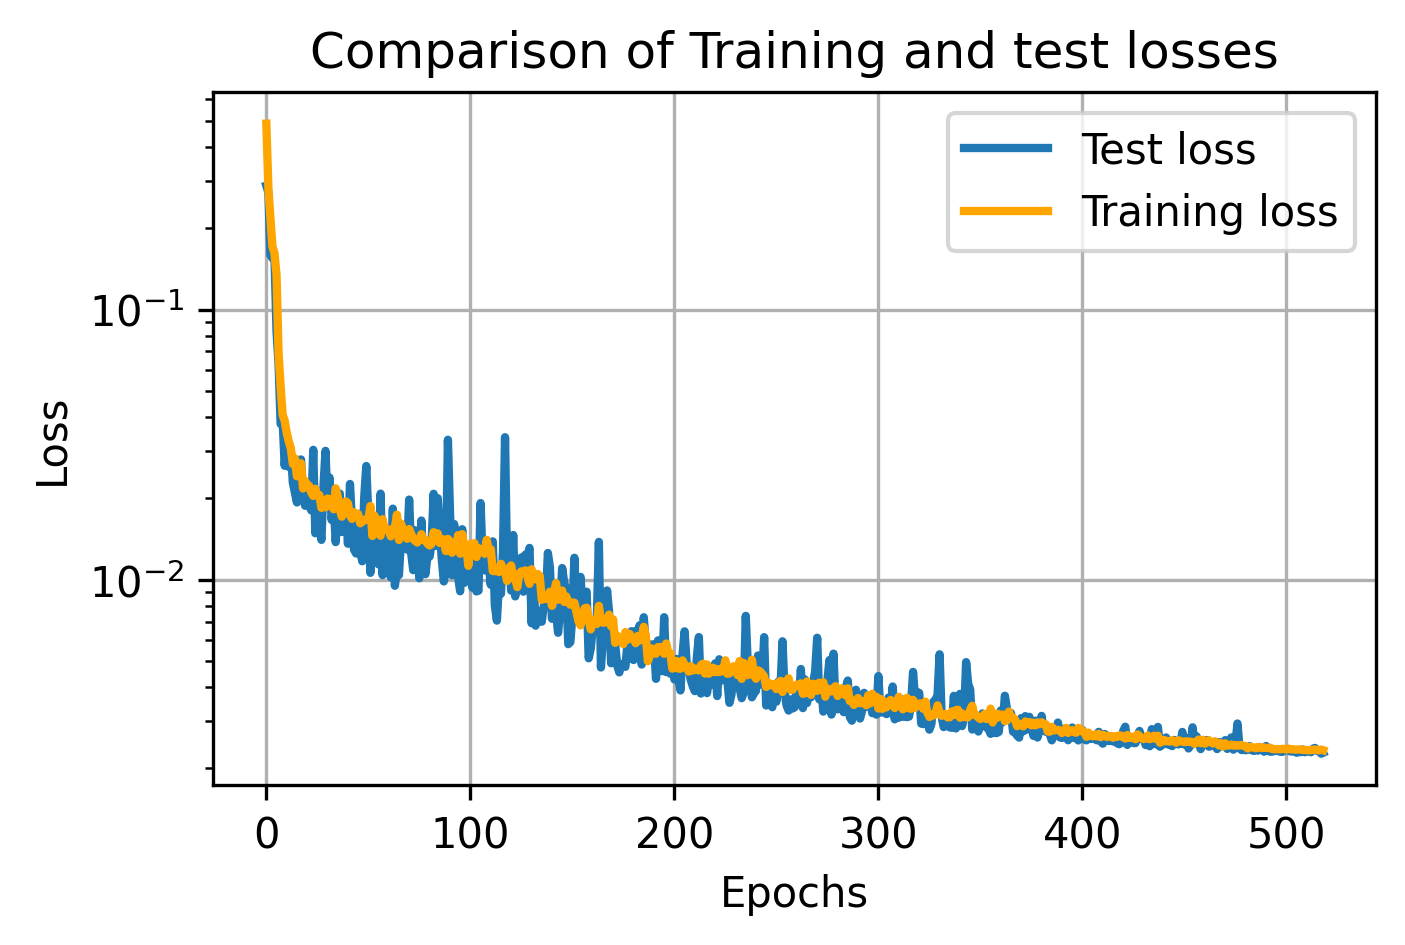

 53%|███████████████████                 | 528/1000 [1:12:52<1:18:19,  9.96s/it]

Epoch:529 
 Training time for  epoch 529: 0.177 minutes,Training loss:  0.002323158160412809, Testing loss: 0.002344393469393253


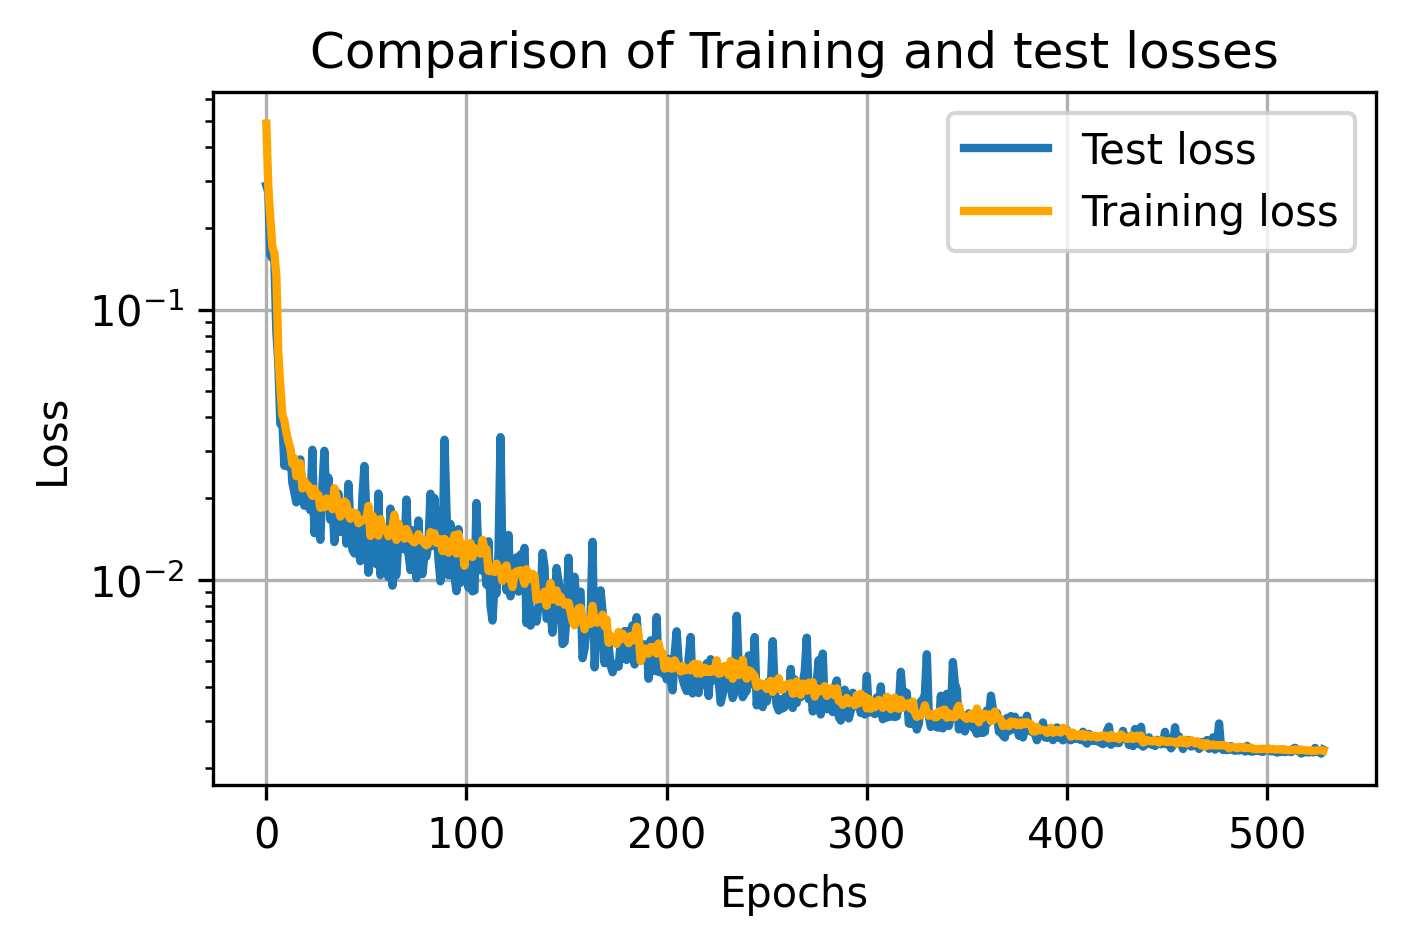

 53%|███████████████████                 | 531/1000 [1:13:33<1:04:58,  8.31s/it]

Early stopping at epoch 532
Total training time 1.226 hours


In [20]:
# Model training 

start_training = default_timer()

epochs = 1000

train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)
best_val_loss = float('inf')
trigger_times = 0  # Counter for early stopping

for ep in tqdm(range(1,epochs+1)):
    
    model.train()
    t1 = default_timer()
    train_l2 = 0
    
    for x, y in train_loader:
        
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()

        out = model(x).reshape( batch_size, nz, nx )

        loss = myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))

        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    train_l2 /= len(x_train)
    train_loss[ep-1] = train_l2

    scheduler.step( train_l2 ) # Update learning rate with average of train events

    # Early stopping logic
    if best_val_loss - train_l2 > 1e-4 :
        
        best_val_loss = train_l2
        trigger_times = 0  # Reset the counter if validation loss improves
        
        # Optionally, save the model with the best validation loss
        torch.save( model.state_dict(), model_name )
        
    else:
        
        trigger_times += 1
        
        if trigger_times >= patience:
            
            print(f"Early stopping at epoch {ep}")
            break  # Stop training if validation loss hasn't improved in 'patience' epochs


    
    model.eval()
    test_l2 = 0.0
      
    with torch.no_grad():
            
        for x, y in test_loader:
            
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape( batch_size, nz, nx )

            test_l2 += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1)).item()
                
    test_l2 /= len(x_test)
    test_loss[ep-1] = test_l2

    t2 = default_timer()

    if (ep+1) % 10 == 0:

        print(f'Epoch:{ep} \n Training time for  epoch {ep}: {round((t2-t1)/60,3)} minutes,Training loss:  {train_l2}, Testing loss: {test_l2}')
    
        # Loss Figure
        fig = plt.figure( figsize=(5, 3), dpi=300 )
        ax = plt.axes()
            
        ax.semilogy(test_loss[:ep], linewidth=2, label = 'Test loss')
        ax.semilogy(train_loss[:ep], linewidth=2, label = 'Training loss', color = 'orange')
        ax.set_xlabel('Epochs', fontsize=10)
        plt.xticks(fontsize=10)
        ax.xaxis.set_major_locator(plt.MultipleLocator(100))        
        ax.set_ylabel('Loss', fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid()
        plt.legend(loc='upper right')
        plt.title('Comparison of Training and test losses')
        plt.show()

end = default_timer() - start_training

if end > 3600:
    print(f'Total training time {round(end/3600,3)} hours')
else:
    print(f'Total training time {round(end/60,3)} minutes')

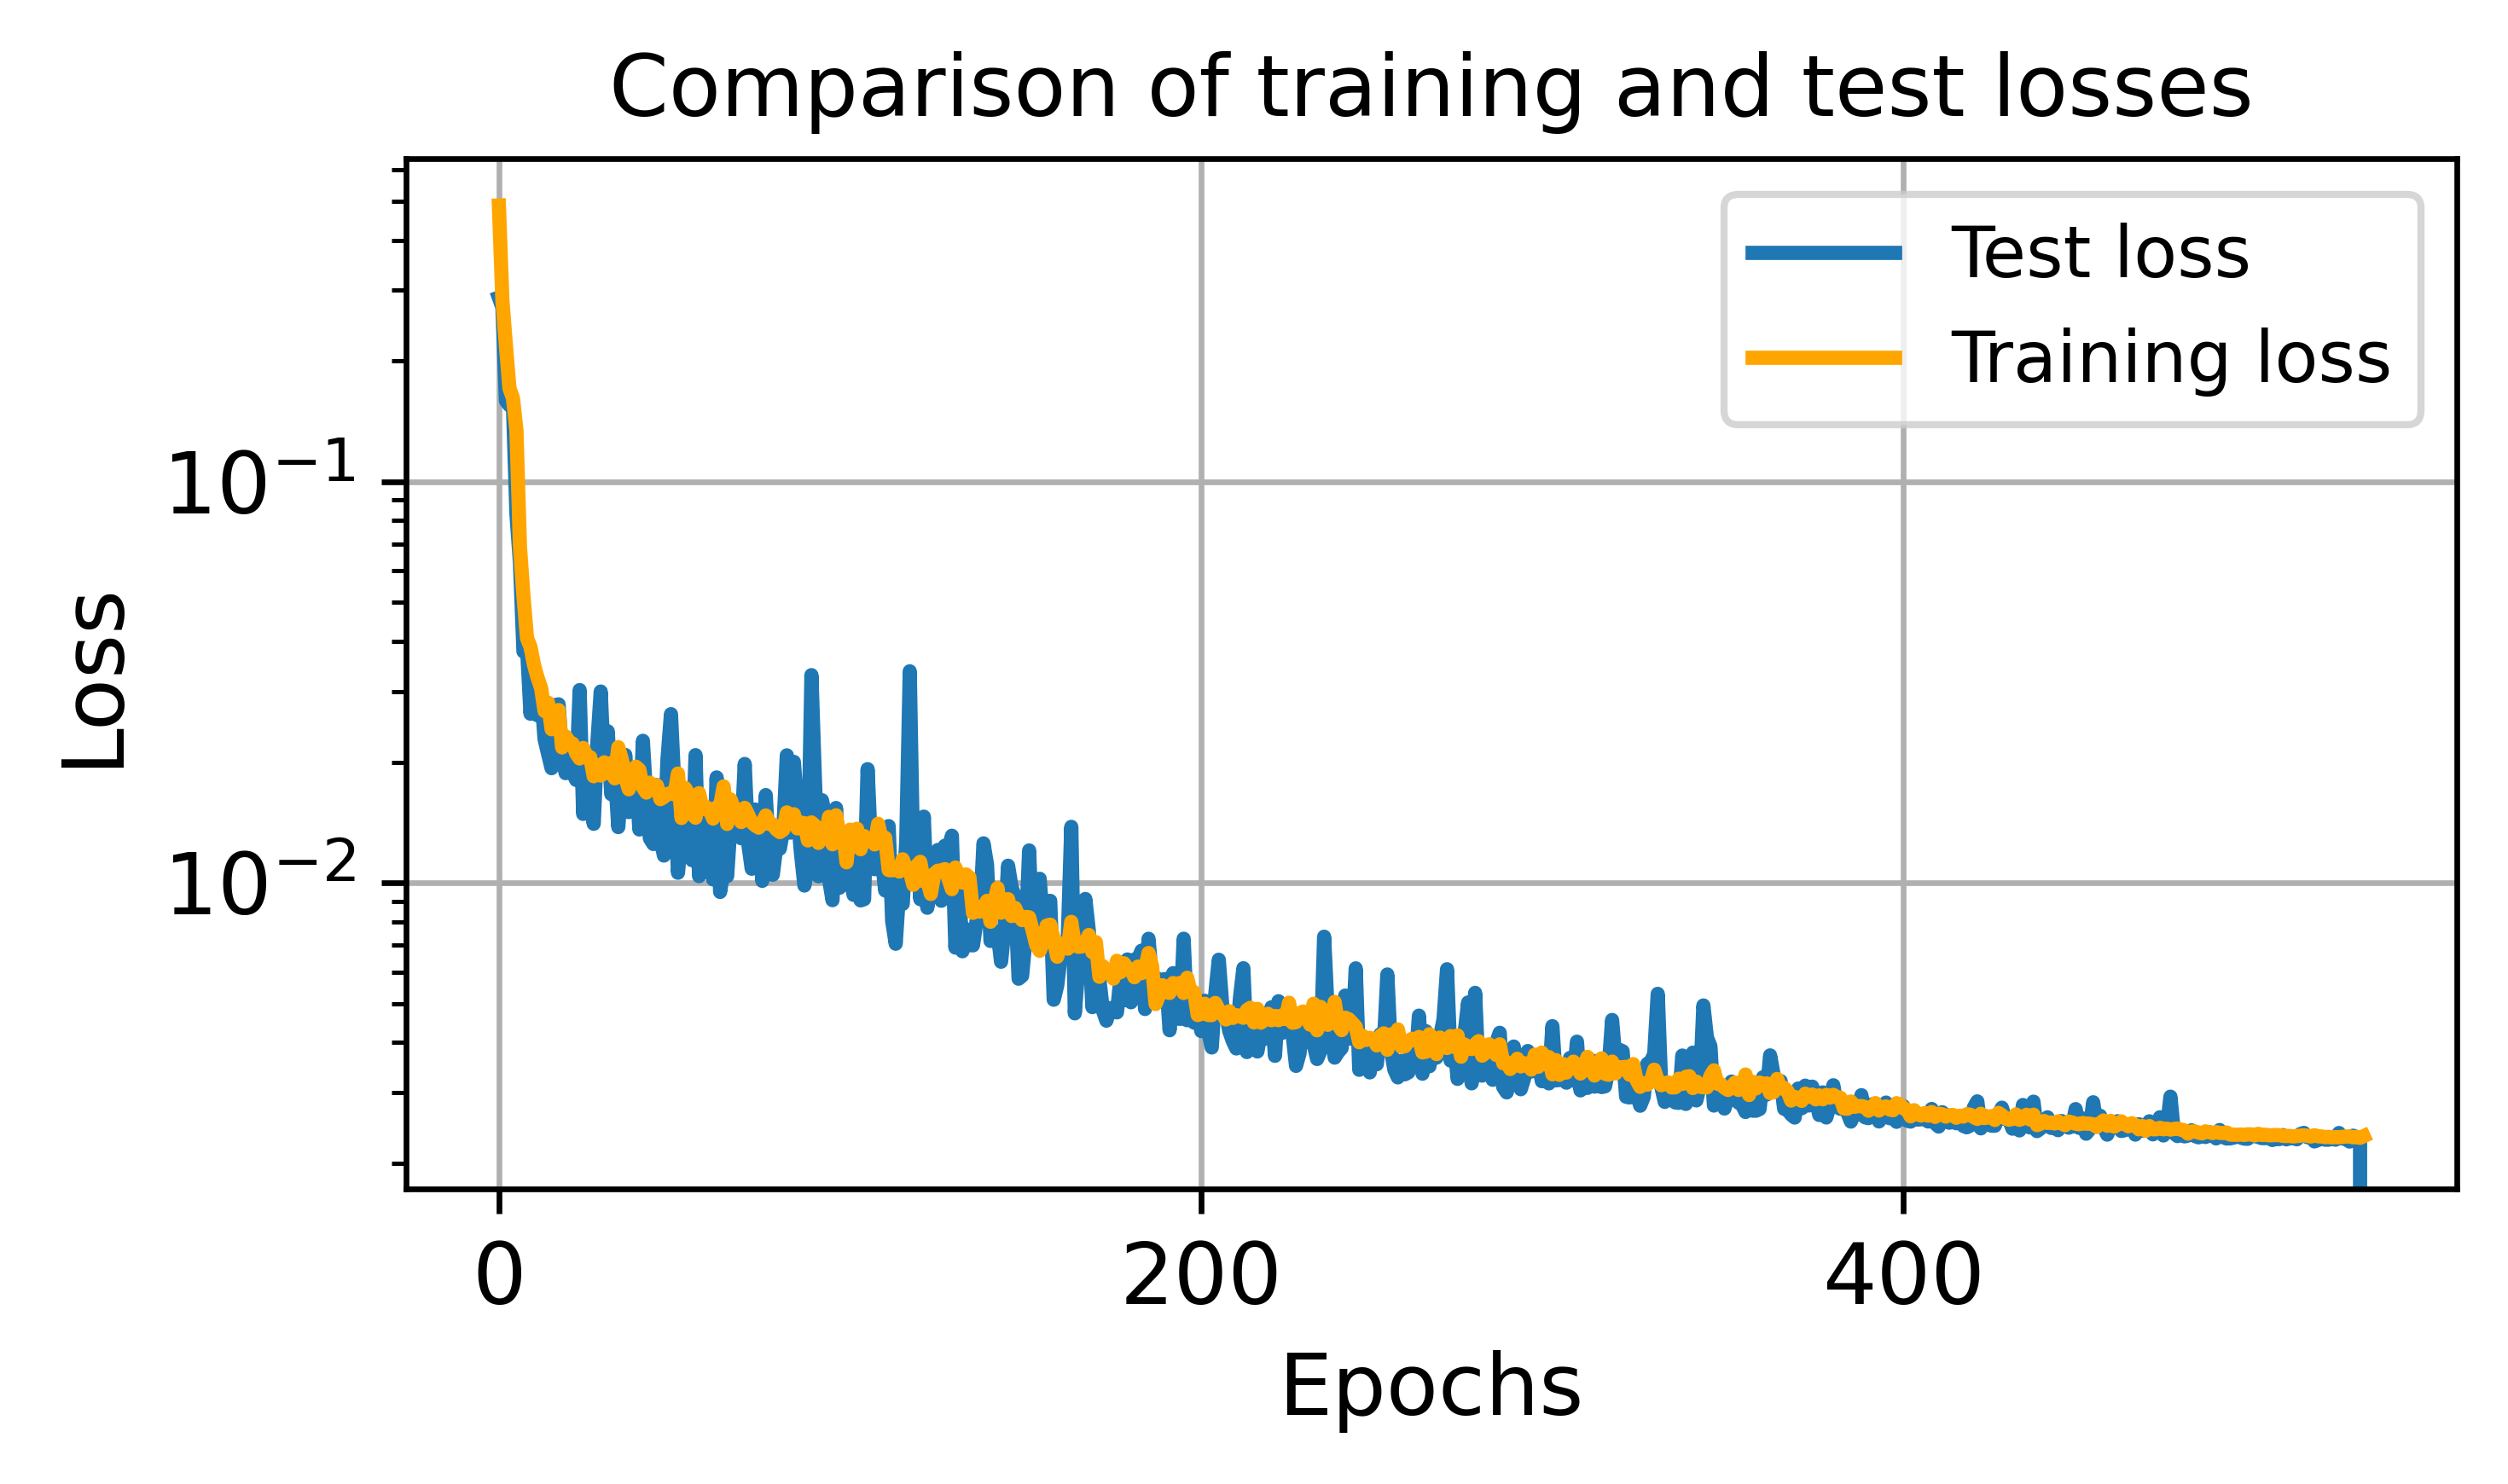

In [21]:
# Convergence history plot for verification

plt.style.use('default')
fig = plt.figure(figsize=(5, 3), dpi=600 )
ax = plt.axes()

ax.semilogy(test_loss[:ep], linewidth=2, label = 'Test loss')
ax.semilogy(train_loss[:ep], linewidth=2, label = 'Training loss', color = 'orange')

ax.set_xlabel('Epochs', fontsize=12)
plt.xticks(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(200))

ax.set_ylabel('Loss', fontsize=12)
plt.yticks(fontsize=12)

plt.grid()
plt.legend(loc='upper right')
plt.title('Comparison of training and test losses')

plt.tight_layout()

# plt.savefig( 'Loss_gradient_'+str(int(spacing*1000))+'m_m2w2.png' , dpi=600 )

plt.show()

In [20]:
# To load the model if available

# model_name = 'Unet_Model_gradient_50m_best.pt'

# model.load_state_dict(torch.load(model_name))

model.eval()

SimpleUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), s

In [21]:
fsize = 12

def cust_pcolor(AX, X, Y, P, Xs=None, Ys=None, title=None, cmap='jet', 
                xlabel=True, ylabel=False, vmin=None, vmax=None):
    
    ax1 = AX.pcolor(X, Y, P, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ax1, ax=AX)
    cbar.ax.tick_params(labelsize=fsize)
    
    if Xs and Ys:
        AX.scatter(Xs, Ys, marker='*', color='r', s = 100 )
        
    AX.set_title(title, size=fsize)

    AX.invert_yaxis()

    AX.tick_params(axis='both', which='major', labelsize=fsize )  # Set tick label fontsize
    
    if xlabel: AX.set_xlabel('Offset (km)', size=fsize)
    if ylabel: AX.set_ylabel('Depth (km)', size=fsize)

    AX.set_aspect(1)

In [22]:
XMIN, XMAX = 0, 3
YMIN, YMAX = 0, 2
XGRID = np.linspace(XMIN, XMAX, nx)
YGRID = np.linspace(YMIN, YMAX, nz)
XGRID, YGRID = np.meshgrid(XGRID, YGRID, indexing='ij')

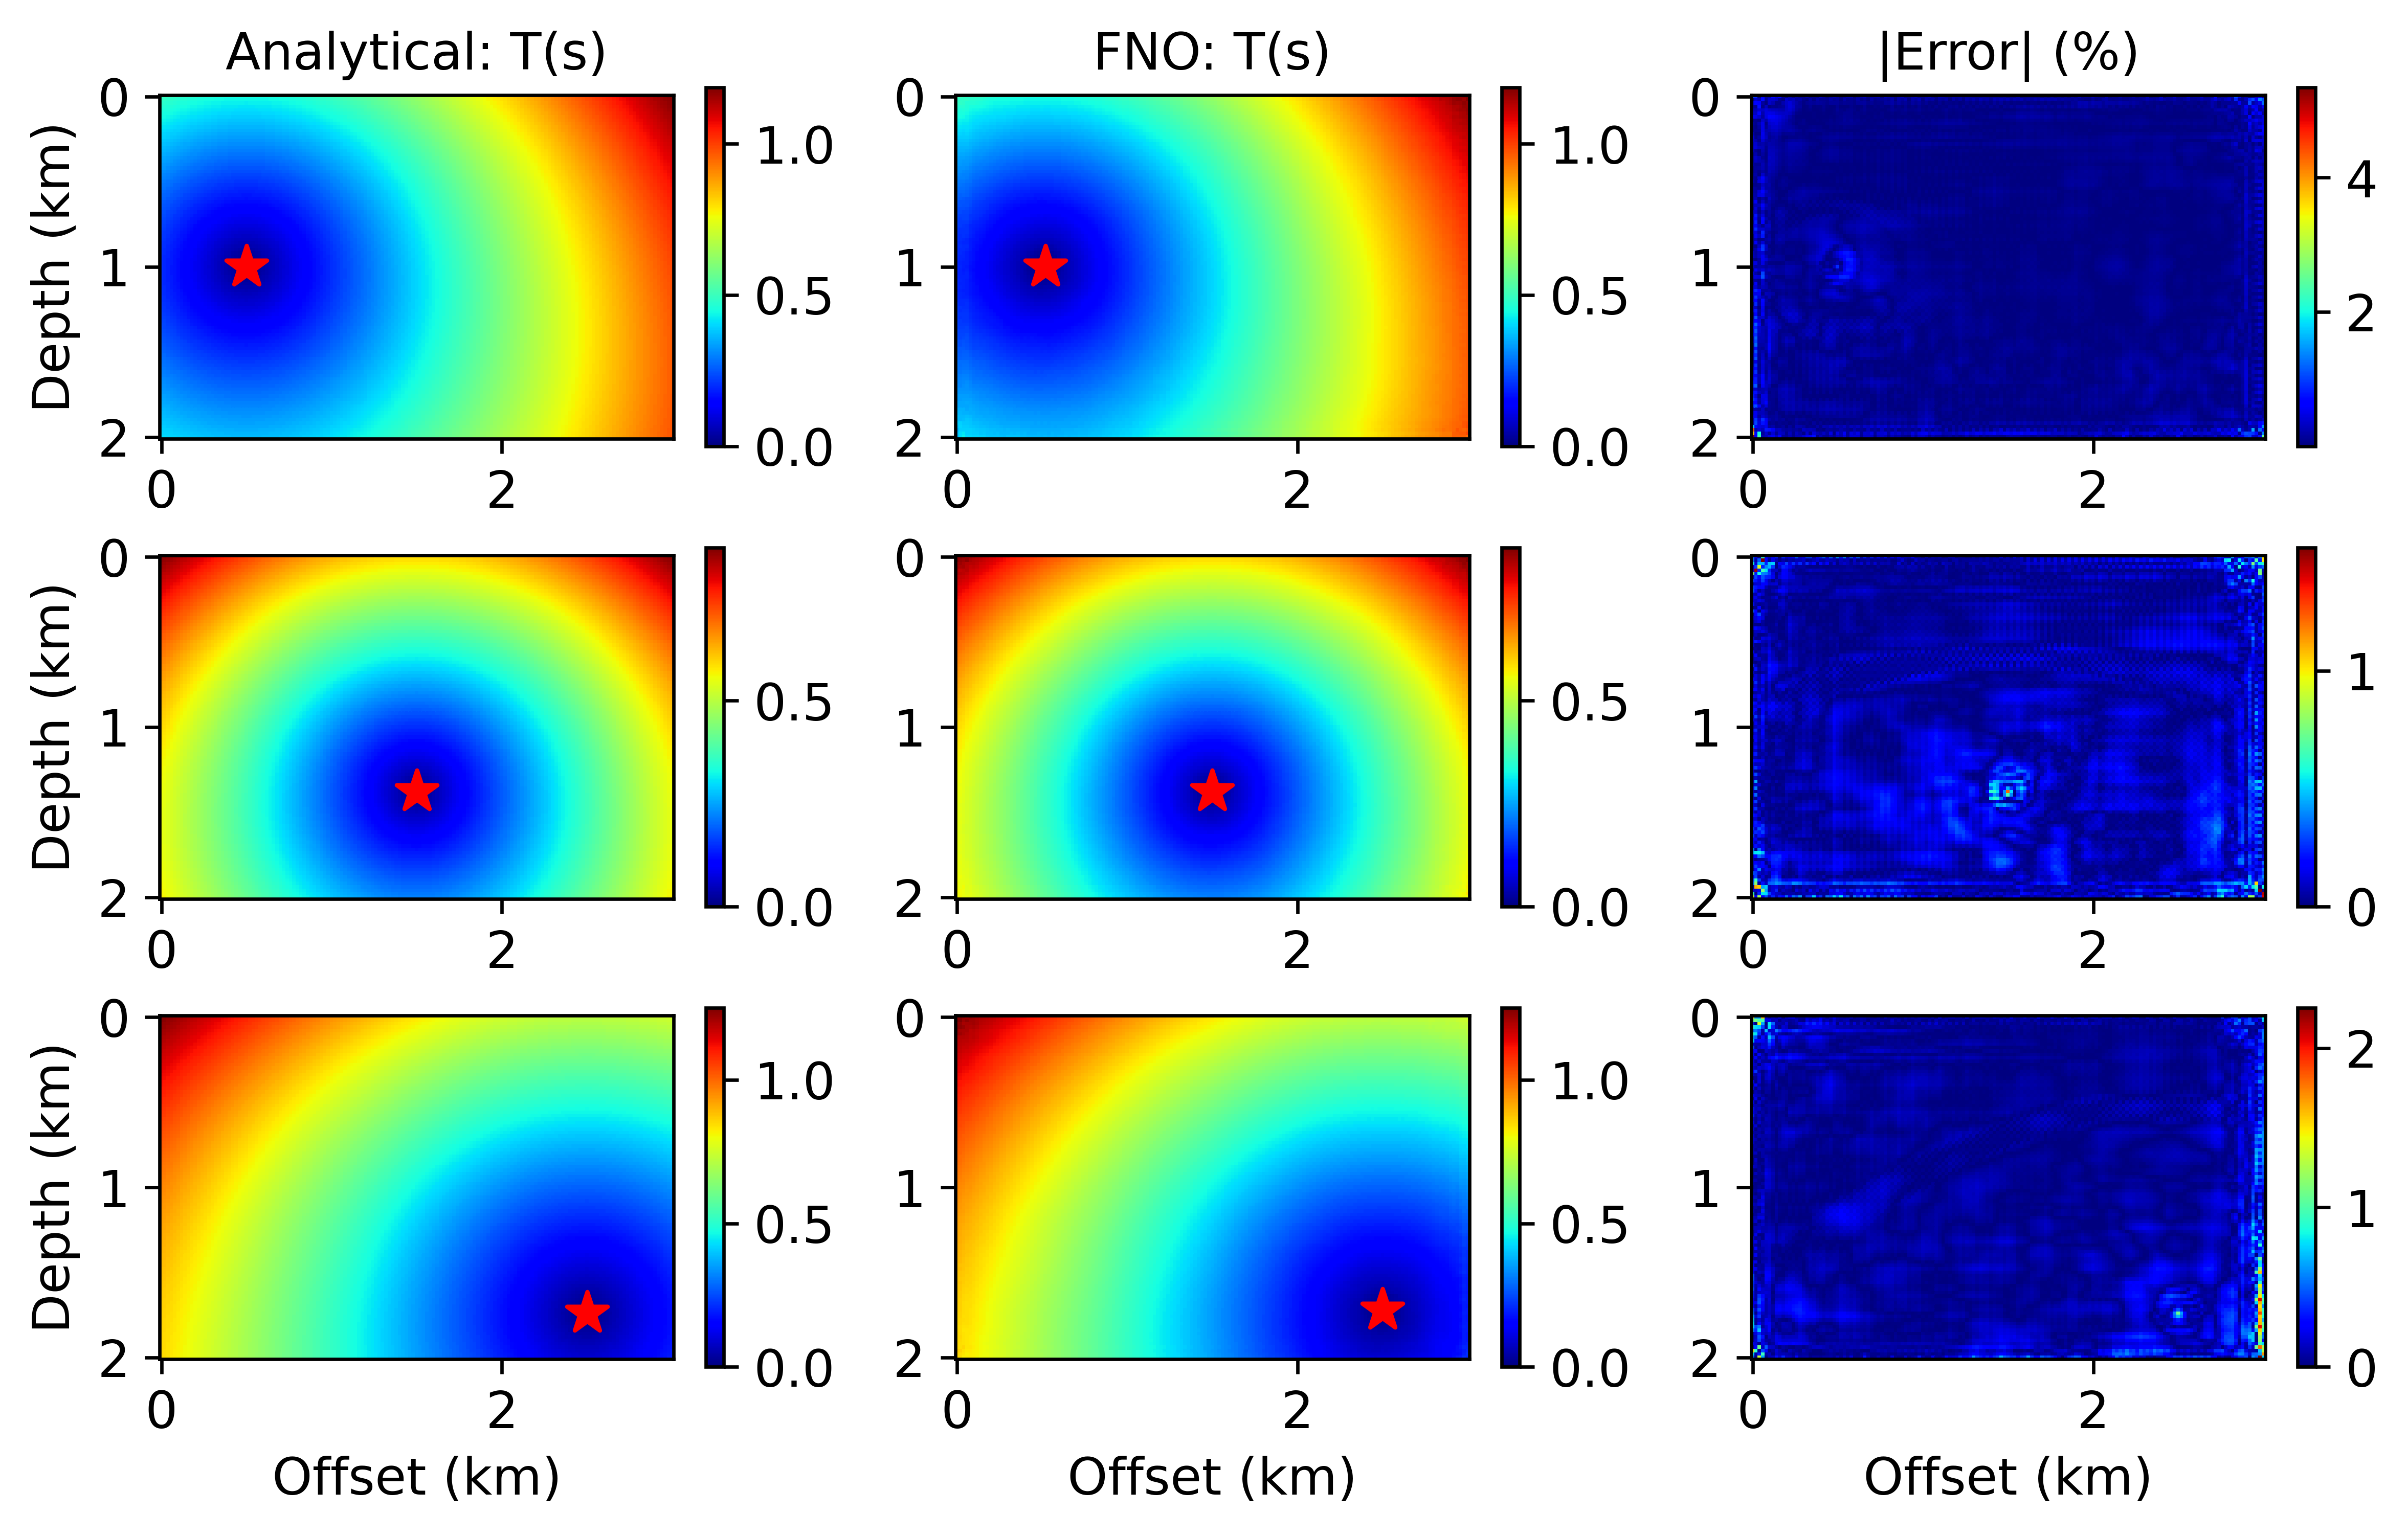

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(8,5), dpi = 600 )

x_test = XGRID.T
y_test = YGRID.T
batch_size = 1

for i, (xi, eta) in enumerate([(25, 50), (75, 69), (125, 87)]):

    vs = v0 + vergrad*y_test[eta,xi] + horgrad*x_test[eta,xi]    # velocity at the source location

    # for velocity gradient model
    T_data_y = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs) * (vergrad**2 + horgrad**2)*
                            ((X-x_test[eta,xi])**2 + (Z-y_test[eta,xi])**2)) / torch.sqrt(vergrad**2 + horgrad**2))
        
    T_data_x = T_data_y[0].clone()
    T_data_x = T_data_x.reshape(1,1,nx)
    T_data_x = T_data_x.repeat(1,nz,1)     
    T_data_x = T_data_x.reshape(1,1,nz,nx)
    T_data_x = T_data_x.type( 'torch.FloatTensor' )
    T_data_x = T_data_x.cuda()

    out = model(T_data_x).reshape(batch_size, nz, nx)
    pred = out.cpu()
    pred = pred.reshape(nz, nx)
    ssz, ssx = np.where(pred == torch.min(pred))
    ss = (deltax*ssx[0], deltaz*ssz[0])

    exact = T_data_y.detach().numpy()
    x_source = x_test[eta,xi]
    y_source = y_test[eta,xi]
    
    pred = pred.detach().numpy()
    x_source_pred = ss[0]
    y_source_pred = ss[1]

    cust_pcolor(ax[i, 0], x_test, y_test, exact, x_source, y_source, 'Analytical: T(s)' if i==0 else None, 
                cmap='jet', vmin=exact.min(), vmax=exact.max(), ylabel=True, xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 1], x_test, y_test, pred, x_source_pred, y_source_pred, 'FNO: T(s)' if i==0 else None,
                'jet', vmin=exact.min(), vmax=exact.max(), xlabel=True if i==2 else False)
    
    error = abs(pred - exact) / exact.max() * 100
    cust_pcolor(ax[i, 2], x_test, y_test, error, title='|Error| (%)' if i==0 else None,
                cmap='jet', xlabel=True if i==2 else False)

plt.tight_layout()

# plt.savefig( 'gradient_preds-pub_'+str(int(spacing*1000))+'m_m2w2.png' , dpi=600 )

plt.show()

In [24]:
# Generate test set

cord_z_test = np.random.uniform( 1, 1.75, size=(1000) )
cord_x_test = np.random.uniform( 0.5, 2.5, size=(1000) )

T_data_y_test = torch.zeros([len(cord_z_test),nz,nx])

rmse_error = []
source_error = []

for i in range(len(cord_z_test)):

        vs = v0 + vergrad*cord_z_test[i] + horgrad*cord_x_test[i]    # velocity at the source location

        # for velocity gradient model
        T_data_y_test[i,:,:] = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs) * (vergrad**2 + horgrad**2)*
                                ((X-cord_x_test[i])**2 + (Z-cord_z_test[i])**2)) / torch.sqrt(vergrad**2 + horgrad**2))

        T_data_x = T_data_y_test[i,0,:].clone()
        T_data_x = T_data_x.reshape(1,1,nx)
        T_data_x = T_data_x.repeat(1,nz,1)                    
        T_data_x = T_data_x.reshape(1,1,nz,nx)
        T_data_x = T_data_x.type( 'torch.FloatTensor' )
        T_data_x = T_data_x.cuda()
    
        out = model(T_data_x).reshape(batch_size, nz, nx)
        pred = out.cpu()
        pred = pred.reshape(nz, nx)
        ssz, ssx = np.where(pred == torch.min(pred))
        ss = ( deltax * ssx[0], deltaz * ssz[0] )

        exact = T_data_y_test[i,:,:].detach().numpy()
        x_source = cord_x_test[i]
        y_source = cord_z_test[i]
        
        pred = pred.detach().numpy()
        x_source_pred = ss[0]
        y_source_pred = ss[1]

        rmse_error.append( np.sqrt( np.mean( (exact - pred)**2 ) ) )
        source_error.append( [ x_source-x_source_pred, y_source-y_source_pred ] )
        

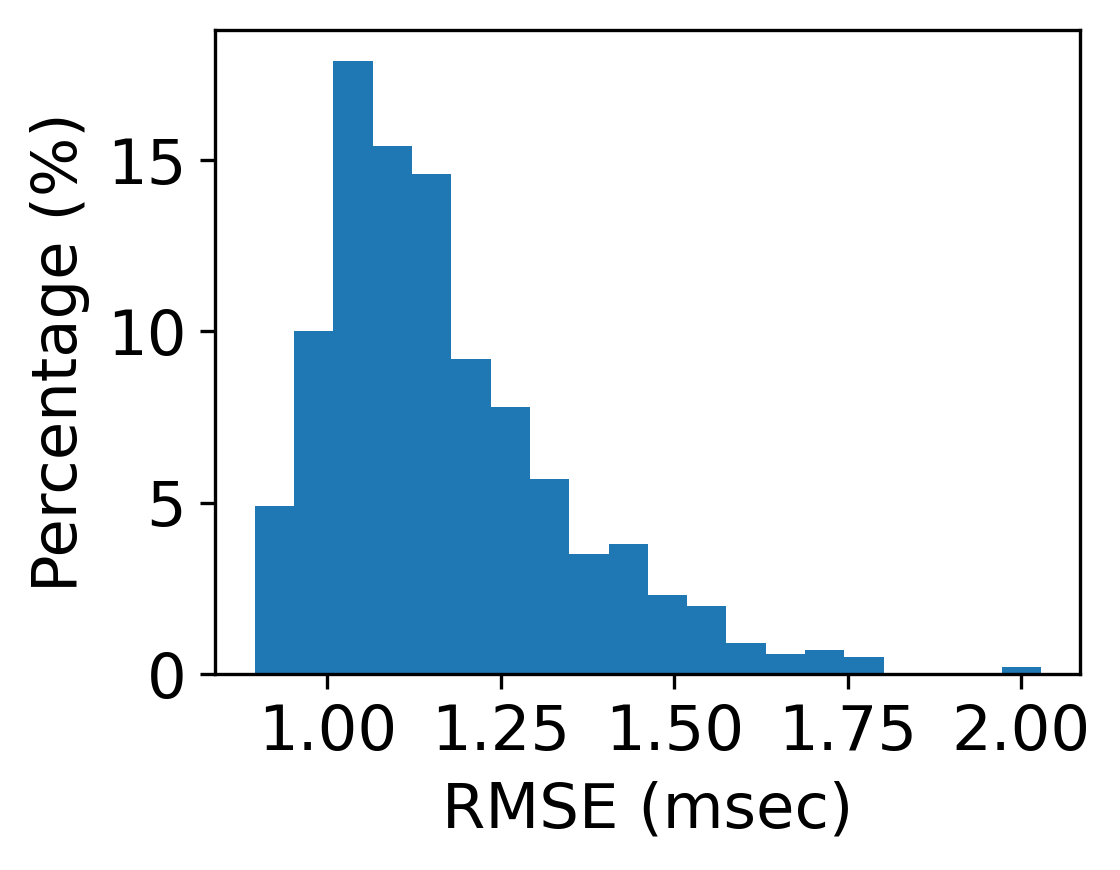

In [25]:
fsize = 15

rmse_error = np.array(rmse_error)
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100

plt.figure(figsize=(4,3), dpi = 300)

plt.hist(rmse_error*1000, 20, weights=weights)

plt.xlabel('RMSE (msec)',fontsize=fsize)
plt.ylabel('Percentage (%)',fontsize=fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.tight_layout()

# plt.savefig( 'gradient_RMSE_1000_'+str(int(spacing*1000))+'m_m2w2.pdf' , dpi=300 )

plt.show()

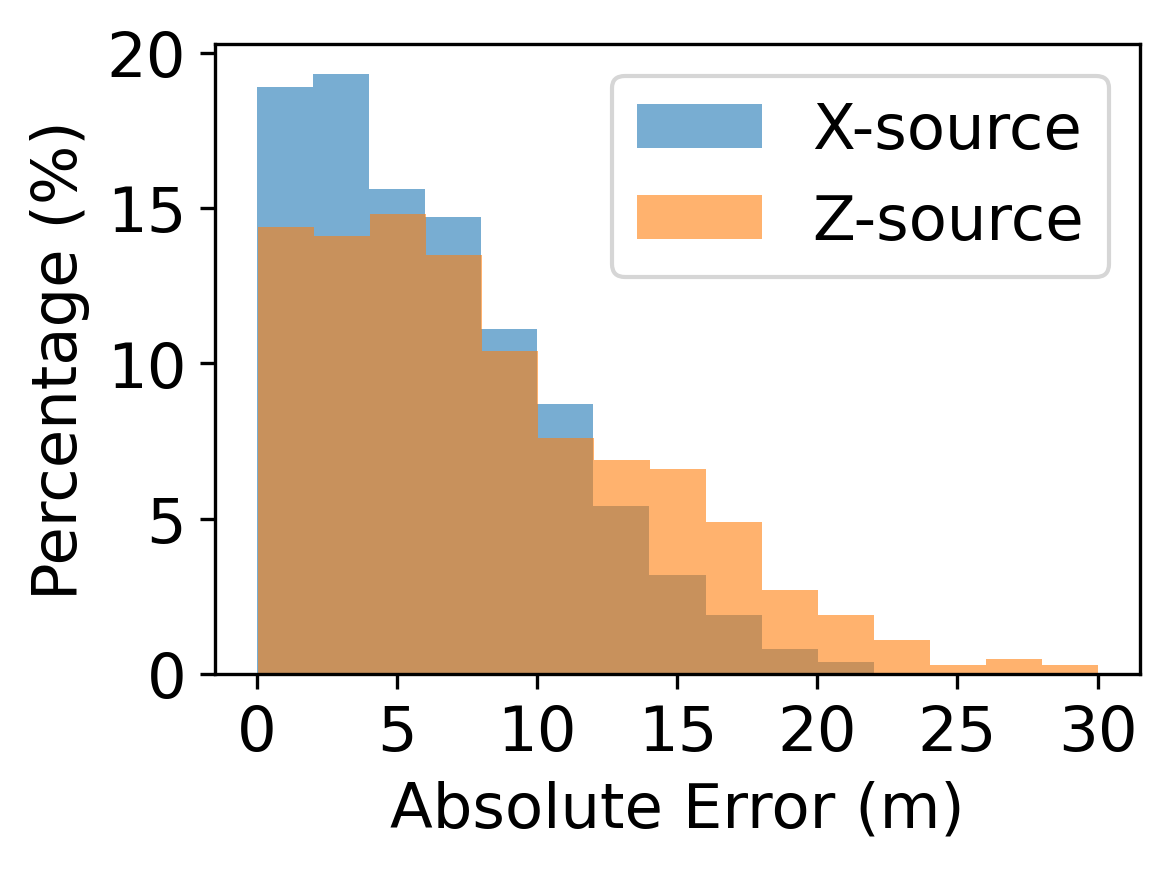

In [26]:
fsize = 15

weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
source_error = np.array(source_error)

fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi = 300)
ax = [ax]

# Desired bin width
bin_width = 2 # meters

for i in range(2) :

    data = abs(source_error[:, i])*1000
    
    # Define bin edges with a width of 2 meters
    bin_edges = np.arange( min(data), max(data) + bin_width, bin_width )

    # Create the histogram with exact bin edges
    ax[0].hist( data, bins=bin_edges, weights=weights, alpha=0.6 )

ax[0].set_xlabel('Absolute Error (m)',fontsize=fsize)
ax[0].set_ylabel('Percentage (%)',fontsize=fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

ax[0].yaxis.set_major_locator(plt.MultipleLocator(5))

plt.tight_layout()
plt.legend( ['X-source', 'Z-source'], fontsize=fsize )

# plt.savefig( 'gradient_abs_errors_1000_'+str(int(spacing*1000))+'m_m2w2.pdf' , dpi=300 )

plt.show()